# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [9]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


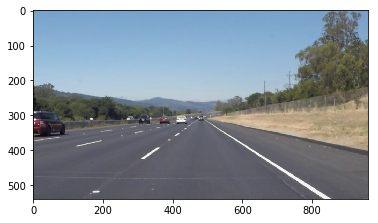

In [10]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [14]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    img_copy = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return img_copy
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def generate_coordinates(image, line_params):
    x=float('nan')
    print("Line Params: ", line_params)
    print("Type Debug: ", type(line_params))
#     if math.isnan(line_params) != True:
    if type(line_params) != 'numpy.float64':
        try:
            slope, intercept = line_params
            y1 = image.shape[0]
            y2 = int(y1*(3/5))
            x1 = int((y1 - intercept)/slope)
            x2 = int((y2 - intercept)/slope)
            return np.array([x1, y1, x2, y2])
        except:
            "Stupid is Nan error"


# We pass in the lines we detected from applying our Hough Transform
def draw_lines(img, lines, color=[255, 0, 0], thickness=12):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    # Coordinates for the average fit on the left
    left_fit = []
    # Coordinates for the average fit on the right
    right_fit = []
    for line in lines:
        print(line)
        x1,y1,x2,y2 = line.reshape(4)
        # Extract the parameters of a linear function by fitting a line through two point
        
        parameters = np.polyfit((x1, x2), (y1, y2), 1)
        slope = parameters[0]
        # The Lines on the left will have a negative slope, while the lines on the right will have a positive slope
        intercept = parameters[1]
        # If the slope is negative it will be a lane line on the left side
        if slope < 0:
            left_fit.append((slope, intercept))
        # If the slope is positive it will a lane line on the right side
        else:
            right_fit.append((slope, intercept))
    left_fit_average = np.average(left_fit, axis=0)
    right_fit_average = np.average(right_fit, axis=0)
    print("Right Fit Debug: ", right_fit_average)
    print("Left Fit Debug: ", left_fit_average)
    left_line = generate_coordinates(img, left_fit_average)
    right_line = generate_coordinates(img, right_fit_average)
    averaged_lines = np.array([left_line, right_line])
    
    for line in averaged_lines:
        if averaged_lines is not None:
            try:
                x1,y1,x2,y2 = line
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            except:
                "print none type"
        
            
#     cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [15]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

[[488 310 854 539]]
[[523 336 835 539]]
[[486 311 623 400]]
[[387 372 479 310]]
[[318 425 471 310]]
[[485 311 728 469]]
[[387 370 476 310]]
Right Fit Debug:  [ 0.64404122 -2.17275293]
Left Fit Debug:  [ -0.69990144 642.57427736]
Line Params:  [ -0.69990144 642.57427736]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.64404122 -2.17275293]
Type Debug:  <class 'numpy.ndarray'>


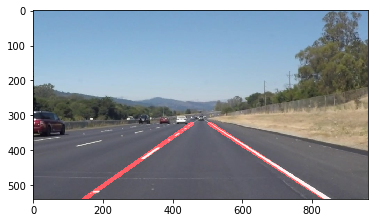

In [16]:
# TODO: Build your pipeline that will draw lane lines on the test_images

# Apply graysclae to image
grayscale_image = grayscale(image)
# Apply Gaussian Blurring
blurred_image = gaussian_blur(grayscale_image, 3)
# Apply the Canny Algorithm with a low threshold of 50 and a high threshold of 150
canny_image = canny(grayscale_image, 75, 150)
# Define vertices of polygon for region of interest
vertices = np.array([[(90, 540),(410, 310), (500, 310), (900, 540)]], dtype=np.int32)
masked_image = region_of_interest(canny_image, vertices)
# Apply Hough Transform on our lines
lines = hough_lines(masked_image, 2, np.pi/180, 100, 25, 25)
weighted_image = weighted_img(image, lines)
plt.imshow(weighted_image)
#plt.imshow(lines, cmap='gray')
# then save them to the test_images_output directory.

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [17]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [18]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    # Apply graysclae to image
    grayscale_image = grayscale(image)
    # Apply Gaussian Blurring
    blurred_image = gaussian_blur(grayscale_image, 5)
    # Apply the Canny Algorithm with a low threshold of 50 and a high threshold of 150
    canny_image = canny(grayscale_image, 50, 150)
    # Define vertices of polygon for region of interest
    vertices = np.array([[(90, 540),(410, 310), (500, 310), (900, 540)]], dtype=np.int32)
    masked_image = region_of_interest(canny_image, vertices)
    # Apply Hough Transform on our lines
    lines = hough_lines(masked_image, 2, np.pi/180, 100, 40, 5)
    
    result = weighted_img(image, lines)
    # plt.imshow(weighted_image)

    return result

Let's try the one with the solid white lane on the right first ...

In [19]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[[638 399 870 539]]
[[544 345 659 419]]
[[203 514 301 440]]
[[641 406 833 530]]
[[427 343 474 310]]
[[487 311 533 338]]
[[491 310 755 469]]
[[234 478 302 430]]
[[187 513 284 443]]
[[202 514 311 432]]
[[778 494 850 539]]
Right Fit Debug:  [0.61783152 8.02582071]
Left Fit Debug:  [ -0.72741102 653.43649037]
Line Params:  [ -0.72741102 653.43649037]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.61783152 8.02582071]
Type Debug:  <class 'numpy.ndarray'>
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


  0%|                                                                                          | 0/222 [00:00<?, ?it/s]

[[638 399 870 539]]
[[544 345 659 419]]
[[203 514 301 440]]
[[641 406 833 530]]
[[427 343 474 310]]
[[487 311 533 338]]
[[491 310 755 469]]
[[234 478 302 430]]
[[187 513 284 443]]
[[202 514 311 432]]
[[778 494 850 539]]
Right Fit Debug:  [0.61783152 8.02582071]
Left Fit Debug:  [ -0.72741102 653.43649037]
Line Params:  [ -0.72741102 653.43649037]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.61783152 8.02582071]
Type Debug:  <class 'numpy.ndarray'>
[[490 310 865 536]]
[[486 310 717 455]]
[[170 539 289 449]]
[[150 538 230 482]]
[[701 446 799 508]]
[[207 497 279 446]]
[[169 539 289 448]]
[[680 432 735 467]]
[[738 470 848 539]]
Right Fit Debug:  [0.62533234 5.69681138]
Left Fit Debug:  [ -0.7307423  655.33869048]
Line Params:  [ -0.7307423  655.33869048]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.62533234 5.69681138]
Type Debug:  <class 'numpy.ndarray'>
[[666 416 870 539]]
[[486 310 670 425]]
[[169 539 262 469]]
[[155 534 250 467]]
[[492 310 558 352]]
[[695 441 742 472]

  1%|█                                                                                 | 3/222 [00:00<00:09, 23.14it/s]

[[490 310 846 524]]
[[487 311 766 486]]
[[168 539 230 492]]
[[148 538 211 494]]
[[803 511 848 539]]
[[511 323 671 419]]
[[421 345 471 310]]
Right Fit Debug:  [ 0.61264649 12.18476098]
Left Fit Debug:  [ -0.71882574 649.13997269]
Line Params:  [ -0.71882574 649.13997269]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.61264649 12.18476098]
Type Debug:  <class 'numpy.ndarray'>
[[497 314 871 539]]
[[705 448 851 539]]
[[787 488 871 538]]
[[502 319 603 384]]
[[417 347 470 310]]
[[584 371 676 430]]
[[491 310 564 354]]
Right Fit Debug:  [0.61795641 8.26603885]
Left Fit Debug:  [ -0.69811321 638.11320755]
Line Params:  [ -0.69811321 638.11320755]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.61795641 8.26603885]
Type Debug:  <class 'numpy.ndarray'>
[[564 359 790 501]]
[[546 344 714 445]]
[[623 389 776 481]]
[[506 319 871 539]]
[[487 310 683 433]]
[[775 493 851 539]]
Right Fit Debug:  [ 0.61106169 12.84689064]
Left Fit Debug:  nan
Line Params:  nan
Type Debug:  <class 'numpy.floa

  3%|██▏                                                                               | 6/222 [00:00<00:09, 22.22it/s]

[[675 429 744 472]]
[[609 381 872 539]]
[[739 468 849 539]]
[[490 310 755 469]]
[[572 364 774 491]]
[[430 338 470 310]]
[[487 310 594 377]]
Right Fit Debug:  [0.62071408 6.65435192]
Left Fit Debug:  [ -0.7 639. ]
Line Params:  [ -0.7 639. ]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.62071408 6.65435192]
Type Debug:  <class 'numpy.ndarray'>
[[491 310 818 506]]
[[487 310 742 470]]
[[743 472 845 534]]
[[411 354 470 310]]
[[326 410 367 383]]
[[515 325 683 426]]
[[578 368 775 491]]
Right Fit Debug:  [ 0.61204769 12.60157668]
Left Fit Debug:  [ -0.70214965 642.5957007 ]
Line Params:  [ -0.70214965 642.5957007 ]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.61204769 12.60157668]
Type Debug:  <class 'numpy.ndarray'>
[[516 326 871 539]]
[[599 382 850 539]]
[[674 420 804 498]]
[[309 423 356 390]]
[[526 334 641 408]]
[[316 425 362 392]]
[[684 434 753 478]]
Right Fit Debug:  [0.62133149 6.53664299]
Left Fit Debug:  [ -0.70975948 645.82654949]
Line Params:  [ -0.70975948 645.826

  4%|███▎                                                                              | 9/222 [00:00<00:08, 23.82it/s]

[[516 328 867 539]]
[[594 381 847 539]]
[[299 440 351 401]]
[[290 438 335 407]]
[[485 310 623 399]]
[[490 311 579 365]]
[[749 479 845 539]]
[[306 426 346 399]]
Right Fit Debug:  [0.62046293 9.92744364]
Left Fit Debug:  [ -0.70462963 644.85925926]
Line Params:  [ -0.70462963 644.85925926]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.62046293 9.92744364]
Type Debug:  <class 'numpy.ndarray'>
[[563 359 861 539]]
[[524 337 764 492]]
[[263 459 333 410]]
[[732 471 841 539]]
[[433 344 476 313]]
[[421 350 473 311]]
[[482 311 688 444]]
[[485 310 588 374]]
[[284 454 339 411]]
Right Fit Debug:  [0.62814074 8.06045414]
Left Fit Debug:  [ -0.7381871  660.26228858]
Line Params:  [ -0.7381871  660.26228858]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.62814074 8.06045414]
Type Debug:  <class 'numpy.ndarray'>
[[482 311 779 504]]
[[488 312 750 475]]
[[566 362 638 406]]
[[232 480 316 421]]
[[787 496 857 539]]
[[240 485 324 424]]
[[649 414 713 453]]
[[419 350 475 311]]
[[761 492 836 539]

  5%|████▍                                                                            | 12/222 [00:00<00:08, 25.21it/s]

[[587 379 833 539]]
[[485 310 784 496]]
[[417 351 457 323]]
[[196 516 299 441]]
[[183 514 300 432]]
[[607 387 664 422]]
[[786 496 856 539]]
[[219 499 307 435]]
[[532 342 604 390]]
Right Fit Debug:  [0.63349351 4.05823203]
Left Fit Debug:  [ -0.71407069 650.53689603]
Line Params:  [ -0.71407069 650.53689603]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.63349351 4.05823203]
Type Debug:  <class 'numpy.ndarray'>
[[490 311 849 535]]
[[606 390 835 539]]
[[144 538 275 447]]
[[484 310 632 406]]
[[201 510 285 449]]
[[161 539 284 450]]
[[578 367 791 500]]
Right Fit Debug:  [0.63691806 0.77703779]
Left Fit Debug:  [ -0.71480807 649.83025167]
Line Params:  [ -0.71480807 649.83025167]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.63691806 0.77703779]
Type Debug:  <class 'numpy.ndarray'>
[[492 310 537 340]]
[[563 360 702 451]]
[[521 329 857 539]]
[[141 539 246 465]]
[[169 532 258 467]]
[[646 415 836 539]]
[[487 310 633 405]]
[[514 324 678 427]]
[[423 345 464 316]]
[[423 343 466 311]

  7%|█████▊                                                                           | 16/222 [00:00<00:07, 26.68it/s]

[[552 349 764 491]]
[[642 403 858 538]]
[[498 312 860 538]]
[[492 310 573 364]]
[[770 495 840 539]]
[[681 435 769 493]]
Right Fit Debug:  [ 0.64557495 -6.45547258]
Left Fit Debug:  nan
Line Params:  nan
Type Debug:  <class 'numpy.float64'>
Line Params:  [ 0.64557495 -6.45547258]
Type Debug:  <class 'numpy.ndarray'>
[[496 311 858 538]]
[[490 310 648 413]]
[[651 415 836 539]]
[[520 327 856 537]]
[[423 342 470 311]]
[[497 315 667 426]]
Right Fit Debug:  [ 0.6454364  -7.66314294]
Left Fit Debug:  [ -0.65957447 621.        ]
Line Params:  [ -0.65957447 621.        ]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.6454364  -7.66314294]
Type Debug:  <class 'numpy.ndarray'>
[[497 313 856 538]]
[[610 385 856 539]]
[[570 364 741 476]]
[[487 310 666 426]]
[[704 452 834 539]]
[[429 340 469 313]]
Right Fit Debug:  [ 0.64500069 -5.88594593]
Left Fit Debug:  [ -0.675 629.575]
Line Params:  [ -0.675 629.575]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.64500069 -5.88594593]
Type Debug

  9%|███████▎                                                                         | 20/222 [00:00<00:07, 28.34it/s]

[[488 310 854 539]]
[[730 472 833 539]]
[[486 311 641 412]]
[[636 410 834 539]]
[[310 423 356 392]]
[[320 425 362 394]]
[[426 344 471 310]]
Right Fit Debug:  [ 0.64482414 -2.0588024 ]
Left Fit Debug:  [ -0.72252128 652.99006211]
Line Params:  [ -0.72252128 652.99006211]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.64482414 -2.0588024 ]
Type Debug:  <class 'numpy.ndarray'>
[[493 313 855 539]]
[[660 426 834 539]]
[[486 311 659 424]]
[[424 346 469 316]]
[[308 434 352 401]]
[[290 437 347 399]]
[[624 402 833 538]]
[[519 330 828 523]]
Right Fit Debug:  [ 0.64044541 -0.41264044]
Left Fit Debug:  [ -0.69444444 641.33333333]
Line Params:  [ -0.69444444 641.33333333]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.64044541 -0.41264044]
Type Debug:  <class 'numpy.ndarray'>
[[504 320 854 539]]
[[516 331 769 496]]
[[264 455 335 407]]
[[662 427 834 539]]
[[275 457 341 409]]
[[422 348 476 311]]
Right Fit Debug:  [ 0.643017   -1.65050219]
Left Fit Debug:  [ -0.69617142 642.54234046]
L

 11%|████████▊                                                                        | 24/222 [00:00<00:06, 28.67it/s]

[[500 316 855 538]]
[[512 327 720 463]]
[[228 478 299 430]]
[[201 510 310 431]]
[[426 342 472 310]]
[[187 507 234 475]]
[[724 467 834 539]]
[[186 507 302 429]]
[[598 382 752 485]]
Right Fit Debug:  [ 0.65064372 -7.32430879]
Left Fit Debug:  [ -0.6899488  638.51113694]
Line Params:  [ -0.6899488  638.51113694]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.65064372 -7.32430879]
Type Debug:  <class 'numpy.ndarray'>
[[578 369 723 466]]
[[523 331 855 539]]
[[523 334 566 363]]
[[217 486 277 445]]
[[222 496 289 446]]
[[161 539 271 459]]
[[146 536 250 464]]
[[636 407 819 530]]
[[570 360 767 483]]
[[553 353 637 409]]
Right Fit Debug:  [  0.65550891 -10.84600853]
Left Fit Debug:  [ -0.7122956  647.28070182]
Line Params:  [ -0.7122956  647.28070182]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.65550891 -10.84600853]
Type Debug:  <class 'numpy.ndarray'>
[[500 316 856 539]]
[[521 333 749 482]]
[[147 536 249 465]]
[[164 539 246 478]]
[[162 539 213 502]]
[[752 484 834 539]]
[[596 

 13%|██████████▏                                                                      | 28/222 [00:01<00:06, 29.23it/s]

[[523 331 856 539]]
[[531 340 799 515]]
[[779 503 834 539]]
[[589 377 642 412]]
[[418 349 476 310]]
[[725 467 793 512]]
[[418 348 473 310]]
Right Fit Debug:  [ 0.65085944 -6.80926766]
Left Fit Debug:  [ -0.68166144 633.43448276]
Line Params:  [ -0.68166144 633.43448276]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.65085944 -6.80926766]
Type Debug:  <class 'numpy.ndarray'>
[[493 314 697 447]]
[[502 317 581 367]]
[[534 338 683 431]]
[[643 405 858 539]]
[[536 343 809 521]]
[[429 339 470 310]]
[[528 334 855 538]]
[[426 344 471 310]]
[[433 340 474 311]]
Right Fit Debug:  [ 0.63469282 -0.17800606]
Left Fit Debug:  [ -0.72339657 651.52466125]
Line Params:  [ -0.72339657 651.52466125]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.63469282 -0.17800606]
Type Debug:  <class 'numpy.ndarray'>
[[537 343 813 523]]
[[679 427 859 539]]
[[538 340 703 443]]
[[598 377 858 539]]
[[487 310 587 375]]
[[429 339 470 310]]
[[423 345 475 310]]
[[779 501 836 539]]
Right Fit Debug:  [ 0.63973036

 14%|███████████▋                                                                     | 32/222 [00:01<00:06, 29.05it/s]

[[505 318 858 539]]
[[564 361 838 539]]
[[546 345 687 433]]
[[526 335 811 521]]
[[418 348 474 310]]
[[311 421 355 390]]
[[322 422 363 391]]
Right Fit Debug:  [ 0.6381106  -1.90145041]
Left Fit Debug:  [ -0.71307148 645.73996938]
Line Params:  [ -0.71307148 645.73996938]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.6381106  -1.90145041]
Type Debug:  <class 'numpy.ndarray'>
[[543 347 838 539]]
[[541 342 786 495]]
[[727 457 859 539]]
[[292 435 345 398]]
[[615 388 855 537]]
[[302 437 351 400]]
[[488 310 551 351]]
Right Fit Debug:  [0.63363527 0.34396744]
Left Fit Debug:  [ -0.72660762 651.94493647]
Line Params:  [ -0.72660762 651.94493647]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.63363527 0.34396744]
Type Debug:  <class 'numpy.ndarray'>
[[532 337 854 538]]
[[556 357 836 539]]
[[267 453 331 408]]
[[279 455 342 408]]
[[422 347 471 310]]
[[490 311 610 392]]
Right Fit Debug:  [ 0.6497412  -6.41231884]
Left Fit Debug:  [ -0.73475293 656.51009779]
Line Params:  [ -0.734752

 16%|████████████▊                                                                    | 35/222 [00:01<00:06, 28.28it/s]

[[539 342 840 530]]
[[560 360 835 539]]
[[248 478 328 418]]
[[566 360 723 458]]
[[428 341 472 310]]
[[235 475 308 426]]
[[270 451 320 417]]
[[538 345 634 408]]
Right Fit Debug:  [ 0.63898691 -0.13052919]
Left Fit Debug:  [ -0.70144458 643.47129514]
Line Params:  [ -0.70144458 643.47129514]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.63898691 -0.13052919]
Type Debug:  <class 'numpy.ndarray'>
[[564 363 835 539]]
[[533 338 853 538]]
[[557 354 794 502]]
[[208 508 303 437]]
[[192 507 302 430]]
[[499 319 581 373]]
[[217 502 312 430]]
Right Fit Debug:  [ 0.63936391 -0.46345065]
Left Fit Debug:  [ -0.73508772 657.10526316]
Line Params:  [ -0.73508772 657.10526316]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.63936391 -0.46345065]
Type Debug:  <class 'numpy.ndarray'>
[[552 350 853 538]]
[[643 415 834 539]]
[[145 539 279 445]]
[[166 539 235 487]]
[[576 366 792 501]]
[[146 539 281 445]]
[[520 331 614 396]]
[[198 516 291 446]]
[[169 537 291 445]]
[[577 370 688 444]]
[[431 340 

 17%|█████████████▊                                                                   | 38/222 [00:01<00:06, 28.47it/s]

[[556 352 855 539]]
[[622 401 834 539]]
[[165 539 264 465]]
[[143 539 244 469]]
[[552 353 626 402]]
[[148 537 253 464]]
[[609 391 686 442]]
[[423 346 471 310]]
[[501 319 551 351]]
[[588 373 629 399]]
Right Fit Debug:  [ 0.6458346  -4.33573876]
Left Fit Debug:  [ -0.72144554 650.89687058]
Line Params:  [ -0.72144554 650.89687058]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.6458346  -4.33573876]
Type Debug:  <class 'numpy.ndarray'>
[[488 310 536 340]]
[[611 387 832 525]]
[[671 431 804 520]]
[[146 537 215 489]]
[[577 365 855 539]]
[[618 396 672 433]]
[[765 493 834 539]]
[[168 536 229 490]]
[[687 442 738 477]]
[[510 324 642 413]]
[[142 539 214 489]]
[[163 539 221 496]]
[[506 319 585 369]]
Right Fit Debug:  [  0.65442075 -10.96890754]
Left Fit Debug:  [ -0.72139357 649.67742017]
Line Params:  [ -0.72139357 649.67742017]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.65442075 -10.96890754]
Type Debug:  <class 'numpy.ndarray'>
[[558 352 856 539]]
[[656 421 801 518]]
[[532 

 18%|██████████████▉                                                                  | 41/222 [00:01<00:06, 27.96it/s]

[[649 416 819 530]]
[[572 361 855 538]]
[[607 388 675 435]]
[[723 465 834 539]]
[[566 360 611 392]]
[[495 310 595 375]]
[[500 317 550 349]]
[[431 339 474 310]]
Right Fit Debug:  [  0.66499774 -17.39248877]
Left Fit Debug:  [ -0.6744186 629.6744186]
Line Params:  [ -0.6744186 629.6744186]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.66499774 -17.39248877]
Type Debug:  <class 'numpy.ndarray'>
[[577 364 853 537]]
[[491 311 753 487]]
[[609 385 664 420]]
[[543 342 611 385]]
[[629 403 799 517]]
[[649 410 855 539]]
[[795 513 835 539]]
Right Fit Debug:  [ 0.64486939 -5.62543913]
Left Fit Debug:  nan
Line Params:  nan
Type Debug:  <class 'numpy.float64'>
Line Params:  [ 0.64486939 -5.62543913]
Type Debug:  <class 'numpy.ndarray'>
[[504 320 564 358]]
[[551 350 813 526]]
[[495 310 696 440]]
[[664 419 856 539]]
[[426 339 466 311]]
Right Fit Debug:  [ 0.64421381 -6.37166458]
Left Fit Debug:  [ -0.7 637.2]
Line Params:  [ -0.7 637.2]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.

 20%|████████████████                                                                 | 44/222 [00:01<00:06, 28.33it/s]

[[490 310 792 513]]
[[660 416 778 492]]
[[495 310 716 453]]
[[424 341 467 311]]
[[319 414 359 387]]
[[323 420 364 389]]
[[740 467 855 539]]
[[518 328 824 534]]
Right Fit Debug:  [  0.65252032 -11.15460528]
Left Fit Debug:  [ -0.70959066 643.45282189]
Line Params:  [ -0.70959066 643.45282189]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.65252032 -11.15460528]
Type Debug:  <class 'numpy.ndarray'>
[[490 310 773 500]]
[[590 372 856 539]]
[[501 315 604 380]]
[[295 432 349 394]]
[[304 434 354 396]]
[[699 450 836 539]]
[[295 431 346 395]]
[[630 398 854 538]]
Right Fit Debug:  [ 0.64098013 -3.67974758]
Left Fit Debug:  [ -0.72319535 647.95596224]
Line Params:  [ -0.72319535 647.95596224]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.64098013 -3.67974758]
Type Debug:  <class 'numpy.ndarray'>
[[521 330 813 526]]
[[495 310 679 429]]
[[658 415 856 539]]
[[270 448 336 402]]
[[421 344 464 312]]
[[598 376 672 423]]
[[285 448 338 407]]
Right Fit Debug:  [ 0.64484244 -7.68495431]
Le

 21%|█████████████████▏                                                               | 47/222 [00:01<00:06, 28.46it/s]

[[522 331 818 530]]
[[774 489 854 539]]
[[494 310 669 423]]
[[240 469 322 412]]
[[645 407 854 538]]
[[251 472 329 413]]
Right Fit Debug:  [ 0.64245146 -5.23858575]
Left Fit Debug:  [ -0.7257661  648.84412133]
Line Params:  [ -0.7257661  648.84412133]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.64245146 -5.23858575]
Type Debug:  <class 'numpy.ndarray'>
[[570 360 854 538]]
[[518 329 780 505]]
[[424 341 467 311]]
[[198 500 291 434]]
[[211 502 313 425]]
[[492 310 624 393]]
[[242 467 304 425]]
[[675 427 854 539]]
[[531 337 831 539]]
[[427 341 470 312]]
Right Fit Debug:  [ 0.64526716 -6.29459837]
Left Fit Debug:  [ -0.70281835 639.70532486]
Line Params:  [ -0.70281835 639.70532486]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.64526716 -6.29459837]
Type Debug:  <class 'numpy.ndarray'>
[[689 436 854 539]]
[[521 331 820 532]]
[[140 539 283 439]]
[[184 522 292 441]]
[[533 335 702 444]]
[[489 310 544 347]]
[[160 539 233 484]]
[[184 507 232 474]]
[[493 310 592 374]]
Right Fit 

 23%|██████████████████▏                                                              | 50/222 [00:01<00:06, 28.04it/s]

[[661 418 854 539]]
[[529 336 831 539]]
[[428 339 469 310]]
[[139 539 255 458]]
[[504 318 706 445]]
[[161 538 254 468]]
[[513 326 739 478]]
[[186 520 266 460]]
Right Fit Debug:  [ 0.65010192 -8.47331374]
Left Fit Debug:  [ -0.72707028 649.11871196]
Line Params:  [ -0.72707028 649.11871196]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.65010192 -8.47331374]
Type Debug:  <class 'numpy.ndarray'>
[[534 339 831 539]]
[[488 311 541 344]]
[[659 416 853 538]]
[[503 317 670 422]]
[[143 533 219 482]]
[[156 539 236 481]]
[[138 537 200 495]]
[[420 345 468 310]]
Right Fit Debug:  [ 0.63841267 -2.78129541]
Left Fit Debug:  [ -0.70065966 640.69859932]
Line Params:  [ -0.70065966 640.69859932]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.63841267 -2.78129541]
Type Debug:  <class 'numpy.ndarray'>
[[527 335 819 531]]
[[673 425 853 538]]
[[492 310 675 425]]
[[433 337 473 310]]
[[425 341 465 312]]
[[567 358 614 387]]
[[592 374 747 471]]
Right Fit Debug:  [ 0.63405074 -0.74859631]
Left F

 24%|███████████████████▎                                                             | 53/222 [00:01<00:06, 27.52it/s]

[[698 441 854 539]]
[[541 344 831 539]]
[[568 359 625 394]]
[[530 338 656 422]]
[[593 375 807 509]]
[[531 336 600 378]]
[[423 342 467 310]]
[[430 338 472 311]]
[[493 311 578 364]]
Right Fit Debug:  [ 0.63424485 -0.32906472]
Left Fit Debug:  [ -0.68506494 632.03246753]
Line Params:  [ -0.68506494 632.03246753]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.63424485 -0.32906472]
Type Debug:  <class 'numpy.ndarray'>
[[509 322 774 488]]
[[679 436 833 539]]
[[566 362 677 435]]
[[486 310 551 351]]
[[666 428 831 539]]
[[716 452 811 513]]
[[428 340 475 310]]
[[493 311 609 384]]
Right Fit Debug:  [ 0.64683086 -6.97192273]
Left Fit Debug:  [ -0.63829787 613.19148936]
Line Params:  [ -0.63829787 613.19148936]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.64683086 -6.97192273]
Type Debug:  <class 'numpy.ndarray'>
[[491 311 802 506]]
[[542 346 736 476]]
[[653 420 830 539]]
[[322 410 362 383]]
[[765 484 853 539]]
Right Fit Debug:  [ 0.64860728 -6.80130287]
Left Fit Debug:  [ -0.675 

 25%|████████████████████▍                                                            | 56/222 [00:02<00:06, 27.62it/s]

[[670 432 828 538]]
[[488 310 630 399]]
[[597 379 852 539]]
[[307 421 353 390]]
[[483 310 635 409]]
[[314 423 358 392]]
[[307 420 351 390]]
[[596 384 680 439]]
Right Fit Debug:  [ 0.64623506 -3.95293653]
Left Fit Debug:  [ -0.68675889 633.81225296]
Line Params:  [ -0.68675889 633.81225296]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.64623506 -3.95293653]
Type Debug:  <class 'numpy.ndarray'>
[[599 381 851 539]]
[[729 472 829 539]]
[[505 325 655 423]]
[[547 351 607 391]]
[[423 346 477 311]]
[[680 440 806 524]]
[[296 437 347 400]]
[[515 329 607 385]]
[[285 435 342 398]]
[[486 311 550 354]]
Right Fit Debug:  [ 0.65203164 -6.13376232]
Left Fit Debug:  [ -0.67425372 630.6372549 ]
Line Params:  [ -0.67425372 630.6372549 ]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.65203164 -6.13376232]
Type Debug:  <class 'numpy.ndarray'>
[[507 323 693 440]]
[[688 447 830 539]]
[[505 325 649 419]]
[[421 347 476 311]]
[[427 340 471 310]]
[[619 394 850 539]]
[[260 452 328 406]]
[[272 454 

 27%|█████████████████████▌                                                           | 59/222 [00:02<00:06, 26.94it/s]

[[522 335 814 531]]
[[507 323 682 433]]
[[226 474 312 416]]
[[562 361 827 539]]
[[669 426 849 539]]
[[240 476 321 417]]
[[419 348 473 310]]
[[226 475 314 416]]
[[238 476 303 430]]
Right Fit Debug:  [ 0.64982005 -5.38673722]
Left Fit Debug:  [ -0.69693284 638.20775356]
Line Params:  [ -0.69693284 638.20775356]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.64982005 -5.38673722]
Type Debug:  <class 'numpy.ndarray'>
[[488 313 824 539]]
[[765 487 846 539]]
[[507 323 650 413]]
[[181 506 265 449]]
[[195 507 249 468]]
[[197 507 303 430]]
[[425 344 476 311]]
[[181 505 294 429]]
[[702 448 800 510]]
[[586 374 648 412]]
Right Fit Debug:  [0.63790425 0.65522905]
Left Fit Debug:  [ -0.68936679 634.49860975]
Line Params:  [ -0.68936679 634.49860975]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.63790425 0.65522905]
Type Debug:  <class 'numpy.ndarray'>
[[483 310 610 395]]
[[612 389 841 537]]
[[131 539 272 444]]
[[539 343 637 406]]
[[526 338 824 539]]
[[148 539 281 446]]
[[596 379 747 

 28%|██████████████████████▌                                                          | 62/222 [00:02<00:06, 26.21it/s]

[[556 358 825 539]]
[[660 421 774 493]]
[[513 328 707 450]]
[[146 529 192 498]]
[[483 310 823 539]]
[[131 538 248 460]]
[[161 532 252 466]]
[[150 539 220 489]]
[[708 452 843 537]]
[[450 312 494 312]]
Right Fit Debug:  [ 0.64729328 -3.1308721 ]
Left Fit Debug:  [-5.56028030e-01  5.71927345e+02]
Line Params:  [-5.56028030e-01  5.71927345e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.64729328 -3.1308721 ]
Type Debug:  <class 'numpy.ndarray'>
[[539 347 825 539]]
[[596 381 758 483]]
[[510 326 696 443]]
[[150 526 190 499]]
[[149 539 215 493]]
[[748 478 845 539]]
[[689 449 821 538]]
[[130 539 203 490]]
[[697 445 778 496]]
[[593 384 823 539]]
Right Fit Debug:  [ 0.64809166 -3.04841918]
Left Fit Debug:  [ -0.68106752 632.11958627]
Line Params:  [ -0.68106752 632.11958627]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.64809166 -3.04841918]
Type Debug:  <class 'numpy.ndarray'>
[[600 384 762 486]]
[[483 310 823 539]]
[[536 342 645 412]]
[[432 340 476 310]]
[[749 479 843 538]

 29%|███████████████████████▋                                                         | 65/222 [00:02<00:05, 26.69it/s]

[[644 412 798 509]]
[[505 325 823 539]]
[[756 483 841 538]]
[[513 328 624 398]]
[[736 481 822 539]]
[[411 350 452 324]]
[[596 381 758 483]]
[[421 345 478 310]]
Right Fit Debug:  [ 0.6474273  -3.30007789]
Left Fit Debug:  [ -0.62409071 607.07145914]
Line Params:  [ -0.62409071 607.07145914]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.6474273  -3.30007789]
Type Debug:  <class 'numpy.ndarray'>
[[489 313 825 539]]
[[662 421 817 521]]
[[491 311 691 441]]
[[411 352 454 322]]
[[426 339 470 310]]
[[724 460 846 539]]
[[426 338 468 310]]
Right Fit Debug:  [ 0.65383033 -9.74429015]
Left Fit Debug:  [ -0.67447733 626.83897111]
Line Params:  [ -0.67447733 626.83897111]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.65383033 -9.74429015]
Type Debug:  <class 'numpy.ndarray'>
[[489 312 826 539]]
[[491 311 696 444]]
[[597 379 766 488]]
[[754 480 848 539]]
Right Fit Debug:  [ 0.64875025 -6.05990815]
Left Fit Debug:  nan
Line Params:  nan
Type Debug:  <class 'numpy.float64'>
Line Param

 31%|████████████████████████▊                                                        | 68/222 [00:02<00:05, 27.47it/s]

[[620 402 768 502]]
[[675 431 847 539]]
[[487 311 825 539]]
[[515 328 589 376]]
[[488 310 672 429]]
[[314 420 357 390]]
[[432 338 475 310]]
[[306 419 350 389]]
[[429 336 469 310]]
Right Fit Debug:  [ 0.65470533 -7.78555073]
Left Fit Debug:  [ -0.67016385 625.21461416]
Line Params:  [ -0.67016385 625.21461416]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.65470533 -7.78555073]
Type Debug:  <class 'numpy.ndarray'>
[[509 327 823 539]]
[[489 311 715 457]]
[[421 345 476 310]]
[[621 395 841 537]]
[[295 433 347 397]]
[[286 432 341 396]]
[[419 345 467 311]]
Right Fit Debug:  [ 0.65554383 -9.12865952]
Left Fit Debug:  [ -0.67288753 627.7828817 ]
Line Params:  [ -0.67288753 627.7828817 ]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.65554383 -9.12865952]
Type Debug:  <class 'numpy.ndarray'>
[[511 328 824 539]]
[[488 310 745 476]]
[[634 403 844 539]]
[[271 449 335 404]]
[[261 448 328 404]]
[[274 448 335 405]]
[[275 438 327 404]]
Right Fit Debug:  [ 0.65588495 -9.75758007]
Left F

 32%|█████████████████████████▉                                                       | 71/222 [00:02<00:05, 27.89it/s]

[[514 330 823 539]]
[[524 334 608 387]]
[[645 410 844 539]]
[[241 470 322 413]]
[[558 356 622 397]]
[[229 468 314 413]]
[[603 384 803 513]]
[[263 445 311 414]]
[[243 469 320 415]]
Right Fit Debug:  [ 0.6482388  -5.75906669]
Left Fit Debug:  [ -0.67447364 627.50970357]
Line Params:  [ -0.67447364 627.50970357]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.6482388  -5.75906669]
Type Debug:  <class 'numpy.ndarray'>
[[512 329 823 539]]
[[628 400 843 539]]
[[211 480 294 426]]
[[201 498 304 426]]
[[522 333 595 379]]
[[187 496 297 425]]
[[715 467 821 539]]
[[601 383 651 416]]
Right Fit Debug:  [  0.65822701 -10.19693184]
Left Fit Debug:  [ -0.66502869 624.16065427]
Line Params:  [ -0.66502869 624.16065427]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.65822701 -10.19693184]
Type Debug:  <class 'numpy.ndarray'>
[[652 416 842 539]]
[[710 464 821 539]]
[[128 535 274 440]]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 45%|████████████████████████████████████                                            | 100/222 [00:03<00:03, 34.63it/s]

[[557 351 734 471]]
[[522 329 808 536]]
[[134 539 181 507]]
[[758 489 832 539]]
[[691 443 741 476]]
[[434 337 475 311]]
[[427 340 472 310]]
[[500 312 549 344]]
[[116 539 166 507]]
Right Fit Debug:  [  0.67809585 -25.23821637]
Left Fit Debug:  [ -0.65541602 620.09005535]
Line Params:  [ -0.65541602 620.09005535]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.67809585 -25.23821637]
Type Debug:  <class 'numpy.ndarray'>
[[557 352 832 538]]
[[511 323 662 432]]
[[591 376 831 538]]
[[714 469 814 539]]
[[619 400 669 437]]
[[431 337 471 311]]
[[529 335 720 473]]
Right Fit Debug:  [  0.70595517 -38.26608653]
Left Fit Debug:  [ -0.65 617.15]
Line Params:  [ -0.65 617.15]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.70595517 -38.26608653]
Type Debug:  <class 'numpy.ndarray'>
[[590 381 796 526]]
[[563 357 833 539]]
[[494 310 832 538]]
[[505 320 596 384]]
[[431 341 480 310]]
Right Fit Debug:  [  0.68895262 -28.79764256]
Left Fit Debug:  [ -0.63265306 613.67346939]
Line Params:  [

 47%|█████████████████████████████████████▍                                          | 104/222 [00:03<00:03, 35.72it/s]

[[496 311 835 539]]
[[585 377 815 538]]
[[562 360 654 425]]
[[311 419 357 389]]
[[571 362 750 483]]
[[320 420 362 391]]
[[311 418 356 389]]
[[520 330 590 379]]
Right Fit Debug:  [  0.69101315 -30.02827559]
Left Fit Debug:  [ -0.66236485 627.06689671]
Line Params:  [ -0.66236485 627.06689671]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.69101315 -30.02827559]
Type Debug:  <class 'numpy.ndarray'>
[[496 310 836 539]]
[[505 319 619 399]]
[[635 412 816 539]]
[[292 431 347 395]]
[[307 429 350 398]]
[[588 378 816 538]]
Right Fit Debug:  [  0.69467391 -31.91015457]
Left Fit Debug:  [ -0.68773784 636.22642706]
Line Params:  [ -0.68773784 636.22642706]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.69467391 -31.91015457]
Type Debug:  <class 'numpy.ndarray'>
[[582 373 818 539]]
[[644 410 758 485]]
[[268 446 337 402]]
[[761 487 838 539]]
[[496 310 681 434]]
[[423 345 472 311]]
[[280 447 341 404]]
[[492 311 555 353]]
[[433 339 478 310]]
Right Fit Debug:  [  0.67470924 -23.286644

 49%|██████████████████████████████████████▉                                         | 108/222 [00:03<00:03, 33.42it/s]

[[541 339 836 537]]
[[505 319 820 539]]
[[207 488 302 424]]
[[497 310 770 494]]
[[223 488 312 426]]
[[418 348 471 311]]
[[210 496 312 425]]
[[252 457 300 425]]
Right Fit Debug:  [  0.68119727 -27.59487869]
Left Fit Debug:  [ -0.68623435 635.55774751]
Line Params:  [ -0.68623435 635.55774751]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.68119727 -27.59487869]
Type Debug:  <class 'numpy.ndarray'>
[[613 395 818 539]]
[[429 343 477 310]]
[[689 440 839 538]]
[[141 531 284 438]]
[[172 524 292 440]]
[[495 310 546 344]]
[[577 363 671 428]]
[[156 534 221 489]]
[[504 319 600 384]]
[[766 491 835 537]]
[[592 380 640 413]]
Right Fit Debug:  [  0.67788263 -24.37825957]
Left Fit Debug:  [ -0.68253934 636.75920017]
Line Params:  [ -0.68253934 636.75920017]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.67788263 -24.37825957]
Type Debug:  <class 'numpy.ndarray'>
[[519 329 789 518]]
[[131 538 257 456]]
[[533 335 780 501]]
[[150 539 267 457]]
[[715 456 838 539]]
[[603 388 819 539]]
[[

 50%|████████████████████████████████████████▎                                       | 112/222 [00:03<00:03, 29.45it/s]

[[552 347 758 485]]
[[519 329 820 539]]
[[542 344 692 449]]
[[751 480 841 539]]
[[428 342 471 312]]
[[134 537 174 511]]
Right Fit Debug:  [  0.68078322 -25.90041331]
Left Fit Debug:  [ -0.67383721 632.35232558]
Line Params:  [ -0.67383721 632.35232558]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.68078322 -25.90041331]
Type Debug:  <class 'numpy.ndarray'>
[[560 356 822 539]]
[[685 436 842 538]]
[[562 353 719 458]]
[[534 339 808 530]]
[[495 312 572 360]]
[[418 350 465 317]]
Right Fit Debug:  [  0.66748031 -19.36981248]
Left Fit Debug:  [ -0.70212766 643.4893617 ]
Line Params:  [ -0.70212766 643.4893617 ]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.66748031 -19.36981248]
Type Debug:  <class 'numpy.ndarray'>
[[551 349 823 539]]
[[659 417 775 493]]
[[497 311 709 449]]
[[728 463 844 539]]
[[433 340 478 310]]
[[416 351 459 321]]
[[499 316 567 361]]
Right Fit Debug:  [  0.66431647 -18.27065999]
Left Fit Debug:  [ -0.68217054 634.9496124 ]
Line Params:  [ -0.68217054 634

 52%|█████████████████████████████████████████▊                                      | 116/222 [00:04<00:03, 29.20it/s]

[[563 353 705 445]]
[[581 369 815 532]]
[[693 438 846 538]]
[[560 355 695 449]]
[[314 414 360 385]]
[[323 416 363 388]]
[[518 329 568 361]]
[[733 465 846 539]]
Right Fit Debug:  [  0.66487114 -19.14650668]
Left Fit Debug:  [ -0.66521739 627.02826087]
Line Params:  [ -0.66521739 627.02826087]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.66487114 -19.14650668]
Type Debug:  <class 'numpy.ndarray'>
[[569 357 740 468]]
[[720 465 826 539]]
[[511 323 680 437]]
[[684 432 846 538]]
[[305 428 354 394]]
[[305 420 348 392]]
[[669 430 814 531]]
[[523 329 621 391]]
Right Fit Debug:  [  0.667553   -20.85280358]
Left Fit Debug:  [ -0.67252017 629.11865211]
Line Params:  [ -0.67252017 629.11865211]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.667553   -20.85280358]
Type Debug:  <class 'numpy.ndarray'>
[[548 344 848 538]]
[[667 428 821 535]]
[[505 320 619 395]]
[[275 440 338 399]]
[[424 345 473 311]]
[[283 444 343 400]]
[[611 390 755 490]]
[[602 384 668 430]]
[[642 404 708 446]]
Ri

 54%|███████████████████████████████████████████▏                                    | 120/222 [00:04<00:03, 28.78it/s]

[[511 325 829 539]]
[[525 332 695 439]]
[[216 492 314 424]]
[[233 470 308 421]]
[[551 351 778 504]]
[[205 489 267 448]]
[[682 431 811 514]]
[[430 344 480 310]]
[[487 311 534 341]]
[[733 463 850 539]]
Right Fit Debug:  [ 0.65127632 -9.74909196]
Left Fit Debug:  [ -0.6721253  631.26718345]
Line Params:  [ -0.6721253  631.26718345]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.65127632 -9.74909196]
Type Debug:  <class 'numpy.ndarray'>
[[640 405 850 537]]
[[550 351 830 539]]
[[166 528 295 438]]
[[184 503 269 447]]
[[547 347 639 403]]
[[688 436 852 539]]
[[210 485 287 435]]
[[649 418 828 539]]
[[502 317 574 363]]
[[428 345 479 311]]
[[234 469 286 435]]
Right Fit Debug:  [ 0.64193516 -3.67620512]
Left Fit Debug:  [ -0.66527228 628.34689052]
Line Params:  [ -0.66527228 628.34689052]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.64193516 -3.67620512]
Type Debug:  <class 'numpy.ndarray'>
[[528 334 722 456]]
[[511 325 829 539]]
[[575 367 831 539]]
[[133 537 207 488]]
[[149 539 

 55%|████████████████████████████████████████████▎                                   | 123/222 [00:04<00:03, 27.41it/s]

[[560 357 829 538]]
[[522 330 753 475]]
[[139 532 228 474]]
[[150 539 239 477]]
[[487 311 549 350]]
[[740 467 852 539]]
[[148 539 239 476]]
[[130 539 183 504]]
Right Fit Debug:  [ 0.64311437 -5.37957676]
Left Fit Debug:  [ -0.67524991 633.09731169]
Line Params:  [ -0.67524991 633.09731169]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.64311437 -5.37957676]
Type Debug:  <class 'numpy.ndarray'>
[[514 326 629 403]]
[[498 314 725 456]]
[[674 425 854 538]]
[[130 539 191 499]]
[[607 387 833 539]]
[[428 345 480 311]]
[[149 539 196 506]]
[[429 343 480 310]]
Right Fit Debug:  [ 0.64886501 -8.76269016]
Left Fit Debug:  [ -0.66469259 628.32432801]
Line Params:  [ -0.66469259 628.32432801]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.64886501 -8.76269016]
Type Debug:  <class 'numpy.ndarray'>
[[494 312 835 525]]
[[501 318 595 379]]
[[747 481 836 539]]
[[787 496 856 538]]
[[522 332 713 457]]
[[658 422 791 509]]
[[427 346 482 310]]
[[433 339 476 310]]
Right Fit Debug:  [ 0.64042271

 57%|█████████████████████████████████████████████▍                                  | 126/222 [00:04<00:03, 27.54it/s]

[[527 332 858 539]]
[[488 310 726 465]]
[[742 477 837 539]]
[[692 443 775 498]]
Right Fit Debug:  [ 0.64798008 -7.04899816]
Left Fit Debug:  nan
Line Params:  nan
Type Debug:  <class 'numpy.float64'>
Line Params:  [ 0.64798008 -7.04899816]
Type Debug:  <class 'numpy.ndarray'>
[[751 472 855 537]]
[[495 312 859 539]]
[[489 311 752 482]]
[[598 382 839 539]]
Right Fit Debug:  [ 0.63756719 -2.14537136]
Left Fit Debug:  nan
Line Params:  nan
Type Debug:  <class 'numpy.float64'>
Line Params:  [ 0.63756719 -2.14537136]
Type Debug:  <class 'numpy.ndarray'>
[[703 441 859 538]]
[[528 336 812 521]]
[[504 317 549 345]]
[[491 310 859 539]]
[[320 417 364 388]]
[[614 393 839 539]]
[[320 416 362 388]]
Right Fit Debug:  [ 0.63331941 -0.3247991 ]
Left Fit Debug:  [ -0.66287879 628.62121212]
Line Params:  [ -0.66287879 628.62121212]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.63331941 -0.3247991 ]
Type Debug:  <class 'numpy.ndarray'>
[[759 476 859 538]]
[[526 335 840 539]]
[[678 426 859 539]]
[

 59%|██████████████████████████████████████████████▊                                 | 130/222 [00:04<00:03, 28.58it/s]

[[491 310 791 497]]
[[641 411 807 519]]
[[499 318 840 539]]
[[280 446 344 403]]
[[291 447 349 405]]
[[780 490 861 539]]
[[538 340 703 443]]
[[421 313 465 313]]
Right Fit Debug:  [ 0.52520171 54.63568095]
Left Fit Debug:  [ -0.69800647 645.92456897]
Line Params:  [ -0.69800647 645.92456897]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.52520171 54.63568095]
Type Debug:  <class 'numpy.ndarray'>
[[570 365 838 539]]
[[750 471 859 539]]
[[553 350 655 412]]
[[646 408 753 473]]
[[252 465 331 412]]
[[504 321 581 371]]
[[264 467 310 433]]
[[280 456 337 415]]
[[492 310 568 358]]
[[583 369 643 406]]
Right Fit Debug:  [0.62657471 4.2774382 ]
Left Fit Debug:  [ -0.70977159 651.19907823]
Line Params:  [ -0.70977159 651.19907823]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.62657471 4.2774382 ]
Type Debug:  <class 'numpy.ndarray'>
[[776 487 860 539]]
[[629 403 838 539]]
[[568 359 670 421]]
[[526 335 840 539]]
[[222 487 313 424]]
[[246 481 322 424]]
[[492 311 605 381]]
[[673 423 754 

 60%|███████████████████████████████████████████████▉                                | 133/222 [00:04<00:03, 27.28it/s]

[[495 311 591 371]]
[[501 318 701 448]]
[[180 527 303 438]]
[[623 391 861 539]]
[[251 465 294 436]]
[[219 487 293 437]]
[[562 358 840 539]]
[[173 520 264 457]]
[[546 344 671 422]]
[[696 446 839 539]]
Right Fit Debug:  [ 0.63704625 -2.28176603]
Left Fit Debug:  [ -0.6914948  641.56629399]
Line Params:  [ -0.6914948  641.56629399]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.63704625 -2.28176603]
Type Debug:  <class 'numpy.ndarray'>
[[495 310 861 539]]
[[570 362 842 539]]
[[502 317 593 376]]
[[142 538 271 451]]
[[428 345 475 311]]
[[547 343 859 538]]
[[161 539 280 453]]
[[542 343 738 471]]
Right Fit Debug:  [ 0.64056625 -5.38778871]
Left Fit Debug:  [ -0.70683731 647.9124681 ]
Line Params:  [ -0.70683731 647.9124681 ]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.64056625 -5.38778871]
Type Debug:  <class 'numpy.ndarray'>
[[535 334 863 539]]
[[576 365 843 539]]
[[160 539 249 474]]
[[167 520 238 472]]
[[188 507 239 472]]
[[788 492 862 537]]
[[583 369 627 398]]
[[161 539 

 61%|█████████████████████████████████████████████████                               | 136/222 [00:04<00:03, 26.79it/s]

[[542 342 845 539]]
[[500 312 864 539]]
[[159 539 209 503]]
[[703 438 863 538]]
[[141 538 196 501]]
[[160 539 208 504]]
[[494 311 553 348]]
Right Fit Debug:  [ 0.63147751 -2.59355898]
Left Fit Debug:  [ -0.70729798 647.33373737]
Line Params:  [ -0.70729798 647.33373737]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.63147751 -2.59355898]
Type Debug:  <class 'numpy.ndarray'>
[[581 368 844 539]]
[[499 311 813 507]]
[[719 448 866 539]]
[[527 331 673 429]]
Right Fit Debug:  [ 0.64116861 -7.51828185]
Left Fit Debug:  nan
Line Params:  nan
Type Debug:  <class 'numpy.float64'>
Line Params:  [ 0.64116861 -7.51828185]
Type Debug:  <class 'numpy.ndarray'>
[[496 310 644 403]]
[[714 455 844 539]]
[[754 472 864 538]]
[[590 375 841 538]]
[[490 311 557 352]]
[[672 422 861 536]]
[[651 409 712 445]]
[[499 316 547 345]]
[[427 345 472 311]]
[[434 340 479 310]]
Right Fit Debug:  [0.61667251 8.82038753]
Left Fit Debug:  [ -0.71111111 648.47777778]
Line Params:  [ -0.71111111 648.47777778]
Type Debu

 63%|██████████████████████████████████████████████████                              | 139/222 [00:04<00:03, 25.19it/s]

[[757 484 842 539]]
[[501 315 798 500]]
[[505 320 648 413]]
[[707 443 852 533]]
[[558 355 841 539]]
[[431 341 474 311]]
[[434 342 477 311]]
[[800 500 862 538]]
Right Fit Debug:  [ 0.63401228 -0.87826056]
Left Fit Debug:  [ -0.70930233 648.29069767]
Line Params:  [ -0.70930233 648.29069767]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.63401228 -0.87826056]
Type Debug:  <class 'numpy.ndarray'>
[[600 383 840 539]]
[[502 317 790 496]]
[[731 459 861 538]]
[[560 357 626 399]]
[[431 344 482 310]]
[[324 417 365 388]]
Right Fit Debug:  [0.62889593 3.35158557]
Left Fit Debug:  [ -0.68699187 638.75203252]
Line Params:  [ -0.68699187 638.75203252]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.62889593 3.35158557]
Type Debug:  <class 'numpy.ndarray'>
[[506 319 859 539]]
[[493 311 649 416]]
[[669 429 838 539]]
[[317 430 361 397]]
[[307 429 356 395]]
[[506 322 686 439]]
[[316 430 361 396]]
Right Fit Debug:  [ 0.64929849 -7.63120443]
Left Fit Debug:  [ -0.73314437 659.50865457]
Line 

 64%|███████████████████████████████████████████████████▏                            | 142/222 [00:04<00:03, 25.41it/s]

[[761 478 860 539]]
[[628 402 838 539]]
[[631 398 728 457]]
[[520 331 688 440]]
[[286 444 344 403]]
[[496 313 668 420]]
[[295 446 350 406]]
[[411 313 464 313]]
[[552 352 742 476]]
[[286 445 346 403]]
Right Fit Debug:  [0.63338735 0.90165413]
Left Fit Debug:  [-5.33542320e-01  5.66229467e+02]
Line Params:  [-5.33542320e-01  5.66229467e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.63338735 0.90165413]
Type Debug:  <class 'numpy.ndarray'>
[[496 313 841 528]]
[[620 396 840 539]]
[[270 465 340 412]]
[[433 341 477 310]]
[[259 463 332 412]]
[[505 321 739 473]]
[[521 328 860 539]]
[[272 464 333 419]]
Right Fit Debug:  [ 0.63629498 -1.60396832]
Left Fit Debug:  [ -0.72450584 656.02442411]
Line Params:  [ -0.72450584 656.02442411]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.63629498 -1.60396832]
Type Debug:  <class 'numpy.ndarray'>
[[555 353 841 539]]
[[628 394 860 539]]
[[224 488 319 422]]
[[278 459 325 423]]
[[239 489 325 424]]
[[496 313 538 339]]
[[583 366 647 407]]
[[

 65%|████████████████████████████████████████████████████▎                           | 145/222 [00:05<00:03, 25.37it/s]

[[708 442 863 538]]
[[526 333 844 539]]
[[558 354 843 539]]
[[430 344 470 314]]
[[226 486 297 436]]
[[191 524 307 437]]
[[561 352 618 387]]
[[633 396 863 539]]
[[175 522 300 435]]
[[586 368 741 464]]
[[493 311 588 368]]
Right Fit Debug:  [0.62448649 2.53823146]
Left Fit Debug:  [ -0.72505634 655.67623239]
Line Params:  [ -0.72505634 655.67623239]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.62448649 2.53823146]
Type Debug:  <class 'numpy.ndarray'>
[[526 332 845 539]]
[[508 318 751 469]]
[[153 537 275 451]]
[[170 539 285 452]]
[[661 412 865 539]]
[[437 340 478 311]]
Right Fit Debug:  [ 0.63095034 -2.16618929]
Left Fit Debug:  [ -0.72291895 653.85290521]
Line Params:  [ -0.72291895 653.85290521]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.63095034 -2.16618929]
Type Debug:  <class 'numpy.ndarray'>
[[488 310 578 364]]
[[667 415 843 524]]
[[561 354 847 539]]
[[509 318 688 429]]
[[169 539 255 475]]
[[157 534 244 473]]
[[172 538 254 476]]
[[152 538 252 468]]
Right Fit Debu

 67%|█████████████████████████████████████████████████████▎                          | 148/222 [00:05<00:02, 25.21it/s]

[[698 441 850 539]]
[[585 365 800 495]]
[[490 310 573 360]]
[[571 359 667 423]]
[[151 538 203 502]]
[[171 538 216 504]]
[[671 424 730 463]]
[[493 310 581 361]]
[[786 488 866 535]]
[[169 539 217 503]]
Right Fit Debug:  [0.62093239 3.76744035]
Left Fit Debug:  [ -0.73262108 658.49615385]
Line Params:  [ -0.73262108 658.49615385]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.62093239 3.76744035]
Type Debug:  <class 'numpy.ndarray'>
[[587 366 872 538]]
[[709 448 830 526]]
[[620 391 694 440]]
[[548 344 644 408]]
[[746 471 851 539]]
[[493 310 586 364]]
[[489 310 567 357]]
Right Fit Debug:  [ 0.62968486 -1.60150936]
Left Fit Debug:  nan
Line Params:  nan
Type Debug:  <class 'numpy.float64'>
Line Params:  [ 0.62968486 -1.60150936]
Type Debug:  <class 'numpy.ndarray'>
[[588 367 872 538]]
[[708 448 820 520]]
[[554 348 653 414]]
[[506 320 561 353]]
[[535 334 576 358]]
[[659 418 749 475]]
[[430 345 480 310]]
[[595 376 661 418]]
[[649 405 872 539]]
[[762 482 851 539]]
Right Fit Debug:  [0.6

 68%|██████████████████████████████████████████████████████▍                         | 151/222 [00:05<00:02, 25.30it/s]

[[645 403 870 539]]
[[535 338 778 495]]
[[494 311 657 409]]
[[694 440 832 529]]
[[436 343 478 311]]
[[486 310 536 339]]
Right Fit Debug:  [0.6153379 8.0018104]
Left Fit Debug:  [ -0.76190476 675.19047619]
Line Params:  [ -0.76190476 675.19047619]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.6153379 8.0018104]
Type Debug:  <class 'numpy.ndarray'>
[[488 310 595 375]]
[[560 349 808 503]]
[[573 362 823 524]]
[[588 371 677 429]]
[[548 342 744 464]]
[[425 348 468 315]]
[[786 499 848 539]]
[[436 343 478 311]]
[[327 416 369 387]]
Right Fit Debug:  [ 0.63262334 -2.31405998]
Left Fit Debug:  [ -0.73994094 663.71299372]
Line Params:  [ -0.73994094 663.71299372]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.63262334 -2.31405998]
Type Debug:  <class 'numpy.ndarray'>
[[549 345 848 539]]
[[728 452 864 536]]
[[572 355 811 504]]
[[310 427 359 393]]
[[493 310 578 359]]
[[596 376 799 508]]
[[318 429 365 394]]
[[320 429 363 396]]
[[488 310 547 344]]
Right Fit Debug:  [0.61548259 5.429322

 69%|███████████████████████████████████████████████████████▍                        | 154/222 [00:05<00:02, 25.55it/s]

[[547 344 847 538]]
[[553 344 745 463]]
[[734 456 871 539]]
[[289 442 349 400]]
[[298 445 355 402]]
[[489 310 565 356]]
[[662 411 749 464]]
[[494 310 564 351]]
Right Fit Debug:  [0.61207843 7.5397521 ]
Left Fit Debug:  [ -0.72719298 657.05350877]
Line Params:  [ -0.72719298 657.05350877]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.61207843 7.5397521 ]
Type Debug:  <class 'numpy.ndarray'>
[[538 338 607 382]]
[[640 396 848 525]]
[[578 362 851 539]]
[[555 348 850 539]]
[[525 327 667 413]]
[[274 463 343 409]]
[[263 460 337 408]]
[[789 488 873 539]]
[[297 446 343 411]]
Right Fit Debug:  [ 0.62774323 -2.01253954]
Left Fit Debug:  [ -0.74872699 664.74128476]
Line Params:  [ -0.74872699 664.74128476]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.62774323 -2.01253954]
Type Debug:  <class 'numpy.ndarray'>
[[586 367 852 539]]
[[495 310 786 485]]
[[692 429 874 539]]
[[426 347 475 310]]
[[267 469 329 421]]
[[267 457 321 419]]
[[560 351 835 529]]
[[231 483 322 419]]
[[238 489 319 

 71%|████████████████████████████████████████████████████████▌                       | 157/222 [00:05<00:02, 25.34it/s]

[[513 320 799 492]]
[[658 413 853 539]]
[[178 523 303 433]]
[[264 472 312 435]]
[[490 310 621 389]]
[[787 486 865 532]]
[[198 522 292 449]]
[[210 499 263 461]]
[[688 426 754 465]]
[[433 341 475 310]]
[[599 376 754 476]]
Right Fit Debug:  [0.61273664 7.44863849]
Left Fit Debug:  [ -0.74450109 662.51744666]
Line Params:  [ -0.74450109 662.51744666]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.61273664 7.44863849]
Type Debug:  <class 'numpy.ndarray'>
[[545 339 879 539]]
[[665 418 858 539]]
[[174 539 290 452]]
[[590 369 702 441]]
[[164 532 250 471]]
[[201 505 281 449]]
[[745 469 857 539]]
[[525 331 622 390]]
Right Fit Debug:  [0.62036999 3.69899699]
Left Fit Debug:  [ -0.71976744 654.50852713]
Line Params:  [ -0.71976744 654.50852713]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.62036999 3.69899699]
Type Debug:  <class 'numpy.ndarray'>
[[507 320 566 356]]
[[498 312 670 412]]
[[571 359 632 395]]
[[663 416 860 539]]
[[621 384 880 539]]
[[210 513 261 474]]
[[178 523 249 473]

 72%|█████████████████████████████████████████████████████████▋                      | 160/222 [00:05<00:02, 25.19it/s]

[[618 381 882 539]]
[[568 356 862 539]]
[[506 320 557 351]]
[[567 352 675 416]]
[[686 430 860 539]]
[[159 539 207 504]]
[[178 539 222 506]]
Right Fit Debug:  [0.60956127 8.45621672]
Left Fit Debug:  [ -0.73958333 663.71875   ]
Line Params:  [ -0.73958333 663.71875   ]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.60956127 8.45621672]
Type Debug:  <class 'numpy.ndarray'>
[[589 369 862 539]]
[[660 407 778 476]]
[[492 310 738 452]]
[[498 316 592 371]]
[[820 502 884 539]]
[[744 457 883 538]]
[[557 351 605 380]]
Right Fit Debug:  [ 0.59068915 19.96728156]
Left Fit Debug:  nan
Line Params:  nan
Type Debug:  <class 'numpy.float64'>
Line Params:  [ 0.59068915 19.96728156]
Type Debug:  <class 'numpy.ndarray'>
[[668 411 824 502]]
[[633 395 864 539]]
[[532 333 616 380]]
[[488 310 606 379]]
[[761 466 886 539]]
[[601 372 743 454]]
[[437 340 477 310]]
[[599 375 855 534]]
[[431 345 482 310]]
Right Fit Debug:  [ 0.59050544 18.74254823]
Left Fit Debug:  [ -0.71813725 654.26715686]
Line Params: 

 73%|██████████████████████████████████████████████████████████▋                     | 163/222 [00:05<00:02, 25.47it/s]

[[509 319 813 495]]
[[605 380 792 493]]
[[533 337 632 395]]
[[804 502 865 539]]
[[787 481 840 511]]
[[488 311 601 376]]
[[439 342 480 310]]
[[654 408 732 456]]
[[814 497 876 532]]
[[736 460 858 534]]
Right Fit Debug:  [ 0.58926206 22.24547078]
Left Fit Debug:  [ -0.7804878  684.63414634]
Line Params:  [ -0.7804878  684.63414634]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.58926206 22.24547078]
Type Debug:  <class 'numpy.ndarray'>
[[496 312 888 539]]
[[491 312 830 516]]
[[723 452 867 539]]
[[437 344 480 310]]
Right Fit Debug:  [ 0.59500607 18.83132789]
Left Fit Debug:  [ -0.79069767 689.53488372]
Line Params:  [ -0.79069767 689.53488372]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.59500607 18.83132789]
Type Debug:  <class 'numpy.ndarray'>
[[492 311 888 539]]
[[495 315 868 539]]
[[320 428 367 394]]
[[509 323 772 481]]
[[328 429 372 395]]
[[434 346 479 310]]
Right Fit Debug:  [ 0.59235141 20.89159498]
Left Fit Debug:  [ -0.76537718 678.38130239]
Line Params:  [ -0.76

 75%|███████████████████████████████████████████████████████████▊                    | 166/222 [00:05<00:02, 26.14it/s]

[[488 311 851 530]]
[[499 315 886 539]]
[[312 444 363 403]]
[[434 346 484 310]]
[[308 438 356 402]]
Right Fit Debug:  [ 0.59105858 21.37995174]
Left Fit Debug:  [ -0.75797386 674.10117647]
Line Params:  [ -0.75797386 674.10117647]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.59105858 21.37995174]
Type Debug:  <class 'numpy.ndarray'>
[[540 340 637 396]]
[[490 313 867 539]]
[[609 379 887 539]]
[[300 443 344 411]]
[[306 449 351 413]]
[[287 463 351 412]]
[[284 456 332 420]]
Right Fit Debug:  [ 0.58410955 25.33459084]
Left Fit Debug:  [ -0.76853693 678.9212358 ]
Line Params:  [ -0.76853693 678.9212358 ]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.58410955 25.33459084]
Type Debug:  <class 'numpy.ndarray'>
[[492 312 886 539]]
[[498 318 866 539]]
[[256 488 324 433]]
[[252 479 328 422]]
[[435 344 476 311]]
Right Fit Debug:  [ 0.58834281 23.73370945]
Left Fit Debug:  [ -0.78790053 685.72692492]
Line Params:  [ -0.78790053 685.72692492]
Type Debug:  <class 'numpy.ndarray'>
Li

 77%|█████████████████████████████████████████████████████████████▎                  | 170/222 [00:06<00:01, 27.23it/s]

[[499 315 554 347]]
[[494 315 761 476]]
[[539 339 885 539]]
[[432 346 477 310]]
[[202 532 300 452]]
[[174 539 290 452]]
[[567 360 865 539]]
[[227 512 300 453]]
Right Fit Debug:  [ 0.59088006 22.16283673]
Left Fit Debug:  [ -0.79363643 688.36592815]
Line Params:  [ -0.79363643 688.36592815]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.59088006 22.16283673]
Type Debug:  <class 'numpy.ndarray'>
[[494 315 769 481]]
[[542 341 885 539]]
[[430 348 479 311]]
[[176 538 260 474]]
[[192 539 250 493]]
[[765 480 852 531]]
[[204 531 273 475]]
Right Fit Debug:  [ 0.58903425 25.49357498]
Left Fit Debug:  [ -0.78042611 683.15754878]
Line Params:  [ -0.78042611 683.15754878]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.58903425 25.49357498]
Type Debug:  <class 'numpy.ndarray'>
[[545 342 886 539]]
[[568 360 866 539]]
[[435 343 476 310]]
[[487 311 564 356]]
[[175 538 222 503]]
Right Fit Debug:  [ 0.58759978 24.1183433 ]
Left Fit Debug:  [ -0.77477945 680.72055008]
Line Params:  [ -0.77

 78%|██████████████████████████████████████████████████████████████▎                 | 173/222 [00:06<00:01, 26.68it/s]

[[544 341 886 539]]
[[559 354 866 539]]
[[511 321 579 361]]
[[586 367 690 427]]
[[425 348 465 318]]
Right Fit Debug:  [ 0.5866779  23.13269892]
Left Fit Debug:  [ -0.75 666.75]
Line Params:  [ -0.75 666.75]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.5866779  23.13269892]
Type Debug:  <class 'numpy.ndarray'>
[[586 371 865 539]]
[[555 348 865 527]]
[[524 331 590 373]]
[[672 417 716 442]]
[[495 312 579 361]]
Right Fit Debug:  [ 0.59348974 20.32986315]
Left Fit Debug:  nan
Line Params:  nan
Type Debug:  <class 'numpy.float64'>
Line Params:  [ 0.59348974 20.32986315]
Type Debug:  <class 'numpy.ndarray'>
[[570 357 861 525]]
[[591 374 865 539]]
[[553 350 593 374]]
[[500 319 571 360]]
[[429 347 479 310]]
[[438 342 480 312]]
Right Fit Debug:  [ 0.58924354 23.62532003]
Left Fit Debug:  [ -0.72714286 659.65857143]
Line Params:  [ -0.72714286 659.65857143]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.58924354 23.62532003]
Type Debug:  <class 'numpy.ndarray'>


 79%|███████████████████████████████████████████████████████████████▍                | 176/222 [00:06<00:01, 27.39it/s]

[[555 348 886 539]]
[[578 366 866 539]]
[[500 318 561 354]]
[[606 384 864 539]]
[[616 384 699 433]]
[[540 342 582 367]]
[[716 443 796 488]]
Right Fit Debug:  [ 0.58811034 24.36412241]
Left Fit Debug:  nan
Line Params:  nan
Type Debug:  <class 'numpy.float64'>
Line Params:  [ 0.58811034 24.36412241]
Type Debug:  <class 'numpy.ndarray'>
[[609 380 831 508]]
[[560 354 720 451]]
[[776 485 856 534]]
[[650 409 757 475]]
[[490 310 613 381]]
[[564 353 886 539]]
[[325 427 370 393]]
[[735 461 827 517]]
[[509 323 599 377]]
[[325 426 369 393]]
Right Fit Debug:  [ 0.59696502 18.33807909]
Left Fit Debug:  [ -0.75277778 671.15277778]
Line Params:  [ -0.75277778 671.15277778]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.59696502 18.33807909]
Type Debug:  <class 'numpy.ndarray'>
[[660 408 887 539]]
[[569 359 764 477]]
[[570 356 883 537]]
[[623 393 866 539]]
[[431 346 479 310]]
[[306 441 357 401]]
[[527 330 621 385]]
[[315 443 366 402]]
[[508 322 608 382]]
Right Fit Debug:  [ 0.59107082 20.9534

 81%|████████████████████████████████████████████████████████████████▌               | 179/222 [00:06<00:01, 27.68it/s]

[[546 340 645 398]]
[[624 392 868 539]]
[[740 454 829 504]]
[[510 322 567 355]]
[[282 459 346 409]]
[[599 372 755 462]]
[[296 460 355 410]]
[[820 500 889 539]]
[[282 460 348 409]]
[[571 359 806 501]]
Right Fit Debug:  [ 0.58220836 25.44404568]
Left Fit Debug:  [ -0.8004783  689.35634951]
Line Params:  [ -0.8004783  689.35634951]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.58220836 25.44404568]
Type Debug:  <class 'numpy.ndarray'>
[[716 439 890 539]]
[[605 380 869 539]]
[[521 325 687 424]]
[[250 485 333 420]]
[[265 485 342 421]]
[[510 322 569 356]]
[[536 333 719 442]]
[[716 440 785 479]]
Right Fit Debug:  [ 0.58508132 22.42718197]
Left Fit Debug:  [ -0.80715068 693.02143639]
Line Params:  [ -0.80715068 693.02143639]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.58508132 22.42718197]
Type Debug:  <class 'numpy.ndarray'>
[[560 348 678 417]]
[[612 384 870 539]]
[[664 410 771 470]]
[[225 519 326 434]]
[[207 519 317 433]]
[[772 472 892 539]]
[[521 328 566 354]]
[[677 424 

 82%|█████████████████████████████████████████████████████████████████▌              | 182/222 [00:06<00:01, 26.84it/s]

[[785 478 892 539]]
[[574 360 681 425]]
[[180 539 294 450]]
[[682 420 781 477]]
[[624 391 871 539]]
[[246 501 306 451]]
[[621 384 853 518]]
[[580 360 642 395]]
[[434 344 475 310]]
[[529 332 584 365]]
[[200 539 306 450]]
[[543 338 594 367]]
[[722 467 766 497]]
Right Fit Debug:  [ 0.59389621 18.0762023 ]
Left Fit Debug:  [ -0.82073151 699.08832078]
Line Params:  [ -0.82073151 699.08832078]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.59389621 18.0762023 ]
Type Debug:  <class 'numpy.ndarray'>
[[511 320 705 432]]
[[694 434 867 538]]
[[733 450 892 539]]
[[431 345 475 310]]
[[180 539 268 471]]
[[585 367 707 441]]
[[536 336 581 363]]
[[200 539 272 480]]
[[648 400 717 439]]
[[512 323 682 425]]
[[199 539 280 473]]
[[760 493 811 526]]
Right Fit Debug:  [ 0.59463221 19.85376751]
Left Fit Debug:  [ -0.80061027 692.4922138 ]
Line Params:  [ -0.80061027 692.4922138 ]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.59463221 19.85376751]
Type Debug:  <class 'numpy.ndarray'>
[[659 406 

 83%|██████████████████████████████████████████████████████████████████▋             | 185/222 [00:06<00:01, 25.88it/s]

[[599 371 887 538]]
[[633 395 841 524]]
[[556 349 615 384]]
[[718 447 863 537]]
[[767 469 888 539]]
[[586 363 628 387]]
[[492 310 603 372]]
[[428 349 475 310]]
[[488 310 570 356]]
Right Fit Debug:  [ 0.58542982 21.43159041]
Left Fit Debug:  [ -0.82978723 704.14893617]
Line Params:  [ -0.82978723 704.14893617]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.58542982 21.43159041]
Type Debug:  <class 'numpy.ndarray'>
[[669 412 888 539]]
[[676 423 868 539]]
[[559 350 711 444]]
[[544 338 662 408]]
[[654 403 710 435]]
[[538 338 650 407]]
[[425 351 474 310]]
[[789 492 864 538]]
Right Fit Debug:  [ 0.59950715 14.5906403 ]
Left Fit Debug:  [ -0.83673469 706.6122449 ]
Line Params:  [ -0.83673469 706.6122449 ]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.59950715 14.5906403 ]
Type Debug:  <class 'numpy.ndarray'>
[[514 324 873 539]]
[[538 334 621 382]]
[[515 322 892 539]]
[[680 424 871 539]]
[[422 352 469 314]]
[[421 350 461 319]]
Right Fit Debug:  [ 0.58872253 19.79593183]
Left F

 85%|███████████████████████████████████████████████████████████████████▋            | 188/222 [00:06<00:01, 26.40it/s]

[[540 337 877 539]]
[[657 401 878 528]]
[[529 328 823 497]]
[[525 329 849 523]]
[[429 345 471 310]]
Right Fit Debug:  [ 0.58691563 18.83288818]
Left Fit Debug:  [ -0.83333333 702.5       ]
Line Params:  [ -0.83333333 702.5       ]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.58691563 18.83288818]
Type Debug:  <class 'numpy.ndarray'>
[[548 339 879 537]]
[[333 422 374 387]]
[[325 420 369 387]]
Right Fit Debug:  [ 0.59818731 11.19335347]
Left Fit Debug:  [ -0.80182927 685.00914634]
Line Params:  [ -0.80182927 685.00914634]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.59818731 11.19335347]
Type Debug:  <class 'numpy.ndarray'>
[[583 360 819 501]]
[[512 321 584 362]]
[[743 455 884 539]]
[[306 436 359 396]]
[[586 362 666 411]]
[[317 438 365 398]]
[[514 319 593 363]]
[[315 438 364 398]]
Right Fit Debug:  [ 0.58642176 17.85697379]
Left Fit Debug:  [ -0.80145895 688.08430668]
Line Params:  [ -0.80145895 688.08430668]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.5864

 86%|█████████████████████████████████████████████████████████████████████▏          | 192/222 [00:06<00:01, 27.37it/s]

[[558 350 794 491]]
[[606 373 829 501]]
[[250 483 334 420]]
[[521 330 566 355]]
[[265 485 341 421]]
[[540 337 583 362]]
[[800 484 899 539]]
[[665 408 727 443]]
[[771 476 869 534]]
[[262 486 323 436]]
[[781 473 898 538]]
Right Fit Debug:  [ 0.57198294 29.54243308]
Left Fit Debug:  [ -0.8039258  693.13733103]
Line Params:  [ -0.8039258  693.13733103]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.57198294 29.54243308]
Type Debug:  <class 'numpy.ndarray'>
[[556 350 867 536]]
[[599 371 867 525]]
[[208 515 317 433]]
[[222 520 299 456]]
[[637 392 893 539]]
[[606 379 749 465]]
[[227 514 269 480]]
[[205 518 318 433]]
[[514 325 571 355]]
[[236 509 325 435]]
Right Fit Debug:  [ 0.57492615 27.90399286]
Left Fit Debug:  [ -0.79533186 690.23734169]
Line Params:  [ -0.79533186 690.23734169]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.57492615 27.90399286]
Type Debug:  <class 'numpy.ndarray'>
[[543 343 870 539]]
[[611 378 891 539]]
[[177 539 296 449]]
[[254 492 304 451]]
[[197 539 

 88%|██████████████████████████████████████████████████████████████████████▎         | 195/222 [00:06<00:01, 26.19it/s]

[[522 330 624 388]]
[[537 341 867 539]]
[[567 358 869 539]]
[[632 391 866 526]]
[[555 348 887 539]]
[[198 539 277 473]]
[[179 537 264 473]]
[[178 539 267 472]]
[[197 539 277 474]]
[[177 539 266 472]]
Right Fit Debug:  [ 0.5840379 25.0488828]
Left Fit Debug:  [ -0.78130044 684.10077662]
Line Params:  [ -0.78130044 684.10077662]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.5840379 25.0488828]
Type Debug:  <class 'numpy.ndarray'>
[[629 394 871 539]]
[[578 360 889 539]]
[[553 349 870 539]]
[[196 539 241 502]]
[[516 326 576 360]]
[[178 538 229 500]]
[[197 539 241 503]]
Right Fit Debug:  [ 0.585193   23.89837236]
Left Fit Debug:  [ -0.79516736 690.32160824]
Line Params:  [ -0.79516736 690.32160824]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.585193   23.89837236]
Type Debug:  <class 'numpy.ndarray'>
[[530 336 653 409]]
[[584 363 890 539]]
[[552 348 871 539]]
[[501 318 568 354]]
[[432 343 473 312]]
Right Fit Debug:  [ 0.57617971 28.7124657 ]
Left Fit Debug:  [ -0.75609756

 89%|███████████████████████████████████████████████████████████████████████▎        | 198/222 [00:07<00:00, 26.87it/s]

[[545 344 871 539]]
[[601 372 869 526]]
[[540 338 588 366]]
[[659 411 873 539]]
[[677 415 892 539]]
[[503 322 553 349]]
Right Fit Debug:  [ 0.57849912 26.56804716]
Left Fit Debug:  nan
Line Params:  nan
Type Debug:  <class 'numpy.float64'>
Line Params:  [ 0.57849912 26.56804716]
Type Debug:  <class 'numpy.ndarray'>
[[570 359 871 539]]
[[553 346 745 456]]
[[801 488 892 539]]
[[560 353 643 404]]
[[533 335 662 409]]
[[747 457 847 513]]
[[429 346 473 312]]
Right Fit Debug:  [ 0.57991069 27.20548075]
Left Fit Debug:  [ -0.77272727 677.5       ]
Line Params:  [ -0.77272727 677.5       ]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.57991069 27.20548075]
Type Debug:  <class 'numpy.ndarray'>
[[653 403 843 509]]
[[754 467 875 539]]
[[538 340 719 448]]
[[722 448 873 539]]
[[502 318 673 413]]
[[820 497 895 539]]
[[621 389 679 423]]
Right Fit Debug:  [ 0.57914751 27.25443583]
Left Fit Debug:  nan
Line Params:  nan
Type Debug:  <class 'numpy.float64'>
Line Params:  [ 0.57914751 27.25443583

 91%|████████████████████████████████████████████████████████████████████████▍       | 201/222 [00:07<00:00, 26.80it/s]

[[646 398 827 499]]
[[755 467 876 539]]
[[515 327 647 403]]
[[531 333 685 419]]
[[814 493 873 525]]
[[702 436 873 538]]
[[324 424 366 392]]
[[335 426 375 392]]
[[685 427 725 451]]
Right Fit Debug:  [ 0.57515937 29.57038242]
Left Fit Debug:  [ -0.80595238 690.80357143]
Line Params:  [ -0.80595238 690.80357143]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.57515937 29.57038242]
Type Debug:  <class 'numpy.ndarray'>
[[646 398 829 500]]
[[605 378 836 516]]
[[530 332 671 411]]
[[527 333 718 447]]
[[830 502 897 539]]
[[317 441 367 399]]
[[714 437 896 538]]
[[305 439 358 399]]
[[818 505 876 539]]
Right Fit Debug:  [ 0.57218753 31.129254  ]
Left Fit Debug:  [ -0.79735849 688.23433962]
Line Params:  [ -0.79735849 688.23433962]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.57218753 31.129254  ]
Type Debug:  <class 'numpy.ndarray'>
[[680 416 870 522]]
[[610 380 836 515]]
[[519 328 576 360]]
[[567 356 618 385]]
[[813 500 879 539]]
[[294 460 354 411]]
[[610 377 684 417]]
[[505 321 

 92%|█████████████████████████████████████████████████████████████████████████▌      | 204/222 [00:07<00:00, 26.53it/s]

[[654 405 877 538]]
[[722 439 865 519]]
[[504 316 721 437]]
[[522 329 657 407]]
[[248 483 315 431]]
[[261 485 343 419]]
[[248 484 333 418]]
[[824 506 881 539]]
[[678 414 802 483]]
Right Fit Debug:  [ 0.57110559 29.67850354]
Left Fit Debug:  [ -0.78582268 682.37182952]
Line Params:  [ -0.78582268 682.37182952]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.57110559 29.67850354]
Type Debug:  <class 'numpy.ndarray'>
[[581 362 797 491]]
[[504 317 783 472]]
[[204 518 315 431]]
[[221 519 327 433]]
[[504 319 659 409]]
[[711 439 777 478]]
[[287 465 327 432]]
[[204 516 253 479]]
[[799 492 880 539]]
[[757 458 852 512]]
[[224 516 288 463]]
Right Fit Debug:  [ 0.57883333 25.55339053]
Left Fit Debug:  [ -0.80066632 689.901919  ]
Line Params:  [ -0.80066632 689.901919  ]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.57883333 25.55339053]
Type Debug:  <class 'numpy.ndarray'>
[[521 328 734 451]]
[[504 315 701 425]]
[[238 505 307 448]]
[[175 539 283 457]]
[[193 524 295 447]]
[[799 491 

 93%|██████████████████████████████████████████████████████████████████████████▌     | 207/222 [00:07<00:00, 25.41it/s]

[[700 432 870 531]]
[[523 326 682 414]]
[[198 538 280 470]]
[[549 343 657 407]]
[[175 539 269 468]]
[[621 381 678 412]]
[[624 387 787 482]]
[[175 538 268 468]]
[[233 510 279 471]]
Right Fit Debug:  [ 0.57101728 29.02853293]
Left Fit Debug:  [ -0.79627543 687.65997035]
Line Params:  [ -0.79627543 687.65997035]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.57101728 29.02853293]
Type Debug:  <class 'numpy.ndarray'>
[[520 328 887 539]]
[[504 316 605 372]]
[[177 538 231 498]]
[[198 539 245 500]]
[[524 327 701 425]]
Right Fit Debug:  [ 0.56101988 34.15519467]
Left Fit Debug:  [ -0.78526399 686.20449173]
Line Params:  [ -0.78526399 686.20449173]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.56101988 34.15519467]
Type Debug:  <class 'numpy.ndarray'>
[[529 333 887 539]]
[[523 327 736 445]]
Right Fit Debug:  [ 0.5647048  32.93313138]
Left Fit Debug:  nan
Line Params:  nan
Type Debug:  <class 'numpy.float64'>
Line Params:  [ 0.5647048  32.93313138]
Type Debug:  <class 'numpy.nda

 95%|███████████████████████████████████████████████████████████████████████████▋    | 210/222 [00:07<00:00, 26.51it/s]

[[522 330 885 539]]
[[590 364 729 441]]
[[439 340 480 311]]
[[526 329 755 456]]
[[505 318 601 371]]
Right Fit Debug:  [ 0.55909572 35.77653484]
Left Fit Debug:  [ -0.70731707 650.51219512]
Line Params:  [ -0.70731707 650.51219512]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.55909572 35.77653484]
Type Debug:  <class 'numpy.ndarray'>
[[532 336 885 539]]
[[524 329 804 484]]
[[522 331 873 533]]
Right Fit Debug:  [ 0.56804694 33.19354599]
Left Fit Debug:  nan
Line Params:  nan
Type Debug:  <class 'numpy.float64'>
Line Params:  [ 0.56804694 33.19354599]
Type Debug:  <class 'numpy.ndarray'>
[[531 336 758 467]]
[[662 406 837 503]]
[[561 351 686 418]]
[[523 332 883 539]]
[[642 395 816 491]]
[[435 344 483 310]]
Right Fit Debug:  [ 0.55882047 38.19976745]
Left Fit Debug:  [ -0.70833333 652.125     ]
Line Params:  [ -0.70833333 652.125     ]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.55882047 38.19976745]
Type Debug:  <class 'numpy.ndarray'>
[[525 334 881 539]]
[[521 329 891

 96%|█████████████████████████████████████████████████████████████████████████████   | 214/222 [00:07<00:00, 27.56it/s]

[[508 324 880 539]]
[[525 331 884 530]]
[[506 321 640 395]]
[[315 442 365 402]]
[[430 347 473 316]]
Right Fit Debug:  [ 0.56150445 37.31610018]
Left Fit Debug:  [ -0.76046512 675.5       ]
Line Params:  [ -0.76046512 675.5       ]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.56150445 37.31610018]
Type Debug:  <class 'numpy.ndarray'>
[[506 321 899 539]]
[[523 334 879 539]]
[[302 443 345 410]]
[[291 463 353 411]]
[[535 340 767 474]]
[[438 344 483 311]]
[[428 349 469 318]]
Right Fit Debug:  [ 0.56937876 34.71457171]
Left Fit Debug:  [ -0.77389561 679.91042852]
Line Params:  [ -0.77389561 679.91042852]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.56937876 34.71457171]
Type Debug:  <class 'numpy.ndarray'>
[[525 332 899 539]]
[[527 336 856 526]]
[[425 351 470 317]]
[[259 488 339 423]]
[[293 449 333 420]]
[[509 326 878 539]]
Right Fit Debug:  [ 0.56940644 35.08854033]
Left Fit Debug:  [ -0.76435185 677.32453704]
Line Params:  [ -0.76435185 677.32453704]
Type Debug:  <class

 98%|██████████████████████████████████████████████████████████████████████████████▌ | 218/222 [00:07<00:00, 28.23it/s]

[[559 351 898 539]]
[[509 325 821 506]]
[[198 539 302 451]]
[[177 539 291 450]]
[[565 353 608 378]]
[[599 378 878 539]]
Right Fit Debug:  [ 0.57328919 31.8902434 ]
Left Fit Debug:  [ -0.8134278  691.86133603]
Line Params:  [ -0.8134278  691.86133603]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.57328919 31.8902434 ]
Type Debug:  <class 'numpy.ndarray'>
[[565 354 898 539]]
[[511 326 740 459]]
[[537 337 580 362]]
[[747 463 875 539]]
[[175 538 264 471]]
[[194 539 276 473]]
[[608 383 664 416]]
[[222 516 276 472]]
[[207 513 262 471]]
[[539 341 617 387]]
Right Fit Debug:  [ 0.58175271 26.90523171]
Left Fit Debug:  [ -0.78403455 683.21238266]
Line Params:  [ -0.78403455 683.21238266]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.58175271 26.90523171]
Type Debug:  <class 'numpy.ndarray'>
[[643 398 897 539]]
[[566 358 852 524]]
[[583 364 898 539]]
[[507 320 548 344]]
[[510 325 644 403]]
[[550 344 603 375]]
[[175 538 225 500]]
[[194 539 239 502]]
[[429 349 472 317]]
[[746 463 

100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:07<00:00, 27.61it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 8.33 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [22]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[[102 539 424 345]]
[[272 444 442 337]]
[[157 517 329 409]]
[[666 425 774 495]]
[[657 427 757 497]]
[[103 539 324 406]]
[[397 361 451 326]]
[[696 445 758 486]]
[[699 455 758 497]]
Right Fit Debug:  [  0.68032572 -24.35448788]
Left Fit Debug:  [ -0.62195226 610.10721033]
Line Params:  [ -0.62195226 610.10721033]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.68032572 -24.35448788]
Type Debug:  <class 'numpy.ndarray'>
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  0%|                                                                                          | 0/682 [00:00<?, ?it/s]

[[102 539 424 345]]
[[272 444 442 337]]
[[157 517 329 409]]
[[666 425 774 495]]
[[657 427 757 497]]
[[103 539 324 406]]
[[397 361 451 326]]
[[696 445 758 486]]
[[699 455 758 497]]
Right Fit Debug:  [  0.68032572 -24.35448788]
Left Fit Debug:  [ -0.62195226 610.10721033]
Line Params:  [ -0.62195226 610.10721033]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.68032572 -24.35448788]
Type Debug:  <class 'numpy.ndarray'>
[[266 450 401 363]]
[[104 539 408 356]]
[[676 439 813 535]]
[[696 445 813 521]]
[[151 510 431 341]]
[[123 539 267 449]]
[[392 370 450 331]]
Right Fit Debug:  [  0.67515129 -20.89799738]
Left Fit Debug:  [ -0.62948067 614.7255956 ]
Line Params:  [ -0.62948067 614.7255956 ]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.67515129 -20.89799738]
Type Debug:  <class 'numpy.ndarray'>
[[106 538 416 351]]
[[154 522 360 389]]
[[764 490 811 520]]
[[701 457 798 525]]
[[717 458 766 490]]
[[270 448 450 331]]
[[718 459 840 538]]
[[299 421 430 342]]
[[702 457 819 539]]
Ri

  1%|▍                                                                                 | 4/682 [00:00<00:18, 37.14it/s]

[[133 539 445 336]]
[[114 539 352 391]]
[[781 510 823 539]]
[[330 406 447 330]]
[[800 511 843 539]]
[[305 428 413 358]]
Right Fit Debug:  [  0.67081949 -19.59606866]
Left Fit Debug:  [ -0.64255264 620.36754306]
Line Params:  [ -0.64255264 620.36754306]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.67081949 -19.59606866]
Type Debug:  <class 'numpy.ndarray'>
[[222 483 435 344]]
[[117 539 432 342]]
[[403 360 445 332]]
[[194 501 260 459]]
[[116 539 310 418]]
[[140 537 199 498]]
Right Fit Debug:  nan
Left Fit Debug:  [ -0.6442896  622.34312808]
Line Params:  [ -0.6442896  622.34312808]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  nan
Type Debug:  <class 'numpy.float64'>
[[119 539 414 354]]
[[242 470 432 346]]
[[142 537 236 474]]
[[164 523 273 450]]
Right Fit Debug:  nan
Left Fit Debug:  [ -0.65492194 626.64225898]
Line Params:  [ -0.65492194 626.64225898]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  nan
Type Debug:  <class 'numpy.float64'>
[[119 539 397 365]]
[[230 478

  1%|█                                                                                 | 9/682 [00:00<00:17, 38.24it/s]

[[119 539 384 373]]
[[162 525 317 421]]
[[400 362 448 327]]
[[321 420 380 379]]
[[619 394 667 428]]
[[623 393 678 427]]
[[369 387 441 338]]
Right Fit Debug:  [  0.66325758 -18.29280303]
Left Fit Debug:  [ -0.68040406 636.41992674]
Line Params:  [ -0.68040406 636.41992674]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.66325758 -18.29280303]
Type Debug:  <class 'numpy.ndarray'>
[[126 537 250 457]]
[[380 379 440 338]]
[[269 455 385 377]]
[[211 494 280 446]]
[[145 538 205 496]]
[[209 484 328 409]]
[[636 400 701 440]]
[[190 508 249 467]]
[[400 362 447 328]]
[[167 523 225 483]]
[[630 401 687 441]]
Right Fit Debug:  [  0.6585695  -16.24493927]
Left Fit Debug:  [ -0.68164304 635.37884573]
Line Params:  [ -0.68164304 635.37884573]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.6585695  -16.24493927]
Type Debug:  <class 'numpy.ndarray'>
[[125 538 246 460]]
[[143 539 432 344]]
[[261 452 415 352]]
[[650 409 729 458]]
[[643 409 690 442]]
[[368 382 431 341]]
[[193 495 339 401]]
[[

  2%|█▌                                                                               | 13/682 [00:00<00:17, 38.67it/s]

[[170 512 393 367]]
[[148 538 360 395]]
[[686 432 751 472]]
[[679 434 801 516]]
[[688 432 819 514]]
[[314 425 423 351]]
[[130 537 180 504]]
Right Fit Debug:  [ 0.63782332 -3.72912796]
Left Fit Debug:  [ -0.6659129 630.3356543]
Line Params:  [ -0.6659129 630.3356543]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.63782332 -3.72912796]
Type Debug:  <class 'numpy.ndarray'>
[[128 539 410 356]]
[[148 539 345 406]]
[[714 448 860 539]]
[[703 449 779 499]]
[[208 498 367 390]]
[[740 474 796 511]]
[[787 504 840 539]]
[[376 382 424 350]]
[[733 459 858 537]]
[[276 445 359 390]]
Right Fit Debug:  [ 0.64525481 -7.91298996]
Left Fit Debug:  [ -0.66652513 632.16477266]
Line Params:  [ -0.66652513 632.16477266]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.64525481 -7.91298996]
Type Debug:  <class 'numpy.ndarray'>
[[279 452 366 391]]
[[266 452 428 343]]
[[786 503 834 535]]
[[228 487 431 345]]
[[806 505 862 539]]
[[164 518 229 475]]
[[152 538 226 487]]
[[734 469 795 510]]
[[131 539 297 

  2%|██                                                                               | 17/682 [00:00<00:17, 37.66it/s]

[[273 456 429 346]]
[[172 515 430 341]]
[[152 539 284 450]]
[[135 539 214 486]]
Right Fit Debug:  nan
Left Fit Debug:  [ -0.68116883 637.63861718]
Line Params:  [ -0.68116883 637.63861718]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  nan
Type Debug:  <class 'numpy.float64'>
[[153 539 194 511]]
[[213 488 419 349]]
[[156 538 426 348]]
[[134 539 206 491]]
[[140 536 429 341]]
[[269 460 322 422]]
Right Fit Debug:  nan
Left Fit Debug:  [ -0.68662935 639.10896822]
Line Params:  [ -0.68662935 639.10896822]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  nan
Type Debug:  <class 'numpy.float64'>
[[154 539 392 372]]
[[135 539 427 342]]
[[176 512 418 349]]
[[346 404 437 338]]
Right Fit Debug:  nan
Left Fit Debug:  [ -0.69379166 640.65702504]
Line Params:  [ -0.69379166 640.65702504]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  nan
Type Debug:  <class 'numpy.float64'>
[[145 532 415 350]]
[[264 460 427 345]]
[[153 539 328 416]]
[[133 539 329 407]]
[[614 384 656 410]]
Right Fit Debug: 

  3%|██▍                                                                              | 21/682 [00:00<00:17, 37.93it/s]

[[290 434 413 351]]
[[249 470 422 348]]
[[132 539 286 435]]
[[153 539 245 473]]
[[133 539 418 347]]
[[625 390 676 421]]
[[617 390 663 422]]
[[299 436 362 391]]
Right Fit Debug:  [  0.65174766 -14.55967604]
Left Fit Debug:  [ -0.69344749 638.39359799]
Line Params:  [ -0.69344749 638.39359799]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.65174766 -14.55967604]
Type Debug:  <class 'numpy.ndarray'>
[[185 515 421 349]]
[[135 537 375 376]]
[[368 382 434 334]]
[[635 397 695 434]]
[[151 539 415 354]]
[[629 398 685 436]]
Right Fit Debug:  [  0.64761905 -11.70238095]
Left Fit Debug:  [ -0.70056337 641.78509405]
Line Params:  [ -0.70056337 641.78509405]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.64761905 -11.70238095]
Type Debug:  <class 'numpy.ndarray'>
[[150 539 417 352]]
[[198 495 422 344]]
[[132 539 278 441]]
[[648 405 711 444]]
[[642 407 708 451]]
[[664 421 712 453]]
[[152 539 200 505]]
Right Fit Debug:  [  0.65079365 -12.93650794]
Left Fit Debug:  [ -0.68851197 636.6

  4%|██▉                                                                              | 25/682 [00:00<00:17, 36.96it/s]

[[206 493 405 359]]
[[155 539 402 366]]
[[706 449 770 491]]
[[683 428 743 465]]
[[716 456 763 487]]
[[676 430 733 468]]
[[688 430 788 492]]
[[160 537 332 417]]
[[138 537 240 470]]
Right Fit Debug:  [ 0.64383156 -8.19556383]
Left Fit Debug:  [ -0.68207721 638.88782167]
Line Params:  [ -0.68207721 638.88782167]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.64383156 -8.19556383]
Type Debug:  <class 'numpy.ndarray'>
[[138 538 405 358]]
[[187 519 305 434]]
[[708 441 848 525]]
[[699 442 848 539]]
[[331 417 418 352]]
[[378 378 438 331]]
[[156 539 250 473]]
Right Fit Debug:  [0.62550336 1.57315436]
Left Fit Debug:  [ -0.72541674 654.33357263]
Line Params:  [ -0.72541674 654.33357263]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.62550336 1.57315436]
Type Debug:  <class 'numpy.ndarray'>
[[149 532 376 379]]
[[202 509 418 352]]
[[738 458 846 522]]
[[778 491 823 520]]
[[206 506 252 472]]
[[138 539 391 368]]
[[777 491 852 539]]
[[728 460 830 526]]
[[182 523 228 489]]
[[794 492 844 

  4%|███▍                                                                             | 29/682 [00:00<00:18, 35.53it/s]

[[141 538 364 387]]
[[161 539 411 357]]
[[368 384 442 326]]
[[832 511 878 538]]
[[253 473 389 374]]
[[285 440 334 406]]
Right Fit Debug:  [ 0.58695652 22.65217391]
Left Fit Debug:  [ -0.72214651 651.40799769]
Line Params:  [ -0.72214651 651.40799769]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.58695652 22.65217391]
Type Debug:  <class 'numpy.ndarray'>
[[140 538 368 384]]
[[195 515 386 376]]
[[363 387 432 335]]
[[160 539 263 465]]
[[140 539 331 410]]
[[414 354 456 317]]
Right Fit Debug:  nan
Left Fit Debug:  [ -0.73860035 659.37638859]
Line Params:  [ -0.73860035 659.37638859]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  nan
Type Debug:  <class 'numpy.float64'>
[[209 506 366 392]]
[[216 489 406 356]]
[[276 448 343 402]]
[[164 538 380 381]]
[[142 538 283 442]]
[[389 374 453 320]]
[[377 376 434 333]]
Right Fit Debug:  nan
Left Fit Debug:  [ -0.73121724 655.70818752]
Line Params:  [ -0.73121724 655.70818752]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  nan
Type Debug

  5%|███▉                                                                             | 33/682 [00:00<00:18, 34.25it/s]

[[150 535 294 435]]
[[163 539 357 398]]
[[290 439 410 352]]
[[354 400 449 323]]
[[616 386 660 415]]
[[625 386 669 413]]
Right Fit Debug:  [ 0.63636364 -8.76136364]
Left Fit Debug:  [ -0.73919372 658.20301366]
Line Params:  [ -0.73919372 658.20301366]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.63636364 -8.76136364]
Type Debug:  <class 'numpy.ndarray'>
[[288 450 357 398]]
[[148 537 389 368]]
[[228 494 407 359]]
[[370 381 443 324]]
[[167 538 257 471]]
[[625 391 680 427]]
[[635 392 690 426]]
Right Fit Debug:  [ 0.63636364 -9.31818182]
Left Fit Debug:  [ -0.74686486 661.20186994]
Line Params:  [ -0.74686486 661.20186994]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.63636364 -9.31818182]
Type Debug:  <class 'numpy.ndarray'>
[[230 481 420 343]]
[[220 500 399 365]]
[[263 458 409 352]]
[[166 539 222 497]]
[[147 538 192 506]]
[[638 400 702 441]]
[[646 399 705 435]]
[[327 419 428 341]]
Right Fit Debug:  [ 0.62539725 -1.94412076]
Left Fit Debug:  [ -0.73998691 656.74793526]
L

  5%|████▍                                                                            | 37/682 [00:01<00:18, 34.26it/s]

[[190 509 344 398]]
[[170 537 393 369]]
[[725 454 771 484]]
[[166 539 220 499]]
[[321 416 436 329]]
[[675 417 739 454]]
[[301 438 405 359]]
[[147 539 205 497]]
[[668 418 744 467]]
[[718 442 772 474]]
Right Fit Debug:  [0.61690709 2.94346151]
Left Fit Debug:  [ -0.74252637 657.31979145]
Line Params:  [ -0.74252637 657.31979145]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.61690709 2.94346151]
Type Debug:  <class 'numpy.ndarray'>
[[224 483 377 375]]
[[167 539 396 366]]
[[699 430 822 503]]
[[689 432 823 515]]
[[175 519 260 458]]
[[146 539 220 486]]
[[236 476 310 423]]
[[377 380 458 312]]
Right Fit Debug:  [ 0.60644946 10.18884237]
Left Fit Debug:  [ -0.74182109 655.99264603]
Line Params:  [ -0.74182109 655.99264603]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.60644946 10.18884237]
Type Debug:  <class 'numpy.ndarray'>
[[165 539 398 363]]
[[146 538 253 461]]
[[714 446 863 539]]
[[724 445 833 508]]
[[341 400 427 335]]
[[829 507 884 539]]
[[197 502 330 408]]
[[774 474 885 

  6%|████▊                                                                            | 41/682 [00:01<00:19, 33.66it/s]

[[169 536 388 371]]
[[144 538 358 388]]
[[349 394 397 357]]
[[801 500 862 538]]
[[145 537 378 373]]
[[805 493 869 531]]
[[379 372 444 321]]
[[369 385 451 319]]
[[790 494 862 539]]
[[806 493 883 539]]
Right Fit Debug:  [0.60977585 6.94778748]
Left Fit Debug:  [ -0.75309144 659.28558275]
Line Params:  [ -0.75309144 659.28558275]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.60977585 6.94778748]
Type Debug:  <class 'numpy.ndarray'>
[[142 539 360 386]]
[[169 535 396 364]]
[[358 387 454 312]]
[[163 539 239 482]]
[[360 391 448 322]]
Right Fit Debug:  nan
Left Fit Debug:  [ -0.75409595 660.43582956]
Line Params:  [ -0.75409595 660.43582956]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  nan
Type Debug:  <class 'numpy.float64'>
[[216 501 379 378]]
[[204 497 307 423]]
[[298 431 388 364]]
[[329 409 371 377]]
[[176 530 218 498]]
[[382 370 447 319]]
[[401 359 445 325]]
[[143 538 208 494]]
Right Fit Debug:  nan
Left Fit Debug:  [ -0.74694594 657.19375429]
Line Params:  [ -0.74694594 657

  7%|█████▎                                                                           | 45/682 [00:01<00:19, 32.53it/s]

[[169 536 404 359]]
[[144 539 331 408]]
[[272 449 429 335]]
[[609 384 651 411]]
[[616 382 660 410]]
[[404 353 451 316]]
Right Fit Debug:  [ 0.63961039 -8.75      ]
Left Fit Debug:  [ -0.74176874 655.17802624]
Line Params:  [ -0.74176874 655.17802624]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.63961039 -8.75      ]
Type Debug:  <class 'numpy.ndarray'>
[[165 539 417 349]]
[[144 539 338 403]]
[[285 440 431 334]]
[[623 388 678 421]]
[[618 390 668 422]]
[[252 475 303 436]]
Right Fit Debug:  [0.62 4.34]
Left Fit Debug:  [ -0.73643312 654.49422652]
Line Params:  [ -0.73643312 654.49422652]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.62 4.34]
Type Debug:  <class 'numpy.ndarray'>
[[166 539 393 368]]
[[272 449 382 371]]
[[177 517 262 456]]
[[233 478 318 417]]
[[635 395 699 433]]
[[626 395 688 435]]
[[337 402 402 356]]
Right Fit Debug:  [0.61945565 4.54889113]
Left Fit Debug:  [ -0.72107626 647.12975745]
Line Params:  [ -0.72107626 647.12975745]
Type Debug:  <class 'numpy.nd

  7%|█████▊                                                                           | 49/682 [00:01<00:19, 32.63it/s]

[[175 518 330 406]]
[[164 539 412 352]]
[[335 404 449 318]]
[[654 411 747 471]]
[[664 411 762 469]]
[[386 371 442 328]]
[[144 539 213 490]]
[[663 411 762 470]]
[[692 435 748 471]]
Right Fit Debug:  [0.61895369 3.27664233]
Left Fit Debug:  [ -0.74180019 654.49718564]
Line Params:  [ -0.74180019 654.49718564]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.61895369 3.27664233]
Type Debug:  <class 'numpy.ndarray'>
[[167 523 299 428]]
[[164 539 416 349]]
[[681 422 780 481]]
[[672 423 717 452]]
[[302 426 408 351]]
[[705 443 777 489]]
[[144 539 197 501]]
[[373 381 439 331]]
[[685 423 808 497]]
[[372 376 439 327]]
[[745 468 788 495]]
[[673 423 743 468]]
Right Fit Debug:  [0.62528051 0.02013431]
Left Fit Debug:  [ -0.73118543 649.90002916]
Line Params:  [ -0.73118543 649.90002916]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.62528051 0.02013431]
Type Debug:  <class 'numpy.ndarray'>
[[164 539 437 333]]
[[245 468 439 327]]
[[705 437 846 518]]
[[694 437 755 476]]
[[144 538 286 438]

  8%|██████▎                                                                          | 53/682 [00:01<00:20, 31.32it/s]

[[322 412 424 340]]
[[161 539 307 433]]
[[183 509 305 426]]
[[828 509 878 539]]
[[239 482 321 421]]
[[327 418 456 317]]
[[759 478 856 539]]
[[773 478 851 523]]
[[412 348 459 310]]
[[143 539 253 462]]
[[783 484 824 508]]
[[255 459 337 403]]
Right Fit Debug:  [ 0.59778873 17.64692994]
Left Fit Debug:  [ -0.72881541 651.98164897]
Line Params:  [ -0.72881541 651.98164897]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.59778873 17.64692994]
Type Debug:  <class 'numpy.ndarray'>
[[142 539 401 357]]
[[216 500 444 328]]
[[162 539 256 469]]
[[827 509 877 539]]
[[806 509 854 538]]
[[335 403 380 371]]
[[413 348 455 314]]
Right Fit Debug:  [ 0.60208333 17.42083333]
Left Fit Debug:  [ -0.74448089 656.98500113]
Line Params:  [ -0.74448089 656.98500113]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.60208333 17.42083333]
Type Debug:  <class 'numpy.ndarray'>
[[141 539 239 470]]
[[159 539 335 411]]
[[267 452 446 322]]
[[362 389 438 333]]
[[181 511 312 419]]
[[256 470 317 423]]
[[413 351 

  8%|██████▊                                                                          | 57/682 [00:01<00:20, 30.89it/s]

[[141 539 426 339]]
[[165 537 364 388]]
[[312 428 438 333]]
Right Fit Debug:  nan
Left Fit Debug:  [ -0.73482212 653.90939241]
Line Params:  [ -0.73482212 653.90939241]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  nan
Type Debug:  <class 'numpy.float64'>
[[261 454 348 393]]
[[186 521 375 379]]
[[141 539 392 363]]
[[160 539 204 506]]
[[610 387 654 415]]
[[372 383 457 316]]
[[409 351 459 310]]
Right Fit Debug:  [ 0.63636364 -1.18181818]
Left Fit Debug:  [ -0.75198378 659.53634784]
Line Params:  [ -0.75198378 659.53634784]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.63636364 -1.18181818]
Type Debug:  <class 'numpy.ndarray'>
[[140 539 417 345]]
[[316 424 446 326]]
[[619 393 670 426]]
[[162 538 311 426]]
[[398 358 457 312]]
[[626 392 680 425]]
Right Fit Debug:  [0.62908497 0.95751634]
Left Fit Debug:  [ -0.74638651 656.83570574]
Line Params:  [ -0.74638651 656.83570574]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.62908497 0.95751634]
Type Debug:  <class 'numpy.nda

  9%|███████▏                                                                         | 61/682 [00:01<00:20, 31.02it/s]

[[156 539 413 352]]
[[189 503 436 330]]
[[653 408 733 456]]
[[646 410 719 457]]
[[137 538 206 491]]
[[288 435 418 344]]
[[180 521 261 462]]
[[677 423 720 449]]
Right Fit Debug:  [0.61616226 7.97778486]
Left Fit Debug:  [ -0.70751716 641.58323951]
Line Params:  [ -0.70751716 641.58323951]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.61616226 7.97778486]
Type Debug:  <class 'numpy.ndarray'>
[[140 536 274 443]]
[[155 539 428 340]]
[[257 455 370 378]]
[[669 418 771 479]]
[[672 426 722 459]]
[[359 385 447 321]]
[[694 440 756 480]]
[[667 417 714 446]]
Right Fit Debug:  [ 0.63005545 -0.47584057]
Left Fit Debug:  [ -0.70791406 640.3410825 ]
Line Params:  [ -0.70791406 640.3410825 ]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.63005545 -0.47584057]
Type Debug:  <class 'numpy.ndarray'>
[[225 478 436 330]]
[[158 537 407 356]]
[[715 453 802 509]]
[[760 472 800 496]]
[[154 539 439 332]]
[[695 434 752 468]]
[[499 310 540 338]]
[[679 430 759 482]]
[[136 537 276 442]]
[[689 430 753 

 10%|███████▋                                                                         | 65/682 [00:01<00:20, 29.86it/s]

[[155 539 436 335]]
[[136 538 319 414]]
[[733 465 820 521]]
[[749 466 860 532]]
[[321 411 415 347]]
[[802 498 857 531]]
[[271 446 335 402]]
[[504 316 544 342]]
[[802 509 850 539]]
[[311 419 363 383]]
[[413 348 454 316]]
Right Fit Debug:  [0.62265455 5.35651134]
Left Fit Debug:  [ -0.70745347 641.36575718]
Line Params:  [ -0.70745347 641.36575718]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.62265455 5.35651134]
Type Debug:  <class 'numpy.ndarray'>
[[156 539 438 334]]
[[287 437 424 341]]
[[773 491 829 527]]
[[176 513 330 406]]
[[799 496 855 530]]
[[142 536 240 468]]
[[665 426 724 466]]
[[668 425 726 464]]
[[796 505 849 539]]
Right Fit Debug:  [ 0.64837787 -9.93941903]
Left Fit Debug:  [ -0.70409076 640.08251773]
Line Params:  [ -0.70409076 640.08251773]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.64837787 -9.93941903]
Type Debug:  <class 'numpy.ndarray'>
[[160 524 304 424]]
[[373 382 446 328]]
[[255 469 346 401]]
[[363 385 456 315]]
[[674 433 764 491]]
[[157 539 305 

 10%|████████                                                                         | 68/682 [00:02<00:20, 29.32it/s]

[[224 479 395 363]]
[[157 539 439 334]]
[[210 490 284 439]]
[[756 482 817 521]]
[[750 481 799 514]]
[[245 476 417 351]]
[[138 539 223 480]]
[[753 481 801 512]]
Right Fit Debug:  [  0.65288233 -10.25293437]
Left Fit Debug:  [ -0.70307279 641.53094253]
Line Params:  [ -0.70307279 641.53094253]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.65288233 -10.25293437]
Type Debug:  <class 'numpy.ndarray'>
[[155 526 390 367]]
[[402 361 448 327]]
[[157 539 434 338]]
[[245 476 417 351]]
[[379 373 435 333]]
[[138 538 249 463]]
Right Fit Debug:  nan
Left Fit Debug:  [ -0.70967725 645.15613625]
Line Params:  [ -0.70967725 645.15613625]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  nan
Type Debug:  <class 'numpy.float64'>
[[157 539 332 412]]
[[140 536 378 375]]
[[301 436 378 378]]
[[370 386 462 314]]
[[403 357 461 310]]
[[607 382 649 408]]
[[138 538 249 463]]
Right Fit Debug:  [0.61904762 6.23809524]
Left Fit Debug:  [ -0.73734347 656.12462068]
Line Params:  [ -0.73734347 656.12462068]
T

 11%|████████▌                                                                        | 72/682 [00:02<00:20, 29.96it/s]

[[137 538 364 385]]
[[158 538 294 440]]
[[311 429 457 319]]
[[627 395 686 432]]
[[272 457 327 416]]
[[138 537 388 368]]
Right Fit Debug:  [0.62711864 1.79661017]
Left Fit Debug:  [ -0.71389525 647.11177062]
Line Params:  [ -0.71389525 647.11177062]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.62711864 1.79661017]
Type Debug:  <class 'numpy.ndarray'>
[[140 537 330 409]]
[[267 461 399 365]]
[[158 538 251 471]]
[[137 538 383 372]]
[[268 460 322 420]]
[[204 506 254 469]]
[[640 403 711 447]]
[[501 315 544 344]]
[[384 371 453 319]]
[[305 433 355 396]]
Right Fit Debug:  [ 0.64706846 -8.25171962]
Left Fit Debug:  [ -0.72131847 650.41781775]
Line Params:  [ -0.72131847 650.41781775]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.64706846 -8.25171962]
Type Debug:  <class 'numpy.ndarray'>
[[138 538 350 395]]
[[190 516 428 343]]
[[159 538 257 467]]
[[345 397 408 354]]
[[684 438 728 467]]
[[672 423 740 465]]
[[265 452 383 372]]
[[646 413 701 450]]
[[653 412 721 454]]
[[156 539 199 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[ -0.69542936 641.35334899]
Line Params:  [ -0.69542936 641.35334899]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.66415111 -16.57055845]
Type Debug:  <class 'numpy.ndarray'>
[[135 539 427 342]]
[[208 501 404 363]]
[[656 423 727 470]]
[[655 415 741 468]]
[[654 415 731 463]]
[[285 446 427 346]]
[[157 538 217 495]]
[[307 424 415 351]]
Right Fit Debug:  [0.63387584 2.4651255 ]
Left Fit Debug:  [ -0.69511142 641.2515796 ]
Line Params:  [ -0.69511142 641.2515796 ]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.63387584 2.4651255 ]
Type Debug:  <class 'numpy.ndarray'>


 15%|███████████▊                                                                    | 101/682 [00:03<00:18, 31.35it/s]

[[136 538 428 341]]
[[154 539 309 430]]
[[238 479 426 347]]
[[490 310 540 341]]
[[681 432 782 493]]
[[663 428 767 496]]
[[675 427 735 464]]
[[397 367 466 315]]
[[675 435 737 476]]
Right Fit Debug:  [0.63115271 4.15640051]
Left Fit Debug:  [ -0.70840855 647.33624691]
Line Params:  [ -0.70840855 647.33624691]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.63115271 4.15640051]
Type Debug:  <class 'numpy.ndarray'>
[[134 539 429 340]]
[[696 440 825 520]]
[[153 539 363 392]]
[[491 310 543 345]]
[[682 441 821 531]]
[[207 501 423 349]]
[[695 448 769 497]]
Right Fit Debug:  [ 0.65071903 -6.22352818]
Left Fit Debug:  [ -0.69275999 640.71996234]
Line Params:  [ -0.69275999 640.71996234]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.65071903 -6.22352818]
Type Debug:  <class 'numpy.ndarray'>
[[138 536 429 340]]
[[773 489 819 517]]
[[761 491 833 539]]
[[152 539 423 349]]
[[723 457 820 517]]
[[733 473 802 519]]
[[153 539 377 382]]
[[190 500 249 461]]
[[344 399 408 355]]
[[401 364 470 

 15%|████████████▎                                                                   | 105/682 [00:03<00:17, 32.25it/s]

[[226 477 419 347]]
[[151 539 418 352]]
[[492 311 534 337]]
[[132 539 242 465]]
[[402 363 470 310]]
[[785 506 834 539]]
[[154 538 368 388]]
Right Fit Debug:  [ 0.6462585  -8.12244898]
Left Fit Debug:  [ -0.70540466 644.81039765]
Line Params:  [ -0.70540466 644.81039765]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.6462585  -8.12244898]
Type Debug:  <class 'numpy.ndarray'>
[[168 515 334 404]]
[[151 539 422 349]]
[[321 414 448 325]]
[[489 310 535 339]]
[[152 539 382 378]]
[[211 487 358 388]]
[[132 539 242 465]]
[[403 362 456 321]]
Right Fit Debug:  [0.63043478 1.7173913 ]
Left Fit Debug:  [ -0.69862153 641.03057454]
Line Params:  [ -0.69862153 641.03057454]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.63043478 1.7173913 ]
Type Debug:  <class 'numpy.ndarray'>
[[210 488 425 343]]
[[321 422 451 327]]
[[206 503 318 422]]
[[407 355 470 310]]
[[490 311 537 340]]
[[268 459 316 425]]
[[133 537 204 492]]
[[165 531 228 486]]
Right Fit Debug:  [0.61702128 8.65957447]
Left Fit Deb

 16%|████████████▊                                                                   | 109/682 [00:03<00:17, 33.66it/s]

[[154 539 398 368]]
[[136 538 299 429]]
[[218 484 421 347]]
[[613 389 654 415]]
[[492 310 532 338]]
[[489 310 541 345]]
[[348 403 450 329]]
[[360 346 409 329]]
[[404 358 454 321]]
Right Fit Debug:  [  0.66907442 -17.7554409 ]
Left Fit Debug:  [ -0.64280619 615.05378582]
Line Params:  [ -0.64280619 615.05378582]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.66907442 -17.7554409 ]
Type Debug:  <class 'numpy.ndarray'>
[[226 479 413 353]]
[[332 414 432 343]]
[[144 533 320 415]]
[[155 539 404 364]]
[[614 396 662 428]]
[[621 395 672 426]]
[[489 310 534 340]]
[[360 346 432 321]]
[[414 355 474 311]]
Right Fit Debug:  [ 0.64705882 -3.93464052]
Left Fit Debug:  [ -0.63960302 614.67987873]
Line Params:  [ -0.63960302 614.67987873]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.64705882 -3.93464052]
Type Debug:  <class 'numpy.ndarray'>
[[260 457 398 364]]
[[307 432 420 352]]
[[166 519 414 352]]
[[170 530 255 469]]
[[136 538 176 511]]
[[625 403 682 441]]
[[271 459 313 428]]
[[135 

 17%|█████████████▎                                                                  | 113/682 [00:03<00:17, 33.01it/s]

[[137 539 414 352]]
[[206 505 328 417]]
[[489 310 540 342]]
[[665 420 758 478]]
[[342 409 474 310]]
[[653 419 742 479]]
[[157 539 214 498]]
[[416 349 472 311]]
[[488 310 532 339]]
[[382 338 429 322]]
[[391 367 439 334]]
Right Fit Debug:  [ 0.64608878 -6.10394874]
Left Fit Debug:  [ -0.65317099 619.66401723]
Line Params:  [ -0.65317099 619.66401723]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.64608878 -6.10394874]
Type Debug:  <class 'numpy.ndarray'>
[[279 444 386 372]]
[[244 478 348 403]]
[[137 539 411 354]]
[[672 432 789 508]]
[[682 431 794 500]]
[[318 425 394 371]]
[[136 539 264 453]]
[[391 372 476 310]]
[[387 370 468 312]]
[[159 538 237 483]]
[[377 340 429 322]]
[[697 449 737 475]]
[[155 539 282 450]]
[[735 463 804 506]]
Right Fit Debug:  [0.63470812 1.80824674]
Left Fit Debug:  [ -0.66491654 627.10707676]
Line Params:  [ -0.66491654 627.10707676]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.63470812 1.80824674]
Type Debug:  <class 'numpy.ndarray'>
[[197 499 384 

 17%|█████████████▋                                                                  | 117/682 [00:03<00:17, 32.41it/s]

[[183 508 401 361]]
[[397 367 475 310]]
[[317 425 403 364]]
[[136 538 238 470]]
[[761 489 810 522]]
[[416 350 471 310]]
[[777 488 853 535]]
[[210 502 307 432]]
[[490 310 549 347]]
[[763 490 839 539]]
[[185 519 259 466]]
[[420 347 468 311]]
[[400 332 453 314]]
[[798 502 849 533]]
Right Fit Debug:  [0.63431781 0.33909367]
Left Fit Debug:  [ -0.67064569 628.27454155]
Line Params:  [ -0.67064569 628.27454155]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.63431781 0.33909367]
Type Debug:  <class 'numpy.ndarray'>
[[363 392 475 310]]
[[256 460 331 408]]
[[246 477 293 442]]
[[137 539 284 440]]
[[376 378 468 312]]
[[267 462 315 428]]
[[279 453 362 394]]
[[490 310 536 339]]
[[355 393 397 362]]
[[367 343 425 323]]
Right Fit Debug:  [0.63043478 1.08695652]
Left Fit Debug:  [ -0.6736797  629.05366125]
Line Params:  [ -0.6736797  629.05366125]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.63043478 1.08695652]
Type Debug:  <class 'numpy.ndarray'>
[[137 539 408 356]]
[[190 517 320 423]

 18%|██████████████▏                                                                 | 121/682 [00:03<00:18, 30.82it/s]

[[327 411 430 341]]
[[200 509 346 406]]
[[139 539 346 399]]
[[323 422 477 310]]
[[610 385 652 411]]
[[497 311 542 343]]
[[396 363 471 312]]
[[159 539 220 496]]
Right Fit Debug:  [  0.66507937 -17.52063492]
Left Fit Debug:  [ -0.69560173 642.76827001]
Line Params:  [ -0.69560173 642.76827001]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.66507937 -17.52063492]
Type Debug:  <class 'numpy.ndarray'>
[[179 526 471 314]]
[[300 430 406 358]]
[[202 496 298 433]]
[[487 310 544 345]]
[[619 391 670 422]]
[[343 400 471 311]]
[[230 490 289 448]]
[[361 345 468 310]]
[[139 539 236 474]]
Right Fit Debug:  [ 0.61093911 12.85500516]
Left Fit Debug:  [ -0.6379865  615.10634745]
Line Params:  [ -0.6379865  615.10634745]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.61093911 12.85500516]
Type Debug:  <class 'numpy.ndarray'>
[[227 493 377 384]]
[[304 427 438 336]]
[[426 347 468 318]]
[[140 539 302 430]]
[[207 507 453 329]]
[[488 311 530 337]]
[[632 399 690 435]]
[[623 400 682 438]]
[[358 

 18%|██████████████▋                                                                 | 125/682 [00:03<00:18, 29.60it/s]

[[163 539 471 315]]
[[233 476 416 352]]
[[650 418 737 474]]
[[489 311 533 338]]
[[191 505 284 442]]
[[659 416 734 462]]
[[365 386 471 312]]
[[142 539 251 465]]
[[360 346 422 326]]
Right Fit Debug:  [0.62354929 7.45144897]
Left Fit Debug:  [ -0.63031344 610.69272591]
Line Params:  [ -0.63031344 610.69272591]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.62354929 7.45144897]
Type Debug:  <class 'numpy.ndarray'>
[[235 487 479 310]]
[[404 359 471 314]]
[[143 539 304 427]]
[[669 430 779 501]]
[[678 428 751 472]]
[[186 523 284 450]]
[[677 428 729 460]]
[[260 458 425 346]]
[[490 310 543 343]]
[[488 312 535 340]]
Right Fit Debug:  [ 0.61639302 11.02004927]
Left Fit Debug:  [ -0.70327793 644.46574496]
Line Params:  [ -0.70327793 644.46574496]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.61639302 11.02004927]
Type Debug:  <class 'numpy.ndarray'>
[[165 538 455 328]]
[[179 513 423 348]]
[[688 442 837 538]]
[[699 442 771 485]]
[[767 482 829 520]]
[[277 446 438 337]]
[[714 459 767 

 19%|███████████████                                                                 | 128/682 [00:04<00:18, 29.66it/s]

[[162 539 252 474]]
[[157 528 417 352]]
[[163 539 414 357]]
[[715 459 837 538]]
[[730 460 825 517]]
[[277 446 431 342]]
[[354 402 444 335]]
[[484 310 538 342]]
[[358 347 433 324]]
[[491 311 534 338]]
Right Fit Debug:  [ 0.61701014 10.97276408]
Left Fit Debug:  [ -0.64178011 617.1421822 ]
Line Params:  [ -0.64178011 617.1421822 ]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.61701014 10.97276408]
Type Debug:  <class 'numpy.ndarray'>
[[163 539 353 401]]
[[142 538 410 357]]
[[321 416 461 321]]
[[775 487 822 515]]
[[750 481 838 538]]
[[397 369 469 318]]
[[485 310 549 348]]
[[262 468 435 343]]
[[776 487 861 538]]
[[428 325 477 310]]
[[296 481 337 481]]
Right Fit Debug:  [ 0.60930549 15.98341695]
Left Fit Debug:  [-5.45322784e-01  5.95664141e+02]
Line Params:  [-5.45322784e-01  5.95664141e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.60930549 15.98341695]
Type Debug:  <class 'numpy.ndarray'>
[[163 539 240 483]]
[[142 539 309 426]]
[[168 536 452 330]]
[[261 458 335 407]

 19%|███████████████▍                                                                | 132/682 [00:04<00:18, 30.00it/s]

[[164 538 444 335]]
[[237 473 429 343]]
[[142 538 414 354]]
[[483 310 546 347]]
[[337 414 392 373]]
[[358 347 435 323]]
Right Fit Debug:  [ 0.58730159 26.33333333]
Left Fit Debug:  [ -0.62713936 609.64603419]
Line Params:  [ -0.62713936 609.64603419]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.58730159 26.33333333]
Type Debug:  <class 'numpy.ndarray'>
[[140 539 416 353]]
[[164 538 440 338]]
[[236 474 431 342]]
[[314 431 376 385]]
[[355 349 413 330]]
[[279 481 338 481]]
[[350 405 432 345]]
Right Fit Debug:  nan
Left Fit Debug:  [-5.53814687e-01  5.99328665e+02]
Line Params:  [-5.53814687e-01  5.99328665e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  nan
Type Debug:  <class 'numpy.float64'>
[[142 539 324 416]]
[[165 538 451 331]]
[[415 352 474 312]]
[[142 538 400 364]]
[[491 311 544 344]]
[[609 391 651 418]]
[[249 478 315 430]]
[[615 389 660 416]]
[[378 342 448 319]]
[[263 456 431 342]]
[[333 417 432 345]]
Right Fit Debug:  [0.62183288 8.26100629]
Left Fit Debug:  [ -

 20%|███████████████▉                                                                | 136/682 [00:04<00:17, 30.46it/s]

[[144 538 401 364]]
[[323 425 403 367]]
[[164 539 327 421]]
[[172 534 446 335]]
[[638 404 701 443]]
[[630 405 691 444]]
[[143 539 259 461]]
[[406 359 460 323]]
[[354 350 460 316]]
Right Fit Debug:  [0.62919594 5.6303669 ]
Left Fit Debug:  [ -0.6445831  619.95454382]
Line Params:  [ -0.6445831  619.95454382]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.62919594 5.6303669 ]
Type Debug:  <class 'numpy.ndarray'>
[[143 539 230 480]]
[[165 538 444 336]]
[[143 538 364 389]]
[[643 413 718 461]]
[[649 411 690 436]]
[[651 411 718 453]]
[[275 459 480 310]]
[[303 429 462 321]]
[[653 412 729 459]]
[[369 345 430 325]]
Right Fit Debug:  [0.62376071 6.95744827]
Left Fit Debug:  [ -0.63505447 614.58735298]
Line Params:  [ -0.63505447 614.58735298]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.62376071 6.95744827]
Type Debug:  <class 'numpy.ndarray'>
[[166 537 445 335]]
[[142 539 222 485]]
[[241 472 325 414]]
[[666 421 766 481]]
[[659 424 750 483]]
[[383 374 469 316]]
[[271 452 371 384]

 21%|████████████████▍                                                               | 140/682 [00:04<00:18, 29.83it/s]

[[164 538 440 338]]
[[303 430 474 311]]
[[721 454 797 500]]
[[142 539 266 455]]
[[701 449 827 531]]
[[711 448 813 509]]
[[142 538 337 406]]
[[358 348 470 312]]
[[785 503 840 539]]
[[713 448 756 474]]
[[209 506 476 312]]
Right Fit Debug:  [0.62265853 7.85171414]
Left Fit Debug:  [ -0.63715115 614.6576601 ]
Line Params:  [ -0.63715115 614.6576601 ]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.62265853 7.85171414]
Type Debug:  <class 'numpy.ndarray'>
[[144 538 208 495]]
[[208 507 479 311]]
[[302 431 443 333]]
[[731 469 774 497]]
[[743 468 861 538]]
[[731 470 785 505]]
[[142 539 319 419]]
[[782 502 839 539]]
[[163 539 435 342]]
[[418 329 458 316]]
[[783 502 832 534]]
[[489 312 535 339]]
Right Fit Debug:  [0.63027864 4.40971314]
Left Fit Debug:  [ -0.63623142 615.04374451]
Line Params:  [ -0.63623142 615.04374451]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.63027864 4.40971314]
Type Debug:  <class 'numpy.ndarray'>
[[163 539 439 339]]
[[141 539 350 398]]
[[787 493 863 539]

 21%|████████████████▊                                                               | 143/682 [00:04<00:18, 29.21it/s]

[[163 539 389 375]]
[[141 539 364 388]]
[[370 382 432 340]]
[[308 425 457 324]]
[[355 399 464 322]]
[[354 350 475 310]]
[[490 313 536 340]]
Right Fit Debug:  [ 0.58695652 25.39130435]
Left Fit Debug:  [ -0.632511   612.49780281]
Line Params:  [ -0.632511   612.49780281]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.58695652 25.39130435]
Type Debug:  <class 'numpy.ndarray'>
[[164 539 437 341]]
[[143 538 334 409]]
[[330 410 477 311]]
[[341 403 389 371]]
[[354 350 477 310]]
[[278 457 344 409]]
[[497 318 538 344]]
Right Fit Debug:  [0.63414634 2.82926829]
Left Fit Debug:  [ -0.63221324 613.23470125]
Line Params:  [ -0.63221324 613.23470125]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.63414634 2.82926829]
Type Debug:  <class 'numpy.ndarray'>
[[164 539 441 338]]
[[176 515 371 383]]
[[308 425 467 317]]
[[142 538 316 421]]
[[487 312 531 340]]
[[356 349 466 314]]
[[370 388 411 359]]
Right Fit Debug:  [0.63636364 2.09090909]
Left Fit Debug:  [ -0.62995214 611.96873696]
Line Pa

 22%|█████████████████▏                                                              | 147/682 [00:04<00:17, 29.81it/s]

[[163 539 364 393]]
[[301 429 477 310]]
[[142 539 273 450]]
[[354 399 481 310]]
[[613 393 659 423]]
[[481 312 534 342]]
[[505 322 545 346]]
[[275 447 340 404]]
[[355 349 462 314]]
[[620 392 660 417]]
Right Fit Debug:  [ 0.61080291 14.11331009]
Left Fit Debug:  [ -0.62855375 611.08527504]
Line Params:  [ -0.62855375 611.08527504]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.61080291 14.11331009]
Type Debug:  <class 'numpy.ndarray'>
[[162 539 416 355]]
[[215 488 477 311]]
[[142 539 232 478]]
[[624 401 679 436]]
[[141 539 327 413]]
[[636 402 690 434]]
[[354 350 464 314]]
[[624 400 680 436]]
[[485 311 547 348]]
Right Fit Debug:  [ 0.61714689 12.36046525]
Left Fit Debug:  [ -0.61649037 605.04350825]
Line Params:  [ -0.61649037 605.04350825]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.61714689 12.36046525]
Type Debug:  <class 'numpy.ndarray'>
[[162 539 422 351]]
[[267 452 427 344]]
[[161 539 309 432]]
[[643 406 716 450]]
[[141 538 300 431]]
[[636 407 704 451]]
[[179 512 

 22%|█████████████████▌                                                              | 150/682 [00:04<00:18, 29.28it/s]

[[279 456 324 423]]
[[176 530 422 352]]
[[142 538 475 313]]
[[651 417 734 471]]
[[659 416 749 470]]
[[481 311 540 346]]
[[163 539 404 364]]
[[386 341 464 314]]
[[409 362 481 310]]
Right Fit Debug:  [ 0.61460758 13.23961609]
Left Fit Debug:  [ -0.65451723 623.54346813]
Line Params:  [ -0.65451723 623.54346813]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.61460758 13.23961609]
Type Debug:  <class 'numpy.ndarray'>
[[168 536 421 353]]
[[142 538 476 313]]
[[678 427 792 495]]
[[668 429 715 459]]
[[681 436 729 468]]
[[714 457 778 498]]
[[163 539 397 369]]
[[391 339 444 321]]
[[423 353 463 324]]
[[462 316 507 316]]
Right Fit Debug:  [ 0.50841615 64.55794373]
Left Fit Debug:  [ -0.63761824 616.01254509]
Line Params:  [ -0.63761824 616.01254509]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.50841615 64.55794373]
Type Debug:  <class 'numpy.ndarray'>
[[182 526 299 441]]
[[142 539 309 426]]
[[690 441 815 522]]
[[490 314 547 348]]
[[281 453 377 385]]
[[783 490 832 519]]
[[301 430 

 22%|█████████████████▉                                                              | 153/682 [00:04<00:18, 28.67it/s]

[[290 438 404 361]]
[[164 539 390 375]]
[[783 490 828 517]]
[[242 471 477 312]]
[[730 458 829 517]]
[[336 415 421 354]]
[[718 459 827 529]]
[[165 539 276 458]]
[[144 539 223 484]]
[[350 353 462 316]]
[[777 496 844 539]]
[[498 322 540 345]]
Right Fit Debug:  [ 0.6055143 17.53253  ]
Left Fit Debug:  [ -0.6502335  621.43359921]
Line Params:  [ -0.6502335  621.43359921]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.6055143 17.53253  ]
Type Debug:  <class 'numpy.ndarray'>
[[168 538 231 492]]
[[144 539 348 401]]
[[165 539 389 377]]
[[436 341 481 310]]
[[768 480 866 539]]
[[229 481 453 330]]
[[753 482 845 539]]
[[504 323 552 351]]
[[404 336 484 310]]
[[381 383 450 336]]
[[781 489 827 516]]
Right Fit Debug:  [ 0.59797397 23.17175022]
Left Fit Debug:  [ -0.64271415 620.27951699]
Line Params:  [ -0.64271415 620.27951699]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.59797397 23.17175022]
Type Debug:  <class 'numpy.ndarray'>
[[198 503 461 325]]
[[167 539 397 372]]
[[388 380 429 

 23%|██████████████████▎                                                             | 156/682 [00:04<00:18, 28.10it/s]

[[183 514 456 329]]
[[334 418 417 360]]
[[175 533 275 462]]
[[262 471 380 386]]
[[381 381 446 337]]
[[402 338 488 310]]
[[147 539 304 433]]
[[481 314 539 346]]
[[368 395 454 334]]
[[168 539 218 503]]
Right Fit Debug:  [ 0.55172414 48.62068966]
Left Fit Debug:  [ -0.65708399 629.82338551]
Line Params:  [ -0.65708399 629.82338551]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.55172414 48.62068966]
Type Debug:  <class 'numpy.ndarray'>
[[150 539 225 488]]
[[289 453 411 365]]
[[390 376 443 340]]
[[150 538 311 429]]
[[274 453 406 364]]
[[169 539 388 380]]
[[482 312 543 347]]
[[391 380 459 331]]
[[481 315 541 348]]
[[400 339 457 320]]
[[410 362 479 312]]
Right Fit Debug:  [ 0.56188525 42.94631148]
Left Fit Debug:  [ -0.6596005 630.6159232]
Line Params:  [ -0.6596005 630.6159232]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.56188525 42.94631148]
Type Debug:  <class 'numpy.ndarray'>
[[151 538 300 437]]
[[412 362 482 312]]
[[300 444 452 337]]
[[354 399 428 350]]
[[168 539 265 

 23%|██████████████████▋                                                             | 159/682 [00:05<00:18, 28.03it/s]

[[248 472 450 335]]
[[377 391 465 327]]
[[171 539 378 389]]
[[484 313 546 349]]
[[615 395 660 422]]
[[175 537 398 375]]
[[152 538 288 446]]
[[371 350 471 316]]
[[619 393 667 420]]
[[619 398 659 422]]
Right Fit Debug:  [ 0.58578629 32.34506048]
Left Fit Debug:  [ -0.64550937 624.89774262]
Line Params:  [ -0.64550937 624.89774262]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.58578629 32.34506048]
Type Debug:  <class 'numpy.ndarray'>
[[173 539 409 368]]
[[230 485 441 342]]
[[154 538 255 469]]
[[632 400 687 431]]
[[625 401 677 433]]
[[171 539 367 397]]
[[368 351 480 313]]
[[325 421 426 353]]
[[191 512 312 430]]
Right Fit Debug:  [ 0.58951049 30.08321678]
Left Fit Debug:  [ -0.6428855  624.06159838]
Line Params:  [ -0.6428855  624.06159838]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.58951049 30.08321678]
Type Debug:  <class 'numpy.ndarray'>
[[174 539 461 330]]
[[229 486 437 345]]
[[637 407 701 447]]
[[154 538 285 449]]
[[644 406 689 432]]
[[431 329 475 314]]
[[488 316 

 24%|███████████████████                                                             | 163/682 [00:05<00:18, 28.39it/s]

[[218 506 339 418]]
[[209 500 420 357]]
[[173 539 402 373]]
[[668 425 767 486]]
[[677 424 781 484]]
[[384 387 465 326]]
[[154 539 248 474]]
[[388 343 474 315]]
[[323 422 367 392]]
[[418 358 468 319]]
Right Fit Debug:  [ 0.59654235 23.41355866]
Left Fit Debug:  [ -0.670233   635.98293986]
Line Params:  [ -0.670233   635.98293986]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.59654235 23.41355866]
Type Debug:  <class 'numpy.ndarray'>
[[319 434 440 346]]
[[191 513 405 368]]
[[173 539 451 337]]
[[688 437 815 516]]
[[698 436 766 475]]
[[774 481 814 504]]
[[271 458 424 354]]
[[776 481 818 505]]
[[478 311 524 338]]
[[399 339 483 311]]
[[771 487 818 516]]
Right Fit Debug:  [ 0.59099717 26.6567956 ]
Left Fit Debug:  [ -0.62890668 617.46601483]
Line Params:  [ -0.62890668 617.46601483]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.59099717 26.6567956 ]
Type Debug:  <class 'numpy.ndarray'>
[[154 538 390 378]]
[[174 539 438 347]]
[[824 508 877 539]]
[[714 453 857 539]]
[[773 479 

 24%|███████████████████▌                                                            | 167/682 [00:05<00:18, 28.41it/s]

[[327 421 434 346]]
[[174 539 438 347]]
[[156 539 337 413]]
[[175 539 417 363]]
[[484 311 546 347]]
[[803 495 879 538]]
[[791 499 858 539]]
[[343 358 400 338]]
[[789 496 857 538]]
[[160 535 230 487]]
[[277 456 340 411]]
[[348 481 409 481]]
[[820 505 877 538]]
Right Fit Debug:  [ 0.5880088  27.26792342]
Left Fit Debug:  [-5.75311228e-01  6.10942848e+02]
Line Params:  [-5.75311228e-01  6.10942848e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.5880088  27.26792342]
Type Debug:  <class 'numpy.ndarray'>
[[201 509 441 341]]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




[[483 318 533 344]]
[[483 315 545 349]]
[[243 498 313 443]]
[[193 521 239 488]]
[[387 341 440 323]]
[[629 395 684 425]]
Right Fit Debug:  [ 0.54769118 51.46953079]
Left Fit Debug:  [ -0.70969623 650.75705735]
Line Params:  [ -0.70969623 650.75705735]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.54769118 51.46953079]
Type Debug:  <class 'numpy.ndarray'>
[[232 493 474 311]]
[[302 451 441 339]]
[[171 538 303 439]]
[[633 403 696 439]]
[[641 401 707 437]]
[[189 539 325 432]]
[[496 324 536 345]]
[[357 351 475 311]]
[[483 314 523 337]]
Right Fit Debug:  [ 0.55422078 48.13108766]
Left Fit Debug:  [ -0.68671385 637.55658938]
Line Params:  [ -0.68671385 637.55658938]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.55422078 48.13108766]
Type Debug:  <class 'numpy.ndarray'>
[[316 438 456 328]]
[[170 538 285 452]]
[[260 472 474 311]]
[[201 528 294 457]]
[[647 411 724 456]]
[[653 409 724 448]]
[[291 459 356 407]]
[[168 539 225 496]]
[[351 353 428 327]]
[[297 443 359 397]]
[[649 412

 29%|███████████████████████▌                                                        | 201/682 [00:06<00:15, 30.50it/s]

[[172 535 380 379]]
[[246 493 389 378]]
[[690 430 756 466]]
[[682 431 777 488]]
[[494 321 542 348]]
[[188 538 249 489]]
[[356 405 460 323]]
[[205 511 413 355]]
[[496 324 540 348]]
[[350 353 423 328]]
Right Fit Debug:  [ 0.56335227 43.00397727]
Left Fit Debug:  [ -0.7064003  644.52564711]
Line Params:  [ -0.7064003  644.52564711]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.56335227 43.00397727]
Type Debug:  <class 'numpy.ndarray'>
[[185 539 352 408]]
[[168 538 380 379]]
[[808 497 861 526]]
[[706 447 865 539]]
[[335 420 447 335]]
[[481 314 541 347]]
[[186 539 311 441]]
[[395 368 451 328]]
[[478 314 542 350]]
[[405 334 470 312]]
[[166 538 233 489]]
Right Fit Debug:  [ 0.55957154 46.98966195]
Left Fit Debug:  [ -0.69449289 641.11537103]
Line Params:  [ -0.69449289 641.11537103]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.55957154 46.98966195]
Type Debug:  <class 'numpy.ndarray'>
[[283 462 416 358]]
[[223 496 314 429]]
[[806 497 858 526]]
[[735 464 855 536]]
[[339 409 

 30%|████████████████████████                                                        | 205/682 [00:06<00:15, 31.10it/s]

[[202 511 450 330]]
[[184 539 413 361]]
[[404 369 454 330]]
[[275 457 333 414]]
[[372 346 418 331]]
[[186 539 294 454]]
Right Fit Debug:  nan
Left Fit Debug:  [ -0.69027243 639.69030008]
Line Params:  [ -0.69027243 639.69030008]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  nan
Type Debug:  <class 'numpy.float64'>
[[184 539 398 372]]
[[164 538 447 332]]
[[207 506 411 358]]
[[469 311 525 343]]
[[281 462 325 428]]
[[451 316 498 316]]
[[370 394 454 330]]
Right Fit Debug:  [  0.28571429 179.5       ]
Left Fit Debug:  [ -0.75368225 670.23689461]
Line Params:  [ -0.75368225 670.23689461]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.28571429 179.5       ]
Type Debug:  <class 'numpy.ndarray'>
[[183 539 365 397]]
[[163 539 242 481]]
[[187 520 366 390]]
[[163 538 449 330]]
[[247 488 287 457]]
[[472 312 512 335]]
[[323 430 448 335]]
[[363 349 418 331]]
[[432 313 506 313]]
Right Fit Debug:  [ 0.575 40.6  ]
Left Fit Debug:  [ -0.60377493 598.56395203]
Line Params:  [ -0.60377493 598

 31%|████████████████████████▌                                                       | 209/682 [00:06<00:14, 32.94it/s]

[[160 539 375 383]]
[[180 539 283 461]]
[[272 469 392 376]]
[[243 491 346 411]]
[[471 311 530 345]]
[[478 313 533 343]]
[[234 486 446 332]]
[[385 383 430 347]]
[[614 394 661 422]]
[[354 352 406 334]]
Right Fit Debug:  [ 0.57249014 40.02058814]
Left Fit Debug:  [ -0.7010187  644.49445151]
Line Params:  [ -0.7010187  644.49445151]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.57249014 40.02058814]
Type Debug:  <class 'numpy.ndarray'>
[[185 521 448 330]]
[[178 539 357 404]]
[[299 447 448 334]]
[[624 400 681 434]]
[[474 312 533 344]]
[[629 399 690 431]]
[[350 353 412 332]]
[[424 312 504 312]]
Right Fit Debug:  [  0.41586357 115.9343787 ]
Left Fit Debug:  [ -0.64438116 618.47654965]
Line Params:  [ -0.64438116 618.47654965]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.41586357 115.9343787 ]
Type Debug:  <class 'numpy.ndarray'>
[[176 527 385 376]]
[[178 539 362 400]]
[[279 462 448 334]]
[[644 407 691 433]]
[[636 409 702 448]]
[[641 406 681 428]]
[[638 409 705 449]]
[[326 

 31%|████████████████████████▉                                                       | 213/682 [00:06<00:14, 33.41it/s]

[[208 502 404 364]]
[[215 510 452 331]]
[[178 539 410 364]]
[[710 446 778 484]]
[[668 429 775 493]]
[[158 539 244 477]]
[[480 315 538 349]]
[[352 352 412 333]]
[[301 436 364 391]]
[[451 316 499 316]]
Right Fit Debug:  [  0.43579032 107.07614548]
Left Fit Debug:  [ -0.66092481 626.9123051 ]
Line Params:  [ -0.66092481 626.9123051 ]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.43579032 107.07614548]
Type Debug:  <class 'numpy.ndarray'>
[[232 484 428 346]]
[[176 539 447 335]]
[[705 452 828 526]]
[[699 440 776 484]]
[[689 442 830 526]]
[[163 533 401 366]]
[[783 488 832 515]]
[[423 329 479 310]]
[[236 495 306 442]]
Right Fit Debug:  [ 0.57995492 39.1270056 ]
Left Fit Debug:  [ -0.65099168 622.48230893]
Line Params:  [ -0.65099168 622.48230893]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.57995492 39.1270056 ]
Type Debug:  <class 'numpy.ndarray'>
[[176 539 436 343]]
[[154 539 305 433]]
[[473 312 519 339]]
[[716 458 851 539]]
[[497 324 543 350]]
[[398 366 444 333]]
[[781 

 32%|█████████████████████████▍                                                      | 217/682 [00:06<00:13, 33.50it/s]

[[153 538 393 370]]
[[174 539 447 333]]
[[796 506 851 539]]
[[830 515 871 539]]
[[173 539 326 424]]
[[284 481 396 481]]
[[367 345 417 331]]
[[410 312 504 312]]
Right Fit Debug:  [ 0.59268293 28.77317073]
Left Fit Debug:  [-4.14368790e-01  5.37531564e+02]
Line Params:  [-4.14368790e-01  5.37531564e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.59268293 28.77317073]
Type Debug:  <class 'numpy.ndarray'>
[[386 374 439 336]]
[[298 446 444 336]]
[[152 539 393 370]]
[[172 539 296 446]]
[[469 310 524 340]]
[[210 512 266 469]]
[[366 345 419 330]]
Right Fit Debug:  [ 0.54545455 54.18181818]
Left Fit Debug:  [ -0.66208777 626.1165637 ]
Line Params:  [ -0.66208777 626.1165637 ]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.54545455 54.18181818]
Type Debug:  <class 'numpy.ndarray'>
[[152 538 433 341]]
[[286 455 445 335]]
[[172 539 287 453]]
[[476 312 526 341]]
[[469 311 524 341]]
[[355 349 401 335]]
[[297 438 356 396]]
[[406 313 458 313]]
[[267 469 309 437]]
Right Fit Debug:  

 33%|██████████████████████████                                                      | 222/682 [00:07<00:13, 35.17it/s]

[[154 537 415 354]]
[[170 539 351 407]]
[[474 311 528 343]]
[[619 398 669 429]]
[[368 392 440 339]]
[[624 396 678 427]]
[[409 358 450 326]]
[[275 462 382 382]]
[[442 313 499 313]]
Right Fit Debug:  [ 0.59555556 27.36962963]
Left Fit Debug:  [ -0.61578228 604.77846496]
Line Params:  [ -0.61578228 604.77846496]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.59555556 27.36962963]
Type Debug:  <class 'numpy.ndarray'>
[[335 410 438 337]]
[[263 471 357 402]]
[[151 538 218 493]]
[[233 481 333 413]]
[[210 511 288 453]]
[[630 405 689 442]]
[[171 539 215 506]]
[[474 311 532 344]]
[[152 537 277 452]]
[[338 415 414 359]]
[[644 408 699 439]]
[[360 398 410 361]]
[[408 313 476 313]]
Right Fit Debug:  [ 0.58657351 32.08126029]
Left Fit Debug:  [ -0.64448541 620.65547641]
Line Params:  [ -0.64448541 620.65547641]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.58657351 32.08126029]
Type Debug:  <class 'numpy.ndarray'>
[[327 416 436 339]]
[[199 520 446 334]]
[[643 414 718 460]]
[[171 525 

 33%|██████████████████████████▌                                                     | 226/682 [00:07<00:12, 35.64it/s]

[[321 419 440 335]]
[[172 539 456 325]]
[[680 435 805 513]]
[[151 539 416 353]]
[[689 433 765 477]]
[[475 310 538 346]]
[[681 435 801 510]]
[[263 472 328 423]]
[[416 311 460 311]]
Right Fit Debug:  [ 0.59984398 23.18292293]
Left Fit Debug:  [-5.83027285e-01  5.88088063e+02]
Line Params:  [-5.83027285e-01  5.88088063e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.59984398 23.18292293]
Type Debug:  <class 'numpy.ndarray'>
[[150 539 435 339]]
[[199 519 455 326]]
[[749 477 849 539]]
[[727 456 869 538]]
[[713 455 848 539]]
[[475 310 525 339]]
[[714 448 823 511]]
[[296 481 396 481]]
[[704 450 836 532]]
[[444 312 504 312]]
Right Fit Debug:  [ 0.59981346 23.77440362]
Left Fit Debug:  [-3.63915159e-01  5.26572625e+02]
Line Params:  [-3.63915159e-01  5.26572625e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.59981346 23.77440362]
Type Debug:  <class 'numpy.ndarray'>
[[181 532 458 323]]
[[154 537 275 452]]
[[735 468 849 539]]
[[215 493 441 334]]
[[747 467 859 532]]
[[813 

 34%|██████████████████████████▉                                                     | 230/682 [00:07<00:13, 34.58it/s]

[[301 432 431 341]]
[[189 509 309 425]]
[[247 479 437 340]]
[[148 538 367 385]]
[[199 515 356 400]]
[[501 322 547 350]]
Right Fit Debug:  [ 0.60869565 17.04347826]
Left Fit Debug:  [ -0.71253863 649.1723183 ]
Line Params:  [ -0.71253863 649.1723183 ]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.60869565 17.04347826]
Type Debug:  <class 'numpy.ndarray'>
[[147 538 285 442]]
[[194 518 435 342]]
[[147 539 440 334]]
[[166 539 380 383]]
[[479 310 531 342]]
Right Fit Debug:  [ 0.61538462 15.23076923]
Left Fit Debug:  [ -0.71364332 650.44909831]
Line Params:  [ -0.71364332 650.44909831]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.61538462 15.23076923]
Type Debug:  <class 'numpy.ndarray'>
[[166 539 382 382]]
[[225 485 442 333]]
[[165 539 441 338]]
[[146 538 249 468]]
[[272 453 432 341]]
[[410 312 476 312]]
Right Fit Debug:  [4.97648296e-16 3.12000000e+02]
Left Fit Debug:  [ -0.70703704 648.4094877 ]
Line Params:  [ -0.70703704 648.4094877 ]
Type Debug:  <class 'numpy.ndarra

 34%|███████████████████████████▍                                                    | 234/682 [00:07<00:13, 32.96it/s]

[[165 539 436 342]]
[[316 423 429 344]]
[[146 539 219 488]]
[[182 515 336 408]]
[[615 396 662 425]]
[[628 398 672 424]]
[[239 476 447 330]]
Right Fit Debug:  [ 0.60396518 21.7205029 ]
Left Fit Debug:  [ -0.70428214 645.81583285]
Line Params:  [ -0.70428214 645.81583285]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.60396518 21.7205029 ]
Type Debug:  <class 'numpy.ndarray'>
[[145 538 335 409]]
[[163 539 441 337]]
[[274 450 408 357]]
[[626 401 684 437]]
[[165 539 392 374]]
[[632 399 672 422]]
[[475 310 528 341]]
[[352 397 404 360]]
[[444 312 498 312]]
Right Fit Debug:  [ 0.59353177 26.73936239]
Left Fit Debug:  [-5.89667772e-01  5.92074309e+02]
Line Params:  [-5.89667772e-01  5.92074309e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.59353177 26.73936239]
Type Debug:  <class 'numpy.ndarray'>
[[163 539 438 339]]
[[273 451 434 338]]
[[150 535 285 441]]
[[639 408 710 452]]
[[654 411 698 437]]
[[673 423 719 450]]
[[498 321 542 346]]
Right Fit Debug:  [ 0.59144144 25.6422

 35%|███████████████████████████▉                                                    | 238/682 [00:07<00:13, 33.10it/s]

[[164 538 434 342]]
[[142 538 335 408]]
[[318 418 421 348]]
[[476 310 534 343]]
[[672 428 753 480]]
[[478 310 535 343]]
[[285 481 338 481]]
Right Fit Debug:  [ 0.5966294  23.00938809]
Left Fit Debug:  [-5.19778176e-01  6.01454006e+02]
Line Params:  [-5.19778176e-01  6.01454006e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.5966294  23.00938809]
Type Debug:  <class 'numpy.ndarray'>
[[259 459 415 353]]
[[163 539 441 337]]
[[695 443 843 535]]
[[476 310 537 345]]
[[142 539 324 416]]
[[797 497 848 526]]
[[705 441 746 465]]
[[285 481 338 481]]
[[361 481 409 481]]
Right Fit Debug:  [ 0.58734635 29.9948034 ]
Left Fit Debug:  [-4.16386012e-01  5.77878612e+02]
Line Params:  [-4.16386012e-01  5.77878612e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.58734635 29.9948034 ]
Type Debug:  <class 'numpy.ndarray'>
[[164 539 436 342]]
[[283 444 440 334]]
[[723 459 851 539]]
[[475 310 538 346]]
[[797 496 846 525]]
[[144 539 191 506]]
[[797 495 849 525]]
[[197 502 300 432]]
[[280 

 35%|████████████████████████████▍                                                   | 242/682 [00:07<00:14, 31.33it/s]

[[163 539 444 335]]
[[200 499 411 356]]
[[188 507 267 455]]
[[810 513 852 539]]
[[504 325 545 348]]
[[329 411 373 381]]
[[409 317 471 317]]
[[426 311 466 311]]
[[412 355 462 316]]
Right Fit Debug:  [ 0.59001161 26.91986063]
Left Fit Debug:  [-5.03392828e-01  5.51757794e+02]
Line Params:  [-5.03392828e-01  5.51757794e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.59001161 26.91986063]
Type Debug:  <class 'numpy.ndarray'>
[[143 538 406 360]]
[[174 532 434 343]]
[[281 444 325 414]]
[[402 366 443 336]]
[[443 313 497 313]]
[[164 539 376 385]]
[[358 392 433 340]]
[[496 322 537 345]]
Right Fit Debug:  [  0.2804878  178.37804878]
Left Fit Debug:  [ -0.70616718 647.89175745]
Line Params:  [ -0.70616718 647.89175745]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.2804878  178.37804878]
Type Debug:  <class 'numpy.ndarray'>
[[151 533 408 359]]
[[165 539 435 343]]
[[164 539 356 400]]
[[218 489 282 445]]
[[365 348 440 321]]
[[431 311 475 311]]
Right Fit Debug:  nan
Left Fit Deb

 36%|████████████████████████████▊                                                   | 246/682 [00:07<00:13, 31.63it/s]

[[143 538 412 356]]
[[416 356 456 326]]
[[214 502 360 399]]
[[306 436 405 366]]
[[598 382 643 407]]
[[413 355 472 311]]
[[596 384 637 408]]
[[363 349 440 321]]
[[163 539 223 496]]
[[452 312 504 312]]
Right Fit Debug:  [  0.38030714 132.29990967]
Left Fit Debug:  [ -0.66645655 629.70054788]
Line Params:  [ -0.66645655 629.70054788]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.38030714 132.29990967]
Type Debug:  <class 'numpy.ndarray'>
[[143 538 394 369]]
[[196 515 342 412]]
[[226 495 272 462]]
[[273 460 313 431]]
[[606 386 658 415]]
[[604 389 649 417]]
[[336 416 457 325]]
[[424 347 471 311]]
[[356 351 440 321]]
[[283 481 402 481]]
[[452 312 504 312]]
Right Fit Debug:  [  0.39330484 124.40541311]
Left Fit Debug:  [-5.87042994e-01  6.12776913e+02]
Line Params:  [-5.87042994e-01  6.12776913e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.39330484 124.40541311]
Type Debug:  <class 'numpy.ndarray'>
[[142 538 407 359]]
[[409 361 456 326]]
[[229 491 368 393]]
[[635 403 

 37%|█████████████████████████████▎                                                  | 250/682 [00:07<00:14, 30.60it/s]

[[142 539 369 386]]
[[375 386 440 338]]
[[194 516 357 401]]
[[641 406 728 456]]
[[634 408 694 445]]
[[164 539 210 505]]
[[346 401 468 313]]
[[306 436 386 379]]
[[389 338 437 322]]
[[637 409 714 457]]
Right Fit Debug:  [ 0.60491864 22.18387321]
Left Fit Debug:  [ -0.66060958 626.14090316]
Line Params:  [ -0.66060958 626.14090316]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.60491864 22.18387321]
Type Debug:  <class 'numpy.ndarray'>
[[165 539 406 364]]
[[144 538 372 384]]
[[144 539 360 393]]
[[655 416 763 478]]
[[648 416 750 480]]
[[407 362 456 326]]
[[418 351 471 310]]
[[164 539 239 485]]
[[477 312 518 337]]
[[382 381 425 349]]
[[352 352 428 325]]
Right Fit Debug:  [ 0.60376038 23.51319588]
Left Fit Debug:  [ -0.6756542  633.15004616]
Line Params:  [ -0.6756542  633.15004616]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.60376038 23.51319588]
Type Debug:  <class 'numpy.ndarray'>
[[166 539 405 365]]
[[145 539 346 403]]
[[665 428 796 509]]
[[673 427 813 507]]
[[366 387 

 37%|█████████████████████████████▊                                                  | 254/682 [00:08<00:14, 29.33it/s]

[[147 538 326 417]]
[[329 421 404 366]]
[[742 467 801 501]]
[[729 468 843 539]]
[[173 536 251 478]]
[[778 488 864 538]]
[[408 362 453 328]]
[[263 471 305 439]]
[[296 437 370 384]]
[[779 489 841 525]]
[[428 344 470 310]]
[[256 464 305 430]]
[[167 539 215 504]]
[[350 353 426 326]]
Right Fit Debug:  [ 0.59027968 31.43307546]
Left Fit Debug:  [ -0.69744084 642.51458086]
Line Params:  [ -0.69744084 642.51458086]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.59027968 31.43307546]
Type Debug:  <class 'numpy.ndarray'>
[[222 501 456 325]]
[[178 519 415 353]]
[[424 345 468 314]]
[[768 491 845 539]]
[[780 490 820 513]]
[[326 415 449 328]]
[[784 491 830 517]]
[[168 539 268 466]]
[[769 493 824 527]]
Right Fit Debug:  [ 0.59544396 29.80862507]
Left Fit Debug:  [ -0.71888424 652.52042061]
Line Params:  [ -0.71888424 652.52042061]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.59544396 29.80862507]
Type Debug:  <class 'numpy.ndarray'>
[[287 443 433 340]]
[[172 538 235 491]]
[[177 519 

 38%|██████████████████████████████▏                                                 | 257/682 [00:08<00:14, 29.04it/s]

[[186 515 286 445]]
[[221 503 454 328]]
[[151 539 328 415]]
[[335 410 468 314]]
[[171 539 234 492]]
[[281 481 394 481]]
[[470 310 512 333]]
[[281 447 377 379]]
[[407 313 461 313]]
Right Fit Debug:  [ 0.54761905 52.61904762]
Left Fit Debug:  [-5.40975940e-01  5.89673755e+02]
Line Params:  [-5.40975940e-01  5.89673755e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.54761905 52.61904762]
Type Debug:  <class 'numpy.ndarray'>
[[150 539 421 349]]
[[171 539 388 376]]
[[183 531 455 326]]
[[279 448 448 329]]
[[408 313 472 313]]
Right Fit Debug:  nan
Left Fit Debug:  [-5.82015513e-01  5.87598294e+02]
Line Params:  [-5.82015513e-01  5.87598294e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  nan
Type Debug:  <class 'numpy.float64'>
[[173 538 457 324]]
[[151 538 411 356]]
[[344 402 450 327]]
[[350 353 426 326]]
[[408 313 472 313]]
Right Fit Debug:  nan
Left Fit Debug:  [-5.03266291e-01  5.49559497e+02]
Line Params:  [-5.03266291e-01  5.49559497e+02]
Type Debug:  <class 'numpy.nd

 38%|██████████████████████████████▌                                                 | 261/682 [00:08<00:14, 29.69it/s]

[[151 539 426 346]]
[[246 484 457 325]]
[[176 536 384 380]]
[[615 396 665 427]]
[[620 395 673 425]]
[[352 352 439 322]]
Right Fit Debug:  [ 0.59301887 29.37830189]
Left Fit Debug:  [ -0.63755007 613.93206585]
Line Params:  [ -0.63755007 613.93206585]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.59301887 29.37830189]
Type Debug:  <class 'numpy.ndarray'>
[[192 510 412 356]]
[[212 509 377 385]]
[[150 538 450 328]]
[[631 401 676 426]]
[[627 404 683 439]]
[[654 414 695 437]]
[[278 460 441 337]]
[[350 353 439 322]]
[[348 408 456 326]]
Right Fit Debug:  [ 0.58051039 36.56379855]
Left Fit Debug:  [ -0.66894837 628.77211463]
Line Params:  [ -0.66894837 628.77211463]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.58051039 36.56379855]
Type Debug:  <class 'numpy.ndarray'>
[[148 539 361 390]]
[[168 539 323 426]]
[[153 536 450 328]]
[[309 436 458 324]]
[[675 426 722 453]]
[[640 410 709 455]]
[[655 414 701 440]]
[[363 481 419 481]]
[[360 348 419 329]]
[[403 315 443 315]]
[[426 311 

 39%|███████████████████████████████                                                 | 265/682 [00:08<00:14, 29.56it/s]

[[147 539 353 395]]
[[166 539 420 354]]
[[712 455 790 504]]
[[682 429 743 465]]
[[302 439 454 328]]
[[364 389 473 310]]
[[690 433 784 488]]
[[675 431 774 493]]
[[735 460 806 501]]
[[355 349 438 322]]
[[315 481 444 481]]
[[445 313 506 313]]
Right Fit Debug:  [ 0.50120048 70.05647479]
Left Fit Debug:  [-5.34618431e-01  5.93250118e+02]
Line Params:  [-5.34618431e-01  5.93250118e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.50120048 70.05647479]
Type Debug:  <class 'numpy.ndarray'>
[[261 470 454 329]]
[[147 539 272 452]]
[[699 447 847 539]]
[[755 472 870 539]]
[[394 369 473 310]]
[[255 464 365 389]]
[[708 444 798 496]]
[[166 539 421 354]]
[[309 426 403 362]]
[[721 452 821 510]]
[[353 351 403 335]]
Right Fit Debug:  [ 0.59050202 28.34256365]
Left Fit Debug:  [ -0.65450926 623.2688441 ]
Line Params:  [ -0.65450926 623.2688441 ]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.59050202 28.34256365]


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Line Params:  [ -0.66348124 627.80986863]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.47825991 86.35137135]
Type Debug:  <class 'numpy.ndarray'>
[[176 538 365 396]]
[[389 375 437 341]]
[[181 521 328 415]]
[[649 413 711 448]]
[[309 429 397 369]]
[[356 403 446 337]]
[[635 411 701 450]]
[[471 312 546 355]]
[[379 344 435 326]]
[[154 539 240 478]]
[[483 321 531 349]]
[[458 316 506 316]]
[[253 437 294 437]]
[[354 405 413 362]]
Right Fit Debug:  [ 0.57802297 40.90293988]
Left Fit Debug:  [-5.35544049e-01  5.80609395e+02]
Line Params:  [-5.35544049e-01  5.80609395e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.57802297 40.90293988]
Type Debug:  <class 'numpy.ndarray'>
[[328 417 445 335]]
[[175 539 283 458]]
[[156 539 279 450]]
[[649 421 730 469]]
[[304 442 446 338]]
[[493 325 538 351]]
[[461 310 509 337]]
[[658 419 705 446]]
[[413 316 470 316]]
[[358 397 438 341]]
[[344 357 394 340]]
Right Fit Debug:  [ 0.46146769 96.85009259]
Left Fit Debug:  [ -0.65780438 625.8693796

 42%|█████████████████████████████████▉                                              | 289/682 [00:09<00:16, 24.19it/s]

[[251 471 383 379]]
[[396 372 445 335]]
[[174 539 287 457]]
[[693 447 769 494]]
[[204 505 245 476]]
[[740 468 783 492]]
[[268 470 382 385]]
[[460 310 538 353]]
[[156 539 242 477]]
[[666 431 768 494]]
[[676 430 759 478]]
[[467 310 538 351]]
[[413 316 509 316]]
[[387 383 430 350]]
[[344 357 434 327]]
Right Fit Debug:  [ 0.50018111 77.83606494]
Left Fit Debug:  [ -0.6815465  638.05928951]
Line Params:  [ -0.6815465  638.05928951]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.50018111 77.83606494]
Type Debug:  <class 'numpy.ndarray'>
[[311 430 438 341]]
[[687 443 820 526]]
[[154 539 370 388]]
[[268 471 393 377]]
[[780 491 826 517]]
[[192 527 332 422]]
[[780 490 838 524]]
[[697 442 776 487]]
[[296 481 430 481]]
[[437 315 509 315]]
[[483 321 540 354]]
[[395 377 450 334]]
[[344 357 403 337]]
[[498 327 542 353]]
[[160 501 209 501]]
Right Fit Debug:  [ 0.58582686 36.03835158]
Left Fit Debug:  [-4.46962523e-01  5.66062960e+02]
Line Params:  [-4.46962523e-01  5.66062960e+02]
Type Debug: 

 43%|██████████████████████████████████▎                                             | 292/682 [00:09<00:16, 23.53it/s]

[[181 519 385 377]]
[[269 469 401 370]]
[[747 479 848 539]]
[[778 488 823 514]]
[[238 492 290 452]]
[[371 388 456 324]]
[[496 327 536 350]]
[[759 477 824 514]]
[[788 504 845 539]]
[[354 406 443 339]]
[[368 347 432 326]]
[[174 539 267 469]]
[[457 315 507 315]]
[[215 495 285 446]]
Right Fit Debug:  [ 0.48835051 82.60345161]
Left Fit Debug:  [ -0.68773407 639.23380245]
Line Params:  [ -0.68773407 639.23380245]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.48835051 82.60345161]
Type Debug:  <class 'numpy.ndarray'>
[[261 464 321 422]]
[[204 517 360 400]]
[[226 488 433 343]]
[[168 528 259 464]]
[[469 310 538 350]]
[[792 506 847 539]]
[[364 399 453 329]]
[[472 311 520 339]]
[[489 324 530 346]]
[[174 539 263 472]]
[[405 364 453 325]]
[[365 348 428 327]]
[[406 313 457 313]]
Right Fit Debug:  [ 0.45992577 95.83847296]
Left Fit Debug:  [ -0.69236737 640.89663631]
Line Params:  [ -0.69236737 640.89663631]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.45992577 95.83847296]
Type De

 43%|██████████████████████████████████▌                                             | 295/682 [00:09<00:15, 24.20it/s]

[[153 539 431 344]]
[[175 539 341 414]]
[[345 413 420 355]]
[[472 310 524 342]]
[[412 312 469 312]]
[[350 353 429 326]]
Right Fit Debug:  [  0.30769231 165.76923077]
Left Fit Debug:  [ -0.6423891  617.37937637]
Line Params:  [ -0.6423891  617.37937637]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.30769231 165.76923077]
Type Debug:  <class 'numpy.ndarray'>
[[295 449 440 340]]
[[153 539 426 347]]
[[200 520 271 465]]
[[225 502 293 449]]
[[188 529 234 493]]
[[283 448 366 390]]
[[355 350 428 326]]
Right Fit Debug:  nan
Left Fit Debug:  [ -0.6884645  636.89457722]
Line Params:  [ -0.6884645  636.89457722]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  nan
Type Debug:  <class 'numpy.float64'>
[[240 478 420 352]]
[[174 539 329 423]]
[[155 537 295 439]]
[[350 409 451 330]]
[[611 391 657 417]]
[[605 392 649 419]]
[[315 435 372 391]]
[[172 539 219 504]]
[[613 391 658 417]]
[[353 351 416 330]]
[[473 310 529 344]]
Right Fit Debug:  [ 0.5909436  31.51145618]
Left Fit Debug:  [ -0.6829

 44%|██████████████████████████████████▉                                             | 298/682 [00:09<00:15, 25.32it/s]

[[155 538 419 353]]
[[245 487 438 342]]
[[498 323 543 350]]
[[615 399 665 430]]
[[306 442 360 402]]
[[403 364 454 324]]
[[624 398 677 430]]
[[172 539 275 464]]
[[473 310 532 346]]
[[391 339 433 324]]
Right Fit Debug:  [ 0.60848577 21.13377838]
Left Fit Debug:  [ -0.6770676  634.88590923]
Line Params:  [ -0.6770676  634.88590923]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.60848577 21.13377838]
Type Debug:  <class 'numpy.ndarray'>
[[178 523 398 369]]
[[173 539 360 403]]
[[636 406 699 442]]
[[627 407 689 445]]
[[154 539 425 349]]
[[320 432 429 350]]
[[352 353 427 327]]
[[493 324 533 347]]
Right Fit Debug:  [ 0.58644393 35.268702  ]
Left Fit Debug:  [ -0.645468   621.42985463]
Line Params:  [ -0.645468   621.42985463]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.58644393 35.268702  ]
Type Debug:  <class 'numpy.ndarray'>
[[195 511 375 385]]
[[174 539 300 447]]
[[301 446 349 409]]
[[657 419 721 456]]
[[154 538 248 473]]
[[353 408 435 344]]
[[640 415 716 462]]
[[345 414 

 44%|███████████████████████████████████▎                                            | 301/682 [00:09<00:14, 26.16it/s]

[[155 539 377 383]]
[[193 526 437 342]]
[[666 424 719 455]]
[[478 313 523 341]]
[[656 425 705 456]]
[[686 435 757 477]]
[[258 478 408 365]]
[[391 373 456 323]]
[[673 435 752 484]]
Right Fit Debug:  [ 0.61031668 21.35540063]
Left Fit Debug:  [ -0.74484129 666.39728332]
Line Params:  [ -0.74484129 666.39728332]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.61031668 21.35540063]
Type Debug:  <class 'numpy.ndarray'>
[[220 506 427 350]]
[[154 539 399 367]]
[[685 435 756 476]]
[[728 469 801 514]]
[[387 375 456 321]]
[[675 436 734 474]]
[[762 480 817 511]]
[[176 538 277 462]]
Right Fit Debug:  [ 0.60040183 27.85820616]
Left Fit Debug:  [ -0.74768699 666.80414899]
Line Params:  [ -0.74768699 666.80414899]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.60040183 27.85820616]
Type Debug:  <class 'numpy.ndarray'>
[[183 532 436 341]]
[[152 539 396 368]]
[[712 450 755 475]]
[[699 451 821 527]]
[[762 479 802 503]]
[[801 502 862 538]]
[[774 497 829 532]]
[[793 508 840 538]]
[[403 363 

 45%|███████████████████████████████████▋                                            | 304/682 [00:10<00:14, 26.58it/s]

[[152 539 408 359]]
[[184 531 436 341]]
[[730 470 812 523]]
[[761 479 803 504]]
[[489 318 529 342]]
[[810 508 861 539]]
[[730 471 786 507]]
[[810 509 860 539]]
[[229 486 285 446]]
[[406 360 456 320]]
Right Fit Debug:  [ 0.61537997 14.85931429]
Left Fit Debug:  [ -0.74284474 662.49414683]
Line Params:  [ -0.74284474 662.49414683]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.61537997 14.85931429]
Type Debug:  <class 'numpy.ndarray'>
[[171 539 287 452]]
[[150 539 420 349]]
[[289 452 360 397]]
[[790 508 838 539]]
[[365 395 452 327]]
[[494 319 538 345]]
[[809 509 859 538]]
[[770 496 826 532]]
[[184 530 331 419]]
[[324 426 367 392]]
[[151 539 403 362]]
Right Fit Debug:  [ 0.61489989 16.41564394]
Left Fit Debug:  [ -0.75116306 666.30721388]
Line Params:  [ -0.75116306 666.30721388]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.61489989 16.41564394]
Type Debug:  <class 'numpy.ndarray'>
[[151 539 295 438]]
[[171 539 438 338]]
[[272 454 357 393]]
[[359 393 456 320]]
[[339 481 

 45%|████████████████████████████████████                                            | 307/682 [00:10<00:14, 25.77it/s]

[[182 531 438 338]]
[[176 521 263 460]]
[[150 538 418 350]]
[[316 481 478 481]]
[[150 539 318 421]]
[[495 322 536 344]]
[[171 538 350 404]]
Right Fit Debug:  [2.68292683e-01 2.68695122e+02]
Left Fit Debug:  [ -0.7215065 653.2410866]
Line Params:  [ -0.7215065 653.2410866]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [2.68292683e-01 2.68695122e+02]
Type Debug:  <class 'numpy.ndarray'>
[[149 538 421 347]]
[[345 409 423 350]]
[[171 538 359 397]]
[[476 310 537 345]]
[[149 539 407 358]]
[[169 539 306 436]]
[[326 423 387 376]]
Right Fit Debug:  [ 0.57377049 36.8852459 ]
Left Fit Debug:  [ -0.73874719 660.43499079]
Line Params:  [ -0.73874719 660.43499079]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.57377049 36.8852459 ]
Type Debug:  <class 'numpy.ndarray'>
[[148 539 409 356]]
[[228 495 452 326]]
[[608 390 649 415]]
[[612 388 658 414]]
[[166 539 258 472]]
[[305 438 419 352]]
[[147 539 418 349]]
Right Fit Debug:  [ 0.58748674 30.6776246 ]
Left Fit Debug:  [ -0.72787351 655.965

 46%|████████████████████████████████████▍                                           | 311/682 [00:10<00:13, 27.90it/s]

[[176 518 419 348]]
[[333 416 413 357]]
[[222 498 304 437]]
[[145 539 264 456]]
[[172 535 272 460]]
[[628 402 687 440]]
[[497 323 541 348]]
[[635 401 676 425]]
[[377 379 455 319]]
[[628 403 684 439]]
[[388 375 454 324]]
Right Fit Debug:  [ 0.61011815 16.67936433]
Left Fit Debug:  [ -0.73863256 659.11629273]
Line Params:  [ -0.73863256 659.11629273]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.61011815 16.67936433]
Type Debug:  <class 'numpy.ndarray'>
[[241 473 411 354]]
[[163 539 228 492]]
[[327 420 418 353]]
[[412 352 455 321]]
[[277 458 363 394]]
[[156 531 280 445]]
[[641 411 714 456]]
[[483 315 534 344]]
[[322 425 387 377]]
[[241 484 320 425]]
[[656 414 712 447]]
[[165 539 220 498]]
Right Fit Debug:  [ 0.59145051 27.88150877]
Left Fit Debug:  [ -0.72763965 655.60534183]
Line Params:  [ -0.72763965 655.60534183]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.59145051 27.88150877]
Type Debug:  <class 'numpy.ndarray'>
[[163 539 413 358]]
[[225 484 412 353]]
[[408 355 

 46%|████████████████████████████████████▊                                           | 314/682 [00:10<00:13, 28.20it/s]

[[164 539 403 365]]
[[161 528 305 428]]
[[696 438 751 470]]
[[687 439 792 507]]
[[319 420 447 327]]
[[172 534 369 391]]
[[758 475 798 498]]
[[685 431 733 459]]
[[275 450 331 410]]
[[675 433 748 479]]
[[498 321 540 346]]
[[145 538 208 495]]
[[296 481 393 481]]
Right Fit Debug:  [ 0.51616366 87.2765556 ]
Left Fit Debug:  [ -0.71195902 648.70434998]
Line Params:  [ -0.71195902 648.70434998]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.51616366 87.2765556 ]
Type Debug:  <class 'numpy.ndarray'>
[[202 501 409 356]]
[[794 508 842 538]]
[[699 448 844 539]]
[[164 539 402 366]]
[[472 310 540 349]]
[[714 448 797 497]]
[[167 538 369 391]]
[[804 503 861 536]]
[[145 539 229 482]]
[[700 448 846 539]]
[[301 433 392 369]]
[[495 321 541 347]]
Right Fit Debug:  [ 0.59770421 25.32651771]
Left Fit Debug:  [ -0.70739295 648.46450728]
Line Params:  [ -0.70739295 648.46450728]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.59770421 25.32651771]
Type Debug:  <class 'numpy.ndarray'>
[[257 463 

 47%|█████████████████████████████████████▎                                          | 318/682 [00:10<00:12, 29.01it/s]

[[166 539 384 380]]
[[151 536 262 459]]
[[276 451 365 387]]
[[263 470 329 421]]
[[195 506 321 418]]
[[323 418 454 323]]
[[361 396 412 358]]
[[476 312 529 343]]
Right Fit Debug:  [ 0.58490566 33.58490566]
Left Fit Debug:  [ -0.72189692 653.56544824]
Line Params:  [ -0.72189692 653.56544824]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.58490566 33.58490566]
Type Debug:  <class 'numpy.ndarray'>
[[150 537 418 349]]
[[165 539 240 485]]
[[307 437 392 373]]
[[214 505 325 422]]
[[261 471 452 327]]
[[485 315 534 343]]
[[382 374 454 322]]
Right Fit Debug:  [ 0.57142857 37.85714286]
Left Fit Debug:  [ -0.73305506 658.47643297]
Line Params:  [ -0.73305506 658.47643297]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.57142857 37.85714286]
Type Debug:  <class 'numpy.ndarray'>
[[146 539 440 333]]
[[199 516 311 432]]
[[316 430 417 352]]
[[499 321 544 349]]
[[229 494 291 448]]
[[266 457 333 409]]
[[392 366 454 322]]
Right Fit Debug:  [ 0.62222222 10.51111111]
Left Fit Debug:  [ -0.7318

 47%|█████████████████████████████████████▊                                          | 322/682 [00:10<00:11, 31.27it/s]

[[339 411 390 373]]
[[199 502 389 369]]
[[145 538 219 487]]
[[183 525 368 390]]
[[620 392 673 422]]
[[614 393 665 424]]
[[361 388 454 322]]
[[375 383 451 327]]
[[493 320 540 347]]
[[615 395 663 424]]
Right Fit Debug:  [ 0.58812891 30.26641289]
Left Fit Debug:  [ -0.71842275 650.81175769]
Line Params:  [ -0.71842275 650.81175769]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.58812891 30.26641289]
Type Debug:  <class 'numpy.ndarray'>
[[147 538 444 330]]
[[259 471 442 334]]
[[624 402 685 438]]
[[633 400 696 436]]
[[627 402 674 431]]
[[163 539 309 433]]
[[362 387 453 323]]
Right Fit Debug:  [ 0.59287126 29.05035959]
Left Fit Debug:  [ -0.71957367 651.19538554]
Line Params:  [ -0.71957367 651.19538554]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.59287126 29.05035959]
Type Debug:  <class 'numpy.ndarray'>
[[239 475 410 355]]
[[165 539 353 402]]
[[637 409 711 455]]
[[188 510 445 330]]
[[646 409 696 437]]
[[215 502 367 391]]
[[145 538 235 477]]
[[665 420 718 450]]
[[492 321 

 48%|██████████████████████████████████████▏                                         | 326/682 [00:10<00:10, 32.50it/s]

[[151 536 453 325]]
[[164 539 365 393]]
[[682 431 805 502]]
[[477 311 529 343]]
[[739 473 791 505]]
[[671 432 767 492]]
[[343 408 399 368]]
[[707 446 804 502]]
[[494 323 537 349]]
Right Fit Debug:  [ 0.60249596 24.62998135]
Left Fit Debug:  [ -0.71310979 650.8747927 ]
Line Params:  [ -0.71310979 650.8747927 ]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.60249596 24.62998135]
Type Debug:  <class 'numpy.ndarray'>
[[237 476 453 325]]
[[164 539 344 408]]
[[792 506 845 539]]
[[706 446 865 538]]
[[773 495 821 525]]
[[145 538 234 478]]
[[322 423 378 383]]
[[695 446 825 527]]
[[196 503 284 443]]
[[496 324 538 350]]
[[345 406 431 345]]
[[708 446 766 480]]
[[168 537 310 434]]
Right Fit Debug:  [ 0.60909822 20.51986942]
Left Fit Debug:  [ -0.70453821 647.85624871]
Line Params:  [ -0.70453821 647.85624871]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.60909822 20.51986942]
Type Debug:  <class 'numpy.ndarray'>
[[291 446 448 331]]
[[203 499 453 324]]
[[772 495 818 523]]
[[145 539 

 48%|██████████████████████████████████████▋                                         | 330/682 [00:10<00:11, 31.24it/s]

[[236 483 431 341]]
[[141 539 370 379]]
[[252 462 413 350]]
[[200 510 447 330]]
[[163 538 225 492]]
Right Fit Debug:  nan
Left Fit Debug:  [ -0.71864554 648.87210273]
Line Params:  [ -0.71864554 648.87210273]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  nan
Type Debug:  <class 'numpy.float64'>
[[182 522 430 342]]
[[140 539 344 397]]
[[304 426 429 339]]
[[318 481 443 481]]
[[493 319 550 352]]
[[160 539 294 441]]
[[171 516 237 471]]
Right Fit Debug:  [  0.28947368 257.28947368]
Left Fit Debug:  [ -0.70620927 643.34751781]
Line Params:  [ -0.70620927 643.34751781]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.28947368 257.28947368]
Type Debug:  <class 'numpy.ndarray'>
[[159 539 403 362]]
[[169 517 438 335]]
[[139 538 268 451]]
[[473 312 515 335]]
Right Fit Debug:  [ 0.54761905 52.97619048]
Left Fit Debug:  [ -0.69213612 639.14211914]
Line Params:  [ -0.69213612 639.14211914]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.54761905 52.97619048]
Type Debug:  <class 'n

 49%|███████████████████████████████████████▏                                        | 334/682 [00:10<00:10, 32.33it/s]

[[137 539 442 333]]
[[160 538 322 421]]
[[325 419 445 334]]
[[615 393 667 423]]
[[610 395 657 424]]
[[179 523 242 478]]
[[213 487 253 460]]
Right Fit Debug:  [ 0.59697218 28.40466448]
Left Fit Debug:  [ -0.69905022 643.18543586]
Line Params:  [ -0.69905022 643.18543586]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.59697218 28.40466448]
Type Debug:  <class 'numpy.ndarray'>
[[277 453 443 336]]
[[137 539 443 332]]
[[193 514 303 435]]
[[493 323 541 350]]
[[157 539 218 495]]
[[634 404 687 434]]
[[620 400 677 437]]
Right Fit Debug:  [ 0.59255351 29.45447837]
Left Fit Debug:  [ -0.70519579 646.19160072]
Line Params:  [ -0.70519579 646.19160072]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.59255351 29.45447837]
Type Debug:  <class 'numpy.ndarray'>
[[289 437 440 335]]
[[156 539 288 446]]
[[178 523 441 338]]
[[136 538 236 471]]
[[633 410 701 452]]
[[205 493 279 442]]
[[641 408 714 450]]
[[633 409 704 453]]
[[136 539 222 481]]
Right Fit Debug:  [ 0.60423594 24.98440036]
Left F

 50%|███████████████████████████████████████▋                                        | 338/682 [00:11<00:10, 31.79it/s]

[[155 539 437 341]]
[[173 514 452 326]]
[[666 430 777 499]]
[[683 433 791 496]]
[[135 539 339 402]]
[[675 428 744 468]]
Right Fit Debug:  [ 0.59488837 29.09299517]
Left Fit Debug:  [ -0.68251047 636.02167621]
Line Params:  [ -0.68251047 636.02167621]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.59488837 29.09299517]
Type Debug:  <class 'numpy.ndarray'>
[[228 478 440 335]]
[[154 539 441 338]]
[[688 444 755 486]]
[[490 322 537 349]]
[[698 442 774 487]]
[[135 539 300 428]]
[[785 494 855 535]]
[[762 490 806 518]]
Right Fit Debug:  [ 0.60310339 24.24855547]
Left Fit Debug:  [ -0.68253467 636.15476439]
Line Params:  [ -0.68253467 636.15476439]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.60310339 24.24855547]
Type Debug:  <class 'numpy.ndarray'>
[[154 539 441 338]]
[[273 448 438 337]]
[[717 463 806 518]]
[[736 465 851 532]]
[[169 516 283 441]]
[[762 490 823 528]]
[[783 493 830 520]]
[[141 536 357 391]]
[[156 539 397 370]]
Right Fit Debug:  [ 0.59950128 28.65326928]
Left F

 50%|████████████████████████████████████████                                        | 342/682 [00:11<00:10, 31.73it/s]

[[335 407 431 342]]
[[154 539 438 340]]
[[228 478 437 337]]
[[136 539 331 408]]
[[490 321 538 348]]
[[819 514 861 538]]
[[455 313 497 313]]
Right Fit Debug:  [ 0.56696429 45.6875    ]
Left Fit Debug:  [-5.44844716e-01  5.71182730e+02]
Line Params:  [-5.44844716e-01  5.71182730e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.56696429 45.6875    ]
Type Debug:  <class 'numpy.ndarray'>
[[155 539 437 341]]
[[181 509 439 335]]
[[135 539 277 444]]
[[493 322 533 345]]
[[467 310 522 340]]
Right Fit Debug:  [ 0.56022727 46.89886364]
Left Fit Debug:  [ -0.68185345 636.07215203]
Line Params:  [ -0.68185345 636.07215203]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.56022727 46.89886364]
Type Debug:  <class 'numpy.ndarray'>
[[156 539 401 367]]
[[281 443 432 341]]
[[136 539 210 490]]
[[193 500 304 427]]
[[323 421 439 339]]
Right Fit Debug:  nan
Left Fit Debug:  [ -0.68085078 637.32850101]
Line Params:  [ -0.68085078 637.32850101]
Type Debug:  <class 'numpy.ndarray'>
Line Params:

 51%|████████████████████████████████████████▌                                       | 346/682 [00:11<00:10, 32.30it/s]

[[137 539 255 460]]
[[156 539 430 347]]
[[311 424 385 373]]
[[609 394 651 421]]
[[168 519 348 398]]
[[613 391 661 420]]
[[254 462 318 419]]
Right Fit Debug:  [ 0.6235119  11.57291667]
Left Fit Debug:  [ -0.68070157 636.39232575]
Line Params:  [ -0.68070157 636.39232575]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.6235119  11.57291667]
Type Debug:  <class 'numpy.ndarray'>
[[160 538 358 399]]
[[143 536 431 342]]
[[157 539 422 353]]
[[238 473 419 351]]
[[619 400 672 434]]
[[624 398 681 431]]
[[358 397 436 342]]
[[468 310 512 335]]
Right Fit Debug:  [ 0.59621287 27.91113719]
Left Fit Debug:  [ -0.69133589 642.94032691]
Line Params:  [ -0.69133589 642.94032691]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.59621287 27.91113719]
Type Debug:  <class 'numpy.ndarray'>
[[160 538 355 401]]
[[139 539 432 341]]
[[174 516 429 344]]
[[631 408 695 449]]
[[638 406 706 447]]
[[279 454 351 402]]
[[332 417 378 383]]
[[366 393 420 353]]
[[491 322 532 345]]
Right Fit Debug:  [ 0.60151393

 51%|█████████████████████████████████████████                                       | 350/682 [00:11<00:10, 31.77it/s]

[[158 539 355 401]]
[[341 404 418 352]]
[[164 521 279 446]]
[[671 426 779 491]]
[[662 427 764 493]]
[[342 403 406 359]]
[[139 539 200 498]]
[[275 448 339 404]]
[[662 428 763 493]]
[[492 325 538 348]]
[[447 313 497 313]]
Right Fit Debug:  [ 0.47849501 82.95297245]
Left Fit Debug:  [ -0.67918956 636.58936143]
Line Params:  [ -0.67918956 636.58936143]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.47849501 82.95297245]
Type Debug:  <class 'numpy.ndarray'>
[[157 539 416 357]]
[[155 528 425 346]]
[[708 457 814 524]]
[[693 439 837 525]]
[[348 404 431 345]]
[[683 440 737 475]]
Right Fit Debug:  [ 0.62581528 10.64346028]
Left Fit Debug:  [ -0.69587338 644.39309993]
Line Params:  [ -0.69587338 644.39309993]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.62581528 10.64346028]
Type Debug:  <class 'numpy.ndarray'>
[[138 539 424 346]]
[[158 539 278 455]]
[[269 461 387 376]]
[[710 457 837 539]]
[[721 456 858 538]]
[[382 381 435 341]]
[[710 458 772 498]]
[[490 321 534 344]]
[[313 422 

 52%|█████████████████████████████████████████▌                                      | 354/682 [00:11<00:10, 31.27it/s]

[[137 539 371 382]]
[[173 528 393 373]]
[[328 412 428 342]]
[[346 405 425 349]]
[[806 507 858 538]]
[[189 518 256 470]]
[[791 509 838 539]]
[[155 528 266 453]]
Right Fit Debug:  [ 0.61722586 15.30319149]
Left Fit Debug:  [ -0.69607333 643.13395077]
Line Params:  [ -0.69607333 643.13395077]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.61722586 15.30319149]
Type Debug:  <class 'numpy.ndarray'>
[[237 472 421 348]]
[[156 539 407 363]]
[[138 538 226 480]]
[[470 311 530 344]]
[[264 463 420 353]]
Right Fit Debug:  [ 0.55 52.5 ]
Left Fit Debug:  [ -0.68483184 639.55305927]
Line Params:  [ -0.68483184 639.55305927]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.55 52.5 ]
Type Debug:  <class 'numpy.ndarray'>
[[206 493 379 377]]
[[158 539 272 459]]
[[273 458 372 387]]
[[367 386 437 335]]
[[253 462 309 425]]
[[360 397 437 339]]
[[233 486 314 428]]
[[354 350 438 320]]
[[137 539 181 510]]
[[317 481 396 481]]
Right Fit Debug:  nan
Left Fit Debug:  [-5.96426195e-01  6.12507103e+02]
L

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Right Fit Debug:  [ 0.61870045 16.14261755]
Left Fit Debug:  [ -0.69685186 639.64023216]
Line Params:  [ -0.69685186 639.64023216]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.61870045 16.14261755]
Type Debug:  <class 'numpy.ndarray'>


 57%|█████████████████████████████████████████████▋                                  | 389/682 [00:12<00:09, 30.38it/s]

[[194 498 427 341]]
[[151 539 378 380]]
[[496 325 539 350]]
[[132 539 302 425]]
[[790 500 847 534]]
[[720 467 813 527]]
[[732 465 816 515]]
[[772 500 833 539]]
[[153 539 331 414]]
Right Fit Debug:  [ 0.61152604 20.71913031]
Left Fit Debug:  [ -0.68677392 636.86225429]
Line Params:  [ -0.68677392 636.86225429]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.61152604 20.71913031]
Type Debug:  <class 'numpy.ndarray'>
[[136 537 437 334]]
[[152 539 370 386]]
[[483 316 543 352]]
[[773 490 836 528]]
[[759 493 829 538]]
[[132 539 202 492]]
[[789 500 845 534]]
[[484 319 541 352]]
[[153 539 330 415]]
[[385 375 454 323]]
Right Fit Debug:  [ 0.60642439 22.95424394]
Left Fit Debug:  [ -0.70037404 642.67195379]
Line Params:  [ -0.70037404 642.67195379]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.60642439 22.95424394]
Type Debug:  <class 'numpy.ndarray'>
[[199 495 426 342]]
[[152 539 375 382]]
[[132 539 245 463]]
[[382 377 436 337]]
[[153 539 328 416]]
[[484 316 529 343]]
[[469 311 

 58%|██████████████████████████████████████████████                                  | 393/682 [00:12<00:09, 30.17it/s]

[[152 539 337 409]]
[[158 522 438 333]]
[[132 539 381 371]]
[[487 320 531 345]]
[[321 420 452 325]]
[[478 310 532 345]]
[[474 313 530 345]]
Right Fit Debug:  [ 0.59591951 28.54116562]
Left Fit Debug:  [ -0.69439808 638.82682783]
Line Params:  [ -0.69439808 638.82682783]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.59591951 28.54116562]
Type Debug:  <class 'numpy.ndarray'>
[[152 539 341 406]]
[[159 522 436 335]]
[[133 538 379 373]]
[[602 387 643 411]]
[[323 418 365 389]]
[[391 371 446 331]]
[[478 311 534 346]]
[[153 539 253 469]]
[[363 345 438 321]]
Right Fit Debug:  [ 0.60518293 23.42987805]
Left Fit Debug:  [ -0.64103923 615.16529659]
Line Params:  [ -0.64103923 615.16529659]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.60518293 23.42987805]
Type Debug:  <class 'numpy.ndarray'>
[[152 538 346 402]]
[[132 539 380 372]]
[[161 520 445 328]]
[[491 322 535 348]]
[[316 422 388 373]]
[[611 393 659 422]]
[[606 395 651 425]]
[[398 366 455 323]]
[[492 320 537 348]]
Right Fit 

 58%|██████████████████████████████████████████████▌                                 | 397/682 [00:13<00:09, 30.58it/s]

[[150 539 437 338]]
[[176 509 388 367]]
[[628 410 696 454]]
[[364 384 468 312]]
[[635 408 706 452]]
[[130 538 213 484]]
[[665 426 707 452]]
Right Fit Debug:  [ 0.62860825 10.81975513]
Left Fit Debug:  [ -0.67826746 632.37934263]
Line Params:  [ -0.67826746 632.37934263]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.62860825 10.81975513]
Type Debug:  <class 'numpy.ndarray'>
[[150 539 447 331]]
[[130 539 309 419]]
[[193 498 448 326]]
[[642 420 727 475]]
[[650 418 703 450]]
[[486 316 533 345]]
[[357 389 401 359]]
Right Fit Debug:  [ 0.6226179  15.42102156]
Left Fit Debug:  [ -0.68176394 632.69770653]
Line Params:  [ -0.68176394 632.69770653]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.6226179  15.42102156]
Type Debug:  <class 'numpy.ndarray'>
[[184 502 392 366]]
[[149 539 445 332]]
[[670 430 728 466]]
[[719 470 769 503]]
[[130 539 218 480]]
[[669 437 767 503]]
[[230 471 420 347]]
[[494 321 535 346]]
[[486 320 533 348]]
[[673 440 717 470]]
Right Fit Debug:  [0.64024633 

 59%|███████████████████████████████████████████████                                 | 401/682 [00:13<00:09, 30.25it/s]

[[151 538 349 400]]
[[249 459 428 342]]
[[128 538 405 358]]
[[775 497 825 528]]
[[335 411 420 350]]
[[710 466 822 539]]
[[475 310 540 350]]
[[720 463 780 499]]
[[149 539 289 441]]
[[373 343 436 322]]
Right Fit Debug:  [ 0.62179258 17.10611264]
Left Fit Debug:  [ -0.62523348 608.03643459]
Line Params:  [ -0.62523348 608.03643459]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.62179258 17.10611264]
Type Debug:  <class 'numpy.ndarray'>
[[315 416 426 343]]
[[201 503 451 328]]
[[223 477 307 421]]
[[493 321 542 351]]
[[148 539 287 442]]
[[392 365 439 334]]
[[745 489 812 534]]
[[773 495 826 528]]
[[129 538 210 484]]
[[776 498 823 527]]
[[383 340 437 322]]
[[171 511 271 444]]
Right Fit Debug:  [ 0.63088737 10.16993339]
Left Fit Debug:  [ -0.63146756 609.44990782]
Line Params:  [ -0.63146756 609.44990782]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.63088737 10.16993339]
Type Debug:  <class 'numpy.ndarray'>
[[224 487 451 328]]
[[391 366 438 335]]
[[128 538 421 347]]
[[129 538 

 59%|███████████████████████████████████████████████▌                                | 405/682 [00:13<00:09, 30.15it/s]

[[187 513 351 399]]
[[128 539 372 380]]
[[140 530 180 504]]
[[340 408 457 323]]
[[127 539 417 350]]
[[475 310 551 357]]
[[415 351 469 310]]
[[148 539 223 487]]
Right Fit Debug:  [ 0.61842105 16.25      ]
Left Fit Debug:  [ -0.68965339 638.69729706]
Line Params:  [ -0.68965339 638.69729706]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.61842105 16.25      ]
Type Debug:  <class 'numpy.ndarray'>
[[129 538 395 365]]
[[154 536 318 422]]
[[307 431 388 373]]
[[387 370 452 323]]
[[494 321 534 346]]
[[242 476 333 412]]
[[599 387 640 411]]
[[377 382 419 351]]
[[290 433 391 367]]
Right Fit Debug:  [ 0.60518293 24.30792683]
Left Fit Debug:  [ -0.69706878 642.08140913]
Line Params:  [ -0.69706878 642.08140913]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.60518293 24.30792683]
Type Debug:  <class 'numpy.ndarray'>
[[130 539 289 435]]
[[337 409 450 329]]
[[200 505 443 335]]
[[287 436 443 331]]
[[609 393 657 422]]
[[605 396 649 424]]
[[149 539 217 493]]
[[243 481 346 481]]
[[492 320 

 60%|███████████████████████████████████████████████▉                                | 409/682 [00:13<00:09, 29.88it/s]

[[161 518 382 374]]
[[151 539 227 486]]
[[380 375 432 338]]
[[278 452 370 386]]
[[229 486 292 441]]
[[632 407 702 450]]
[[639 418 691 452]]
[[391 371 450 329]]
[[131 539 224 478]]
[[243 481 294 481]]
[[362 392 444 334]]
[[265 461 323 419]]
[[627 410 692 452]]
[[640 411 682 437]]
[[329 408 399 361]]
Right Fit Debug:  [  0.50666667 103.92695971]
Left Fit Debug:  [ -0.69628296 641.7707482 ]
Line Params:  [ -0.69628296 641.7707482 ]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.50666667 103.92695971]
Type Debug:  <class 'numpy.ndarray'>
[[152 538 268 457]]
[[167 514 395 365]]
[[272 456 368 387]]
[[641 417 721 471]]
[[489 316 534 344]]
[[211 498 260 463]]
[[280 441 320 415]]
[[353 399 455 325]]
[[648 416 733 469]]
[[390 368 470 310]]
[[286 481 401 481]]
[[479 314 542 351]]
[[362 347 436 322]]
[[138 533 196 496]]
Right Fit Debug:  [ 0.62701331 10.17345355]
Left Fit Debug:  [-5.86107942e-01  6.06766800e+02]
Line Params:  [-5.86107942e-01  6.06766800e+02]
Type Debug:  <class 'numpy.n

 61%|████████████████████████████████████████████████▍                               | 413/682 [00:13<00:08, 30.44it/s]

[[151 539 442 335]]
[[192 499 398 361]]
[[717 456 849 538]]
[[132 538 184 503]]
[[731 475 829 539]]
[[358 389 448 326]]
[[481 310 541 347]]
[[164 517 312 418]]
[[500 324 540 348]]
Right Fit Debug:  [ 0.622735   11.39662183]
Left Fit Debug:  [ -0.68258594 633.12517718]
Line Params:  [ -0.68258594 633.12517718]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.622735   11.39662183]
Type Debug:  <class 'numpy.ndarray'>
[[151 539 445 333]]
[[140 534 316 416]]
[[753 478 815 516]]
[[789 513 829 539]]
[[345 398 467 313]]
[[742 482 830 539]]
[[756 479 851 538]]
[[372 380 432 339]]
[[248 462 342 400]]
Right Fit Debug:  [0.63292078 6.87611128]
Left Fit Debug:  [ -0.68215279 634.1619356 ]
Line Params:  [ -0.68215279 634.1619356 ]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.63292078 6.87611128]
Type Debug:  <class 'numpy.ndarray'>
[[172 513 338 402]]
[[152 539 443 335]]
[[349 396 472 310]]
[[155 538 433 343]]
[[804 509 851 538]]
[[261 454 346 398]]
[[790 513 830 539]]
[[496 319 537 

 61%|████████████████████████████████████████████████▉                               | 417/682 [00:13<00:08, 32.18it/s]

[[153 539 255 468]]
[[133 538 310 423]]
[[262 463 448 332]]
[[177 509 387 372]]
[[157 537 441 338]]
[[480 310 541 348]]
[[368 384 455 323]]
[[488 319 534 345]]
[[354 350 437 323]]
Right Fit Debug:  [ 0.59408411 27.0787598 ]
Left Fit Debug:  [ -0.63280469 613.72870258]
Line Params:  [ -0.63280469 613.72870258]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.59408411 27.0787598 ]
Type Debug:  <class 'numpy.ndarray'>
[[154 539 449 332]]
[[191 502 360 389]]
[[374 381 444 332]]
[[136 538 262 454]]
[[476 310 516 336]]
[[602 385 642 409]]
[[338 405 406 358]]
[[277 481 347 481]]
[[496 320 536 345]]
[[158 537 439 340]]
[[364 348 407 333]]
Right Fit Debug:  [ 0.625      11.46666667]
Left Fit Debug:  [-5.59760241e-01  5.98825102e+02]
Line Params:  [-5.59760241e-01  5.98825102e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.625      11.46666667]
Type Debug:  <class 'numpy.ndarray'>
[[154 539 226 489]]
[[135 538 297 432]]
[[155 539 448 333]]
[[660 426 730 470]]
[[608 390 649 415]

 62%|█████████████████████████████████████████████████▍                              | 421/682 [00:13<00:07, 32.78it/s]

[[154 539 439 339]]
[[292 435 430 342]]
[[134 539 282 440]]
[[482 314 532 344]]
[[631 403 688 438]]
[[647 419 691 448]]
[[258 457 442 333]]
[[354 350 422 328]]
Right Fit Debug:  [ 0.62437533 10.97068049]
Left Fit Debug:  [ -0.60840576 600.57737925]
Line Params:  [ -0.60840576 600.57737925]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.62437533 10.97068049]
Type Debug:  <class 'numpy.ndarray'>
[[152 539 449 331]]
[[215 485 341 401]]
[[644 411 733 464]]
[[276 445 432 340]]
[[636 413 718 466]]
[[133 539 242 466]]
[[281 481 388 481]]
[[742 477 782 502]]
[[154 539 418 354]]
[[637 412 699 453]]
Right Fit Debug:  [0.63203435 8.35731895]
Left Fit Debug:  [-5.68427106e-01  6.10090634e+02]
Line Params:  [-5.68427106e-01  6.10090634e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.63203435 8.35731895]
Type Debug:  <class 'numpy.ndarray'>
[[153 539 441 337]]
[[135 538 265 451]]
[[243 467 433 339]]
[[662 422 737 468]]
[[652 423 757 491]]
[[652 422 695 450]]
[[495 321 546 351]]
[[

 62%|█████████████████████████████████████████████████▊                              | 425/682 [00:13<00:07, 33.30it/s]

[[175 513 443 332]]
[[155 539 395 371]]
[[754 479 854 539]]
[[699 454 823 534]]
[[134 539 209 489]]
[[711 452 852 537]]
[[784 508 833 539]]
[[407 362 458 324]]
Right Fit Debug:  [ 0.62016281 16.2538092 ]
Left Fit Debug:  [ -0.69678446 643.06963345]
Line Params:  [ -0.69678446 643.06963345]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.62016281 16.2538092 ]
Type Debug:  <class 'numpy.ndarray'>
[[181 509 442 333]]
[[155 539 429 347]]
[[728 473 829 539]]
[[742 473 791 502]]
[[135 538 194 499]]
[[744 473 853 539]]
[[162 535 346 406]]
[[163 520 228 477]]
[[353 351 418 330]]
[[397 369 476 310]]
[[267 481 346 481]]
Right Fit Debug:  [  0.46270167 133.65973943]
Left Fit Debug:  [ -0.63837345 616.12153537]
Line Params:  [ -0.63837345 616.12153537]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.46270167 133.65973943]
Type Debug:  <class 'numpy.ndarray'>
[[165 520 445 331]]
[[310 430 446 334]]
[[219 494 301 438]]
[[768 500 829 539]]
[[156 539 202 506]]
[[788 501 851 539]]
[[136 

 63%|██████████████████████████████████████████████████▎                             | 429/682 [00:14<00:07, 34.10it/s]

[[155 539 373 386]]
[[222 480 335 406]]
[[400 361 451 326]]
[[287 437 374 380]]
[[134 539 227 478]]
[[494 318 534 342]]
[[313 419 415 352]]
[[313 427 367 390]]
[[394 371 463 319]]
Right Fit Debug:  [ 0.6 21.6]
Left Fit Debug:  [ -0.68121677 636.82377911]
Line Params:  [ -0.68121677 636.82377911]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.6 21.6]
Type Debug:  <class 'numpy.ndarray'>
[[155 539 363 393]]
[[144 533 445 330]]
[[277 481 401 481]]
[[344 406 454 326]]
[[593 383 633 410]]
[[492 320 534 345]]
Right Fit Debug:  [0.63511905 4.93392857]
Left Fit Debug:  [-5.25903602e-01  6.03774044e+02]
Line Params:  [-5.25903602e-01  6.03774044e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.63511905 4.93392857]
Type Debug:  <class 'numpy.ndarray'>
[[133 539 288 435]]
[[153 539 424 349]]
[[342 401 452 324]]
[[229 475 340 402]]
[[298 437 444 334]]
[[493 317 536 346]]
[[492 320 534 345]]
[[600 388 646 419]]
[[355 349 429 324]]
Right Fit Debug:  [ 0.64785658 -1.56444701]
Left F

 63%|██████████████████████████████████████████████████▊                             | 433/682 [00:14<00:07, 34.96it/s]

[[254 459 432 339]]
[[355 398 455 325]]
[[154 539 341 408]]
[[150 528 329 408]]
[[628 406 686 445]]
[[492 320 539 348]]
[[423 345 470 310]]
[[625 398 680 432]]
[[153 539 375 383]]
Right Fit Debug:  [0.6287801  7.41803953]
Left Fit Debug:  [ -0.70374445 644.89008012]
Line Params:  [ -0.70374445 644.89008012]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.6287801  7.41803953]
Type Debug:  <class 'numpy.ndarray'>
[[143 532 270 447]]
[[264 462 396 367]]
[[296 431 360 387]]
[[371 381 466 312]]
[[377 381 453 327]]
[[201 506 271 456]]
[[648 412 689 437]]
[[642 415 683 442]]
[[497 319 542 349]]
[[656 425 714 463]]
[[389 369 455 321]]
[[340 408 426 347]]
[[172 526 232 483]]
[[217 483 293 433]]
[[662 421 703 446]]
Right Fit Debug:  [0.63997757 1.86251752]
Left Fit Debug:  [ -0.70387526 643.92133751]
Line Params:  [ -0.70387526 643.92133751]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.63997757 1.86251752]
Type Debug:  <class 'numpy.ndarray'>
[[160 521 336 403]]
[[153 539 418 353]

 64%|███████████████████████████████████████████████████▎                            | 437/682 [00:14<00:07, 34.40it/s]

[[301 427 411 353]]
[[411 356 454 325]]
[[152 539 410 358]]
[[734 465 825 522]]
[[736 477 831 539]]
[[166 517 442 331]]
[[491 317 531 342]]
[[712 451 763 482]]
[[702 454 745 482]]
[[132 539 302 425]]
[[496 322 537 347]]
[[773 502 828 539]]
Right Fit Debug:  [0.63507064 4.09601673]
Left Fit Debug:  [ -0.68794183 636.76322117]
Line Params:  [ -0.68794183 636.76322117]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.63507064 4.09601673]
Type Debug:  <class 'numpy.ndarray'>
[[152 539 397 367]]
[[131 538 287 436]]
[[270 447 436 335]]
[[753 487 793 513]]
[[407 481 463 481]]
[[772 488 836 527]]
[[747 484 796 516]]
[[281 483 337 483]]
[[151 539 429 344]]
[[747 472 793 500]]
[[794 502 850 536]]
[[193 497 244 463]]
[[296 481 352 481]]
Right Fit Debug:  [  0.44689639 144.35838351]
Left Fit Debug:  [-5.66448547e-01  6.08686110e+02]
Line Params:  [-5.66448547e-01  6.08686110e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.44689639 144.35838351]
Type Debug:  <class 'numpy.ndarray'

 65%|███████████████████████████████████████████████████▋                            | 441/682 [00:14<00:07, 32.92it/s]

[[133 536 259 452]]
[[147 539 450 327]]
[[194 496 334 402]]
[[338 401 423 342]]
[[257 464 317 421]]
[[489 315 538 345]]
[[281 481 393 481]]
[[160 531 280 447]]
Right Fit Debug:  [  0.30612245 248.30612245]
Left Fit Debug:  [ -0.69142492 636.59506545]
Line Params:  [ -0.69142492 636.59506545]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.30612245 248.30612245]
Type Debug:  <class 'numpy.ndarray'>
[[229 473 448 325]]
[[147 539 351 397]]
[[344 403 462 318]]
[[128 539 217 479]]
[[493 317 534 341]]
[[286 481 355 481]]
[[194 495 270 445]]
[[327 415 375 379]]
Right Fit Debug:  [ 0.58536585 28.41463415]
Left Fit Debug:  [-5.96324077e-01  6.15578835e+02]
Line Params:  [-5.96324077e-01  6.15578835e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.58536585 28.41463415]
Type Debug:  <class 'numpy.ndarray'>
[[188 511 448 329]]
[[307 421 430 338]]
[[249 458 348 393]]
[[281 480 392 480]]
[[127 539 223 475]]
[[493 317 541 348]]
[[146 539 254 464]]
[[176 507 266 447]]
Right Fit Debu

 65%|████████████████████████████████████████████████████▏                           | 445/682 [00:14<00:07, 31.96it/s]

[[193 509 446 332]]
[[129 538 365 384]]
[[610 395 659 427]]
[[617 395 666 424]]
[[372 383 463 319]]
[[217 492 269 455]]
[[610 397 654 425]]
[[363 384 425 343]]
[[157 534 210 496]]
[[618 395 668 425]]
[[129 539 171 511]]
[[610 396 658 427]]
Right Fit Debug:  [ 0.62541899 12.30584725]
Left Fit Debug:  [ -0.6874172  636.12090373]
Line Params:  [ -0.6874172  636.12090373]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.62541899 12.30584725]
Type Debug:  <class 'numpy.ndarray'>
[[149 539 293 439]]
[[147 526 362 386]]
[[283 447 387 372]]
[[620 404 663 431]]
[[343 405 440 335]]
[[318 414 450 325]]
[[629 402 690 439]]
[[622 404 680 441]]
[[627 402 690 440]]
[[129 538 320 414]]
Right Fit Debug:  [ 0.6188925  16.54737615]
Left Fit Debug:  [ -0.68531127 636.32720769]
Line Params:  [ -0.68531127 636.32720769]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.6188925  16.54737615]
Type Debug:  <class 'numpy.ndarray'>
[[151 537 448 329]]
[[215 482 448 325]]
[[642 409 717 454]]
[[341 398 

 66%|████████████████████████████████████████████████████▋                           | 449/682 [00:14<00:07, 31.85it/s]

[[149 538 336 407]]
[[282 437 408 352]]
[[159 518 375 373]]
[[712 451 789 497]]
[[667 431 710 459]]
[[421 343 464 311]]
[[678 429 759 478]]
[[147 539 449 327]]
[[676 429 799 502]]
[[192 497 426 339]]
Right Fit Debug:  [ 0.6117499  17.24309227]
Left Fit Debug:  [ -0.69463678 636.58154828]
Line Params:  [ -0.69463678 636.58154828]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.6117499  17.24309227]
Type Debug:  <class 'numpy.ndarray'>
[[205 498 454 323]]
[[127 539 284 434]]
[[699 443 860 539]]
[[170 511 452 321]]
[[778 501 835 538]]
[[211 494 262 459]]
[[703 444 759 478]]
Right Fit Debug:  [ 0.61751299 13.12199884]
Left Fit Debug:  [ -0.68290861 632.5888849 ]
Line Params:  [ -0.68290861 632.5888849 ]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.61751299 13.12199884]
Type Debug:  <class 'numpy.ndarray'>
[[147 539 449 327]]
[[162 517 451 322]]
[[746 471 858 539]]
[[128 539 250 457]]
[[775 499 837 539]]
[[716 462 761 491]]
[[732 462 810 509]]
[[490 313 533 341]]
[[770 497 

 66%|█████████████████████████████████████████████████████▏                          | 453/682 [00:14<00:07, 31.17it/s]

[[133 534 331 401]]
[[144 539 435 336]]
[[157 531 277 447]]
[[362 383 467 310]]
[[497 317 537 343]]
[[247 458 369 378]]
[[358 391 421 346]]
Right Fit Debug:  [ 0.65 -6.05]
Left Fit Debug:  [ -0.68909553 634.1749469 ]
Line Params:  [ -0.68909553 634.1749469 ]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.65 -6.05]
Type Debug:  <class 'numpy.ndarray'>
[[144 539 436 335]]
[[170 508 295 426]]
[[304 420 468 310]]
[[235 480 339 480]]
[[484 310 550 349]]
[[338 398 385 367]]
[[124 539 187 497]]
[[362 388 425 343]]
Right Fit Debug:  [  0.29545455 252.        ]
Left Fit Debug:  [ -0.67764812 628.69990737]
Line Params:  [ -0.67764812 628.69990737]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.29545455 252.        ]
Type Debug:  <class 'numpy.ndarray'>
[[318 411 358 385]]
[[271 450 435 336]]
[[185 497 433 335]]
[[143 539 332 407]]
[[396 359 466 310]]
[[385 372 431 339]]
[[123 539 199 488]]
[[241 480 294 480]]
Right Fit Debug:  nan
Left Fit Debug:  [-5.98150549e-01  6.12341621e+0

 67%|█████████████████████████████████████████████████████▌                          | 457/682 [00:14<00:07, 30.44it/s]

[[273 443 353 391]]
[[142 539 347 401]]
[[124 538 438 334]]
[[608 393 654 423]]
[[613 391 663 421]]
[[390 371 432 341]]
[[345 402 408 357]]
[[371 342 414 329]]
Right Fit Debug:  [0.62608696 9.83913043]
Left Fit Debug:  [ -0.61729155 604.29392403]
Line Params:  [ -0.61729155 604.29392403]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.62608696 9.83913043]
Type Debug:  <class 'numpy.ndarray'>
[[125 539 182 502]]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




[[341 402 453 324]]
[[798 505 851 538]]
[[726 471 830 539]]
[[740 469 792 501]]
[[414 354 455 326]]
[[778 504 833 539]]
[[226 478 308 424]]
[[431 343 474 315]]
[[726 470 770 499]]
[[492 315 543 349]]
Right Fit Debug:  [0.64233225 0.91070722]
Left Fit Debug:  [ -0.67648987 633.59812597]
Line Params:  [ -0.67648987 633.59812597]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.64233225 0.91070722]
Type Debug:  <class 'numpy.ndarray'>


 72%|█████████████████████████████████████████████████████████▎                      | 489/682 [00:15<00:06, 29.88it/s]

[[155 539 309 431]]
[[153 527 336 404]]
[[211 489 431 340]]
[[780 495 852 539]]
[[154 539 389 374]]
[[478 310 520 337]]
[[281 481 393 481]]
[[394 369 451 329]]
[[481 311 522 338]]
[[492 315 546 351]]
[[777 504 830 539]]
Right Fit Debug:  [ 0.53992481 79.02971899]
Left Fit Debug:  [ -0.69091692 640.41215947]
Line Params:  [ -0.69091692 640.41215947]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.53992481 79.02971899]
Type Debug:  <class 'numpy.ndarray'>
[[154 539 396 369]]
[[135 539 366 384]]
[[181 509 402 360]]
[[484 310 548 353]]
[[247 475 299 438]]
[[391 371 448 331]]
[[393 365 463 319]]
Right Fit Debug:  [  0.671875 -15.1875  ]
Left Fit Debug:  [ -0.68635314 637.86516929]
Line Params:  [ -0.68635314 637.86516929]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.671875 -15.1875  ]
Type Debug:  <class 'numpy.ndarray'>
[[154 539 375 384]]
[[136 539 464 318]]
[[323 420 419 352]]
[[478 311 533 344]]
[[484 310 534 344]]
[[420 350 478 312]]
Right Fit Debug:  [0.64 2.54]
Left

 72%|█████████████████████████████████████████████████████████▊                      | 493/682 [00:16<00:06, 30.44it/s]

[[366 383 450 326]]
[[153 539 380 380]]
[[156 524 284 440]]
[[402 362 480 311]]
[[484 310 539 344]]
[[603 389 643 415]]
[[325 411 387 370]]
[[286 437 336 405]]
[[288 481 347 481]]
[[324 419 409 358]]
Right Fit Debug:  [  0.42272727 162.95      ]
Left Fit Debug:  [ -0.67257793 632.3175285 ]
Line Params:  [ -0.67257793 632.3175285 ]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.42272727 162.95      ]
Type Debug:  <class 'numpy.ndarray'>
[[144 533 474 311]]
[[153 539 377 382]]
[[342 406 453 328]]
[[612 394 661 426]]
[[484 310 533 340]]
[[617 393 669 424]]
[[405 360 446 332]]
[[155 539 344 406]]
Right Fit Debug:  [ 0.62048666 11.05769231]
Left Fit Debug:  [ -0.69259067 641.41861973]
Line Params:  [ -0.69259067 641.41861973]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.62048666 11.05769231]
Type Debug:  <class 'numpy.ndarray'>
[[276 453 399 366]]
[[140 536 474 311]]
[[154 539 362 393]]
[[623 401 681 439]]
[[486 311 535 342]]
[[364 390 409 359]]
[[630 400 691 437]]
[[383 

 73%|██████████████████████████████████████████████████████████▎                     | 497/682 [00:16<00:06, 29.95it/s]

[[224 492 418 352]]
[[136 539 454 325]]
[[658 417 753 474]]
[[487 310 539 344]]
[[676 434 739 476]]
[[155 539 279 452]]
[[652 419 726 468]]
[[478 310 537 345]]
Right Fit Debug:  [0.63517906 2.16424093]
Left Fit Debug:  [ -0.69873945 643.97383237]
Line Params:  [ -0.69873945 643.97383237]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.63517906 2.16424093]
Type Debug:  <class 'numpy.ndarray'>
[[138 538 201 496]]
[[228 490 437 339]]
[[188 506 296 433]]
[[262 481 443 481]]
[[670 430 763 490]]
[[689 435 799 501]]
[[138 539 322 415]]
[[176 527 223 492]]
[[670 431 783 504]]
[[363 386 422 347]]
[[386 370 478 310]]
[[495 317 542 346]]
[[485 313 539 346]]
[[429 345 472 318]]
Right Fit Debug:  [ 0.51988523 87.78260938]
Left Fit Debug:  [ -0.67809655 633.74069407]
Line Params:  [ -0.67809655 633.74069407]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.51988523 87.78260938]
Type Debug:  <class 'numpy.ndarray'>
[[138 538 453 326]]
[[693 445 838 539]]
[[481 311 543 348]]
[[160 538 294 

 73%|██████████████████████████████████████████████████████████▊                     | 501/682 [00:16<00:06, 29.48it/s]

[[138 538 452 327]]
[[208 504 403 363]]
[[788 494 863 539]]
[[485 310 548 351]]
[[753 483 840 539]]
[[358 396 449 332]]
[[157 539 242 479]]
[[426 315 471 315]]
[[390 338 455 319]]
[[482 312 532 342]]
Right Fit Debug:  [ 0.49889436 70.33508484]
Left Fit Debug:  [ -0.61930764 606.94724665]
Line Params:  [ -0.61930764 606.94724665]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.49889436 70.33508484]
Type Debug:  <class 'numpy.ndarray'>
[[137 539 446 331]]
[[243 477 450 332]]
[[157 539 240 481]]
[[485 310 543 347]]
[[282 481 390 481]]
[[137 538 396 364]]
[[482 312 550 353]]
[[428 315 476 315]]
[[249 474 316 426]]
Right Fit Debug:  [  0.41362407 112.32860041]
Left Fit Debug:  [-5.76775002e-01  6.15095828e+02]
Line Params:  [-5.76775002e-01  6.15095828e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.41362407 112.32860041]
Type Debug:  <class 'numpy.ndarray'>
[[137 539 443 333]]
[[384 378 449 333]]
[[295 441 395 369]]
[[138 538 387 370]]
[[281 481 436 481]]
[[156 539 288 

 74%|███████████████████████████████████████████████████████████                     | 504/682 [00:16<00:06, 28.16it/s]

[[282 449 439 339]]
[[136 539 435 338]]
[[155 539 333 414]]
[[137 538 232 474]]
[[484 311 530 339]]
[[491 319 537 345]]
[[280 481 404 481]]
[[280 441 345 398]]
Right Fit Debug:  [ 0.58695652 28.93478261]
Left Fit Debug:  [-5.68391268e-01  6.10396365e+02]
Line Params:  [-5.68391268e-01  6.10396365e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.58695652 28.93478261]
Type Debug:  <class 'numpy.ndarray'>
[[252 470 439 339]]
[[297 431 448 330]]
[[136 539 378 376]]
[[155 539 337 411]]
[[485 312 538 344]]
[[481 313 528 342]]
[[495 321 538 346]]
[[423 316 500 316]]
[[605 385 647 409]]
[[279 481 381 481]]
Right Fit Debug:  [  0.39560313 150.81293231]
Left Fit Debug:  [ -0.68656484 638.70117082]
Line Params:  [ -0.68656484 638.70117082]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.39560313 150.81293231]
Type Debug:  <class 'numpy.ndarray'>
[[219 493 443 336]]
[[135 539 370 381]]
[[277 444 442 333]]
[[155 539 266 461]]
[[496 319 541 346]]
[[482 313 530 343]]
[[615 391 663 

 74%|███████████████████████████████████████████████████████████▍                    | 507/682 [00:16<00:06, 28.54it/s]

[[155 539 238 481]]
[[215 484 380 376]]
[[153 539 442 337]]
[[167 516 286 438]]
[[627 398 685 433]]
[[486 316 531 344]]
[[268 458 428 346]]
[[487 314 541 349]]
[[346 398 451 328]]
[[620 399 663 426]]
[[135 539 241 468]]
[[366 347 426 328]]
[[423 316 470 316]]
[[621 400 675 434]]
Right Fit Debug:  [ 0.62627105 10.05749146]
Left Fit Debug:  [-5.62323268e-01  5.80670565e+02]
Line Params:  [-5.62323268e-01  5.80670565e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.62627105 10.05749146]
Type Debug:  <class 'numpy.ndarray'>
[[198 508 432 344]]
[[262 455 439 336]]
[[135 539 336 404]]
[[494 319 535 344]]
[[632 408 699 450]]
[[154 539 440 339]]
[[480 314 527 341]]
[[639 407 708 448]]
[[396 338 469 317]]
Right Fit Debug:  [ 0.60132319 23.79026258]
Left Fit Debug:  [ -0.60635696 601.23957623]
Line Params:  [ -0.60635696 601.23957623]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.60132319 23.79026258]
Type Debug:  <class 'numpy.ndarray'>
[[153 539 424 350]]
[[196 497 387 372]

 75%|███████████████████████████████████████████████████████████▊                    | 510/682 [00:16<00:06, 28.66it/s]

[[155 539 440 340]]
[[233 473 389 371]]
[[670 428 783 495]]
[[687 446 768 497]]
[[274 481 388 481]]
[[155 526 281 442]]
[[662 430 708 459]]
[[669 433 764 494]]
[[369 383 474 315]]
[[674 429 762 482]]
[[365 349 465 319]]
[[481 315 537 350]]
Right Fit Debug:  [ 0.62039379 16.28579033]
Left Fit Debug:  [-4.94396247e-01  5.77229831e+02]
Line Params:  [-4.94396247e-01  5.77229831e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.62039379 16.28579033]
Type Debug:  <class 'numpy.ndarray'>
[[155 539 434 344]]
[[156 524 364 388]]
[[692 442 840 531]]
[[705 457 823 533]]
[[356 392 474 315]]
[[683 444 764 496]]
[[322 423 372 388]]
[[135 539 202 495]]
[[776 493 819 519]]
[[363 350 420 332]]
[[429 348 472 321]]
Right Fit Debug:  [ 0.6230114  14.52965753]
Left Fit Debug:  [ -0.61510373 607.95697235]
Line Params:  [ -0.61510373 607.95697235]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.6230114  14.52965753]
Type Debug:  <class 'numpy.ndarray'>
[[189 515 386 377]]
[[145 531 338 405]

 75%|████████████████████████████████████████████████████████████▏                   | 513/682 [00:16<00:06, 27.78it/s]

[[153 539 425 349]]
[[408 361 470 320]]
[[772 490 817 517]]
[[363 386 446 332]]
[[133 538 340 403]]
[[743 481 833 539]]
[[755 480 854 539]]
[[744 482 824 534]]
[[342 400 466 319]]
[[382 343 464 318]]
[[490 321 541 353]]
[[492 319 544 352]]
Right Fit Debug:  [ 0.62541173 12.95775553]
Left Fit Debug:  [ -0.60344999 601.07598286]
Line Params:  [ -0.60344999 601.07598286]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.62541173 12.95775553]
Type Debug:  <class 'numpy.ndarray'>
[[167 529 377 382]]
[[386 374 470 319]]
[[204 491 355 392]]
[[318 423 405 362]]
[[489 319 537 348]]
[[132 539 236 471]]
[[483 312 546 352]]
[[247 464 432 340]]
[[499 326 541 352]]
[[391 339 466 318]]
[[152 539 294 440]]
[[789 510 834 539]]
[[315 481 395 481]]
Right Fit Debug:  [  0.50051587 105.70488095]
Left Fit Debug:  [ -0.626605   611.45852961]
Line Params:  [ -0.626605   611.45852961]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.50051587 105.70488095]
Type Debug:  <class 'numpy.ndarray'>
[[197 

 76%|████████████████████████████████████████████████████████████▌                   | 516/682 [00:16<00:05, 28.11it/s]

[[380 379 434 342]]
[[180 508 418 348]]
[[252 470 384 375]]
[[151 539 223 489]]
[[482 310 528 339]]
[[152 539 293 440]]
[[480 312 541 349]]
[[373 344 455 319]]
[[131 539 257 457]]
[[329 415 404 361]]
Right Fit Debug:  [ 0.61849608 13.4914469 ]
Left Fit Debug:  [ -0.64367436 617.89755074]
Line Params:  [ -0.64367436 617.89755074]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.61849608 13.4914469 ]
Type Debug:  <class 'numpy.ndarray'>
[[152 527 408 355]]
[[388 374 434 342]]
[[260 463 417 353]]
[[152 539 349 401]]
[[490 318 534 345]]
[[481 310 537 345]]
[[366 347 470 315]]
[[383 372 457 325]]
Right Fit Debug:  [ 0.61931818 13.34659091]
Left Fit Debug:  [ -0.6185832  606.42549122]
Line Params:  [ -0.6185832  606.42549122]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.61931818 13.34659091]
Type Debug:  <class 'numpy.ndarray'>
[[134 539 306 423]]
[[248 473 366 388]]
[[152 539 282 448]]
[[289 435 363 386]]
[[610 391 657 419]]
[[336 410 483 311]]
[[487 316 529 343]]
[[352 392 

 76%|████████████████████████████████████████████████████████████▉                   | 520/682 [00:17<00:05, 29.20it/s]

[[152 539 424 349]]
[[133 539 358 388]]
[[635 405 699 443]]
[[287 436 469 317]]
[[627 405 689 445]]
[[153 539 243 476]]
[[485 311 528 340]]
[[644 411 699 444]]
[[403 336 467 316]]
[[397 368 477 316]]
Right Fit Debug:  [0.62833247 9.23989943]
Left Fit Debug:  [ -0.61433111 605.19593242]
Line Params:  [ -0.61433111 605.19593242]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.62833247 9.23989943]
Type Debug:  <class 'numpy.ndarray'>
[[271 446 469 317]]
[[295 438 473 318]]
[[649 413 729 461]]
[[133 538 269 449]]
[[250 470 304 433]]
[[640 414 714 462]]
[[153 539 286 446]]
[[151 539 249 471]]
[[353 352 411 333]]
[[647 413 729 462]]
Right Fit Debug:  [ 0.61540321 16.28097122]
Left Fit Debug:  [ -0.62656875 611.88121074]
Line Params:  [ -0.62656875 611.88121074]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.61540321 16.28097122]
Type Debug:  <class 'numpy.ndarray'>
[[240 467 469 318]]
[[153 539 422 351]]
[[656 424 752 486]]
[[665 423 767 484]]
[[134 538 245 465]]
[[350 353 447 

 77%|█████████████████████████████████████████████████████████████▍                  | 524/682 [00:17<00:05, 30.49it/s]

[[155 539 421 353]]
[[714 452 759 479]]
[[743 480 827 534]]
[[176 510 458 326]]
[[759 480 800 505]]
[[807 509 856 539]]
[[713 452 854 537]]
[[702 454 750 485]]
[[794 512 836 539]]
[[353 352 468 317]]
[[268 449 469 318]]
[[204 503 264 462]]
[[415 358 466 323]]
Right Fit Debug:  [ 0.62234078 11.77776653]
Left Fit Debug:  [ -0.61290456 606.75428482]
Line Params:  [ -0.61290456 606.75428482]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.62234078 11.77776653]
Type Debug:  <class 'numpy.ndarray'>
[[206 490 470 318]]
[[154 539 412 359]]
[[489 316 543 351]]
[[764 494 836 539]]
[[757 479 856 539]]
[[135 537 456 328]]
[[361 395 474 319]]
[[351 353 469 317]]
[[793 511 837 539]]
[[487 311 532 341]]
Right Fit Debug:  [0.63644781 5.69292929]
Left Fit Debug:  [-5.95586206e-01  5.98686477e+02]
Line Params:  [-5.95586206e-01  5.98686477e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.63644781 5.69292929]
Type Debug:  <class 'numpy.ndarray'>
[[135 538 399 366]]
[[155 539 327 419]]
[[

 77%|█████████████████████████████████████████████████████████████▉                  | 528/682 [00:17<00:04, 31.02it/s]

[[156 539 408 363]]
[[263 455 454 330]]
[[401 368 460 329]]
[[135 539 317 420]]
[[500 322 553 356]]
[[347 355 442 325]]
[[484 310 539 344]]
[[194 513 412 361]]
Right Fit Debug:  [0.62984563 6.02264151]
Left Fit Debug:  [ -0.61346054 608.0424716 ]
Line Params:  [ -0.61346054 608.0424716 ]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.62984563 6.02264151]
Type Debug:  <class 'numpy.ndarray'>
[[157 539 419 356]]
[[136 538 296 434]]
[[275 447 451 332]]
[[499 319 539 344]]
[[419 332 467 317]]
[[412 361 456 332]]
[[392 370 470 318]]
Right Fit Debug:  [0.625 7.125]
Left Fit Debug:  [ -0.60668999 604.7606822 ]
Line Params:  [ -0.60668999 604.7606822 ]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.625 7.125]
Type Debug:  <class 'numpy.ndarray'>
[[157 539 428 350]]
[[240 470 451 332]]
[[195 500 354 396]]
[[610 388 652 413]]
[[489 310 543 347]]
[[605 389 645 415]]
[[350 353 467 317]]
[[138 538 242 470]]
[[484 311 539 347]]
[[421 355 476 318]]
[[218 496 405 365]]
Right Fit Debug:  

 78%|██████████████████████████████████████████████████████████████▍                 | 532/682 [00:17<00:04, 31.41it/s]

[[157 539 438 343]]
[[190 503 375 382]]
[[488 310 543 347]]
[[333 409 416 354]]
[[159 524 301 431]]
[[415 356 471 317]]
[[631 401 692 437]]
[[624 402 681 439]]
[[380 344 429 329]]
Right Fit Debug:  [0.637338   2.42100557]
Left Fit Debug:  [ -0.61194903 606.48666804]
Line Params:  [ -0.61194903 606.48666804]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.637338   2.42100557]
Type Debug:  <class 'numpy.ndarray'>
[[158 539 475 317]]
[[229 479 414 355]]
[[168 519 322 416]]
[[315 481 444 481]]
[[646 409 692 437]]
[[495 318 550 351]]
[[286 449 350 403]]
[[488 310 530 338]]
[[349 354 425 330]]
[[657 422 706 455]]
[[644 409 719 454]]
Right Fit Debug:  [0.62976634 4.71597752]
Left Fit Debug:  [-5.12326062e-01  5.85546399e+02]
Line Params:  [-5.12326062e-01  5.85546399e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.62976634 4.71597752]
Type Debug:  <class 'numpy.ndarray'>
[[295 443 365 394]]
[[158 539 478 315]]
[[160 525 385 374]]
[[497 319 541 345]]
[[278 481 444 481]]
[[659 

 79%|██████████████████████████████████████████████████████████████▊                 | 536/682 [00:17<00:04, 31.61it/s]

[[142 538 388 373]]
[[159 539 477 316]]
[[703 445 763 481]]
[[693 447 809 522]]
[[746 471 858 539]]
[[772 497 837 539]]
[[179 526 233 488]]
[[349 354 429 329]]
[[384 377 470 317]]
[[693 446 774 499]]
[[160 539 243 481]]
Right Fit Debug:  [0.63083388 6.18717401]
Left Fit Debug:  [ -0.63077715 615.74726184]
Line Params:  [ -0.63077715 615.74726184]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.63083388 6.18717401]
Type Debug:  <class 'numpy.ndarray'>
[[190 507 471 318]]
[[160 539 458 330]]
[[721 466 824 533]]
[[789 498 842 530]]
[[143 538 381 378]]
[[484 311 525 338]]
[[283 452 403 368]]
[[733 464 787 496]]
[[507 324 548 350]]
[[721 465 835 539]]
[[347 355 421 332]]
Right Fit Debug:  [0.63144289 6.66513747]
Left Fit Debug:  [ -0.61140397 606.61883291]
Line Params:  [ -0.61140397 606.61883291]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.63144289 6.66513747]
Type Debug:  <class 'numpy.ndarray'>
[[147 536 309 427]]
[[213 503 342 410]]
[[142 539 369 386]]
[[290 448 473 319]

 79%|███████████████████████████████████████████████████████████████▎                | 540/682 [00:17<00:04, 31.45it/s]

[[253 474 472 320]]
[[144 539 453 330]]
[[161 539 361 399]]
[[143 539 365 389]]
[[482 311 529 341]]
[[487 311 538 343]]
[[485 312 539 345]]
[[375 347 481 311]]
Right Fit Debug:  [0.62561999 8.1276364 ]
Left Fit Debug:  [ -0.61897401 609.99736925]
Line Params:  [ -0.61897401 609.99736925]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.62561999 8.1276364 ]
Type Debug:  <class 'numpy.ndarray'>
[[142 539 451 330]]
[[210 504 450 335]]
[[484 310 538 345]]
[[163 539 256 472]]
[[350 353 391 340]]
[[493 312 548 349]]
Right Fit Debug:  [  0.66043771 -11.67912458]
Left Fit Debug:  [ -0.60451134 601.83150618]
Line Params:  [ -0.60451134 601.83150618]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.66043771 -11.67912458]
Type Debug:  <class 'numpy.ndarray'>
[[374 382 456 326]]
[[244 470 446 334]]
[[197 513 420 356]]
[[484 310 532 341]]
[[224 483 268 453]]
[[489 311 534 339]]
[[350 353 390 340]]
[[168 534 313 432]]
[[499 319 541 346]]
[[183 510 231 479]]
[[608 385 649 410]]
[[307 435 

 80%|███████████████████████████████████████████████████████████████▊                | 544/682 [00:17<00:04, 31.94it/s]

[[142 539 443 336]]
[[287 451 427 350]]
[[163 539 224 495]]
[[622 399 677 434]]
[[631 398 686 432]]
[[175 531 333 417]]
[[358 350 458 318]]
[[317 422 403 364]]
[[489 310 539 342]]
Right Fit Debug:  [0.63151515 2.71636364]
Left Fit Debug:  [ -0.63884937 617.83462214]
Line Params:  [ -0.63884937 617.83462214]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.63151515 2.71636364]
Type Debug:  <class 'numpy.ndarray'>
[[144 539 436 342]]
[[213 505 397 372]]
[[143 539 445 335]]
[[634 407 698 449]]
[[642 406 692 436]]
[[648 410 701 442]]
[[351 353 483 311]]
[[193 518 276 459]]
[[401 371 475 316]]
[[636 408 700 449]]
Right Fit Debug:  [0.62516215 7.76367925]
Left Fit Debug:  [ -0.64087479 619.93729963]
Line Params:  [ -0.64087479 619.93729963]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.62516215 7.76367925]
Type Debug:  <class 'numpy.ndarray'>
[[142 539 438 339]]
[[339 414 448 335]]
[[166 538 316 429]]
[[683 430 731 459]]
[[300 442 358 399]]
[[648 414 731 468]]
[[657 414 707 444]

 80%|████████████████████████████████████████████████████████████████▎               | 548/682 [00:17<00:04, 31.91it/s]

[[144 538 416 354]]
[[273 461 449 333]]
[[487 311 538 341]]
[[164 539 352 403]]
[[731 457 783 489]]
[[686 438 822 526]]
[[737 462 822 513]]
[[751 479 824 526]]
[[355 350 419 329]]
[[392 370 475 310]]
[[502 319 544 344]]
[[490 310 532 336]]
Right Fit Debug:  [0.61554287 9.70535713]
Left Fit Debug:  [ -0.63563283 614.49067722]
Line Params:  [ -0.63563283 614.49067722]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.61554287 9.70535713]
Type Debug:  <class 'numpy.ndarray'>
[[142 539 412 357]]
[[191 520 475 314]]
[[776 486 820 512]]
[[502 319 547 348]]
[[712 454 821 525]]
[[798 509 845 539]]
[[776 485 821 512]]
[[163 539 212 504]]
[[398 366 475 310]]
[[740 472 842 538]]
[[163 526 345 403]]
[[353 351 414 331]]
[[725 454 769 480]]
Right Fit Debug:  [0.62328507 7.28132791]
Left Fit Debug:  [ -0.64077961 617.84015575]
Line Params:  [ -0.64077961 617.84015575]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [0.62328507 7.28132791]
Type Debug:  <class 'numpy.ndarray'>
[[144 538 374 383]

 81%|████████████████████████████████████████████████████████████████▊               | 552/682 [00:18<00:04, 31.00it/s]

[[346 409 445 337]]
[[258 463 389 372]]
[[166 539 472 317]]
[[147 538 242 472]]
[[363 391 415 354]]
[[364 348 477 310]]
[[497 318 545 347]]
Right Fit Debug:  [ 0.60416667 17.72916667]
Left Fit Debug:  [ -0.64832965 620.35182787]
Line Params:  [ -0.64832965 620.35182787]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.60416667 17.72916667]
Type Debug:  <class 'numpy.ndarray'>
[[265 458 423 351]]
[[410 363 474 316]]
[[169 538 450 334]]
[[179 516 270 456]]
[[398 337 444 322]]
[[489 311 541 343]]
[[265 459 319 422]]
[[352 353 395 339]]
Right Fit Debug:  [ 0.61538462 10.07692308]
Left Fit Debug:  [-5.90537576e-01  5.95889926e+02]
Line Params:  [-5.90537576e-01  5.95889926e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.61538462 10.07692308]
Type Debug:  <class 'numpy.ndarray'>
[[248 470 419 354]]
[[168 539 475 316]]
[[331 413 376 382]]
[[497 318 543 346]]
[[286 445 330 415]]
[[353 352 480 311]]
[[421 351 477 311]]
[[148 538 283 447]]
[[491 311 534 338]]
[[290 451 440 342]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Right Fit Debug:  [ 0.58642625 24.48198189]
Left Fit Debug:  [ -0.69110696 641.50686418]
Line Params:  [ -0.69110696 641.50686418]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.58642625 24.48198189]
Type Debug:  <class 'numpy.ndarray'>
[[189 538 350 412]]
[[167 539 234 489]]
[[315 429 444 335]]
[[236 488 289 450]]
[[372 393 441 341]]
[[485 311 553 348]]
[[187 539 420 357]]
[[648 401 720 442]]
[[641 402 709 443]]
[[347 355 436 327]]
[[439 340 479 311]]
[[286 481 393 481]]
Right Fit Debug:  [  0.42912582 143.90441176]
Left Fit Debug:  [ -0.69361081 643.26779687]
Line Params:  [ -0.69361081 643.26779687]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.42912582 143.90441176]
Type Debug:  <class 'numpy.ndarray'>


 85%|████████████████████████████████████████████████████████████████████▍           | 583/682 [00:19<00:03, 28.28it/s]

[[187 539 439 343]]
[[168 538 293 447]]
[[310 433 442 337]]
[[656 412 740 462]]
[[663 410 747 457]]
[[425 354 470 322]]
[[344 357 473 315]]
[[490 314 545 344]]
[[502 318 543 342]]
[[228 494 328 421]]
Right Fit Debug:  [ 0.57139558 32.8582845 ]
Left Fit Debug:  [ -0.66662384 631.47753535]
Line Params:  [ -0.66662384 631.47753535]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.57139558 32.8582845 ]
Type Debug:  <class 'numpy.ndarray'>
[[188 539 434 347]]
[[169 539 253 477]]
[[747 458 793 484]]
[[278 457 440 339]]
[[674 423 779 486]]
[[250 478 351 404]]
[[484 312 546 346]]
[[316 481 442 481]]
[[344 357 437 327]]
[[673 422 780 486]]
[[189 539 319 437]]
[[691 426 735 450]]
[[431 346 475 314]]
Right Fit Debug:  [ 0.57143797 33.90242137]
Left Fit Debug:  [-6.01765016e-01  6.20730818e+02]
Line Params:  [-6.01765016e-01  6.20730818e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.57143797 33.90242137]
Type Debug:  <class 'numpy.ndarray'>
[[188 539 361 404]]
[[177 532 312 433]

 86%|████████████████████████████████████████████████████████████████████▋           | 586/682 [00:19<00:03, 27.53it/s]

[[188 539 437 345]]
[[426 350 479 312]]
[[771 480 870 539]]
[[485 312 542 343]]
[[185 527 368 390]]
[[795 484 891 539]]
[[286 452 408 361]]
[[721 451 867 538]]
[[732 449 793 483]]
[[344 357 449 323]]
[[313 440 373 394]]
[[507 322 551 347]]
Right Fit Debug:  [ 0.5723642 32.2615506]
Left Fit Debug:  [ -0.68018488 636.68168955]
Line Params:  [ -0.68018488 636.68168955]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.5723642 32.2615506]
Type Debug:  <class 'numpy.ndarray'>
[[187 539 424 354]]
[[167 539 259 472]]
[[783 478 889 537]]
[[755 470 870 539]]
[[261 469 433 344]]
[[231 491 297 444]]
[[756 472 836 520]]
[[432 328 482 312]]
[[426 350 474 316]]
[[784 479 829 504]]
[[414 362 470 322]]
[[345 357 432 329]]
Right Fit Debug:  [ 0.57803983 30.25592243]
Left Fit Debug:  [ -0.62652189 612.9386288 ]
Line Params:  [ -0.62652189 612.9386288 ]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.57803983 30.25592243]
Type Debug:  <class 'numpy.ndarray'>
[[199 531 311 443]]
[[173 534 440 

 86%|█████████████████████████████████████████████████████████████████████           | 589/682 [00:19<00:03, 27.33it/s]

[[188 539 417 360]]
[[168 538 277 459]]
[[339 412 465 323]]
[[260 470 330 420]]
[[500 321 541 344]]
[[415 362 460 331]]
[[412 335 459 320]]
Right Fit Debug:  [ 0.56097561 40.51219512]
Left Fit Debug:  [ -0.65585046 627.8763917 ]
Line Params:  [ -0.65585046 627.8763917 ]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.56097561 40.51219512]
Type Debug:  <class 'numpy.ndarray'>
[[414 360 482 311]]
[[167 539 434 345]]
[[327 430 437 347]]
[[255 486 356 409]]
[[520 332 562 356]]
[[372 350 460 320]]
[[187 539 262 482]]
Right Fit Debug:  [ 0.57142857 34.85714286]
Left Fit Debug:  [ -0.6775018  638.95747324]
Line Params:  [ -0.6775018  638.95747324]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.57142857 34.85714286]
Type Debug:  <class 'numpy.ndarray'>
[[274 474 423 358]]
[[169 539 435 346]]
[[500 323 546 349]]
[[201 531 271 476]]
[[279 481 400 481]]
[[189 539 361 405]]
[[336 363 433 331]]
[[239 487 411 362]]
[[513 329 553 352]]
Right Fit Debug:  [  0.38007246 185.13876812]
Left

 87%|█████████████████████████████████████████████████████████████████████▍          | 592/682 [00:19<00:03, 27.94it/s]

[[192 538 414 365]]
[[170 539 437 345]]
[[621 391 667 416]]
[[616 392 658 418]]
[[335 364 394 344]]
[[215 505 409 364]]
[[526 337 569 361]]
[[412 368 488 311]]
[[623 391 666 415]]
Right Fit Debug:  [ 0.56970124 37.71608527]
Left Fit Debug:  [ -0.66433164 633.1928859 ]
Line Params:  [ -0.66433164 633.1928859 ]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.56970124 37.71608527]
Type Debug:  <class 'numpy.ndarray'>
[[171 538 422 356]]
[[193 538 407 371]]
[[478 311 538 347]]
[[204 530 426 357]]
[[626 398 677 430]]
[[634 398 686 428]]
[[333 365 393 345]]
[[191 524 257 477]]
Right Fit Debug:  [ 0.60145802 20.5488185 ]
Left Fit Debug:  [ -0.66604145 635.11846118]
Line Params:  [ -0.66604145 635.11846118]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.60145802 20.5488185 ]
Type Debug:  <class 'numpy.ndarray'>
[[193 539 407 372]]
[[200 519 438 346]]
[[638 407 702 445]]
[[644 406 709 442]]
[[641 409 698 444]]
[[330 367 426 336]]
[[430 353 484 310]]
[[174 538 222 504]]
[[362 408 

 87%|█████████████████████████████████████████████████████████████████████▊          | 595/682 [00:19<00:03, 28.39it/s]

[[427 355 478 316]]
[[196 538 342 424]]
[[175 538 293 452]]
[[400 379 465 330]]
[[194 539 409 371]]
[[478 311 532 344]]
[[290 454 392 378]]
[[671 427 727 461]]
[[684 429 738 459]]
[[354 360 413 339]]
[[363 400 433 350]]
[[481 310 538 345]]
[[246 486 336 419]]
Right Fit Debug:  [ 0.59696115 25.53628864]
Left Fit Debug:  [ -0.70770481 654.85994653]
Line Params:  [ -0.70770481 654.85994653]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.59696115 25.53628864]
Type Debug:  <class 'numpy.ndarray'>
[[194 539 427 357]]
[[208 513 372 393]]
[[677 423 774 479]]
[[668 424 763 481]]
[[351 407 454 334]]
[[338 364 431 332]]
[[174 539 265 472]]
[[506 325 547 348]]
[[478 311 545 350]]
Right Fit Debug:  [ 0.58009619 32.31554367]
Left Fit Debug:  [ -0.66038216 631.78191166]
Line Params:  [ -0.66038216 631.78191166]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.58009619 32.31554367]
Type Debug:  <class 'numpy.ndarray'>
[[194 539 377 396]]
[[176 537 325 428]]
[[478 310 528 340]]
[[699 435 

 88%|██████████████████████████████████████████████████████████████████████▏         | 598/682 [00:19<00:02, 28.63it/s]

[[722 455 863 539]]
[[176 538 299 448]]
[[195 539 366 405]]
[[816 501 873 534]]
[[733 454 817 501]]
[[321 430 420 358]]
[[400 377 449 342]]
[[508 326 551 352]]
[[712 450 861 539]]
[[298 458 379 393]]
[[353 360 411 339]]
[[506 324 552 351]]
[[219 506 312 438]]
[[306 441 352 408]]
Right Fit Debug:  [ 0.58718983 27.97815902]
Left Fit Debug:  [ -0.69625046 649.5441569 ]
Line Params:  [ -0.69625046 649.5441569 ]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.58718983 27.97815902]
Type Debug:  <class 'numpy.ndarray'>
[[194 539 355 413]]
[[181 535 377 388]]
[[743 467 862 538]]
[[815 499 884 538]]
[[347 418 452 338]]
[[754 465 807 495]]
[[359 402 402 370]]
[[487 315 537 343]]
[[382 386 463 325]]
[[350 360 458 320]]
[[822 504 870 531]]
[[743 466 865 539]]
Right Fit Debug:  [ 0.57479241 34.26264751]
Left Fit Debug:  [ -0.69369272 646.071412  ]
Line Params:  [ -0.69369272 646.071412  ]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.57479241 34.26264751]
Type Debug:  <class 'numpy.

 88%|██████████████████████████████████████████████████████████████████████▍         | 601/682 [00:19<00:02, 27.76it/s]

[[198 520 300 445]]
[[254 492 376 394]]
[[307 438 383 384]]
[[225 514 298 456]]
[[484 311 533 340]]
[[378 394 431 352]]
[[426 353 476 311]]
[[414 335 461 318]]
[[504 320 549 347]]
[[262 472 305 441]]
[[174 538 256 478]]
[[339 362 406 338]]
[[342 412 390 379]]
Right Fit Debug:  [ 0.59591837 21.0755102 ]
Left Fit Debug:  [ -0.68510192 641.49183682]
Line Params:  [ -0.68510192 641.49183682]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.59591837 21.0755102 ]
Type Debug:  <class 'numpy.ndarray'>
[[193 538 319 439]]
[[172 538 246 483]]
[[250 480 447 336]]
[[309 446 410 367]]
[[395 380 439 345]]
[[172 539 275 462]]
[[412 335 462 316]]
Right Fit Debug:  nan
Left Fit Debug:  [ -0.70930394 651.32313582]
Line Params:  [ -0.70930394 651.32313582]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  nan
Type Debug:  <class 'numpy.float64'>
[[326 434 450 337]]
[[242 486 443 339]]
[[279 470 435 348]]
[[172 538 215 506]]
[[277 480 391 480]]
[[172 539 271 465]]
[[202 532 287 464]]
[[414 334 460 

 89%|██████████████████████████████████████████████████████████████████████▊         | 604/682 [00:19<00:02, 28.34it/s]

[[216 506 439 343]]
[[194 539 261 486]]
[[258 487 413 366]]
[[278 480 394 480]]
[[615 388 656 412]]
[[321 439 449 339]]
[[411 335 462 317]]
[[618 386 663 411]]
[[614 388 654 412]]
[[620 386 663 410]]
[[340 361 399 341]]
[[271 465 313 434]]
Right Fit Debug:  [ 0.57476524 32.55503876]
Left Fit Debug:  [-5.64237638e-01  6.04483833e+02]
Line Params:  [-5.64237638e-01  6.04483833e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.57476524 32.55503876]
Type Debug:  <class 'numpy.ndarray'>
[[197 537 457 333]]
[[210 511 435 347]]
[[176 537 351 409]]
[[624 394 672 423]]
[[484 312 534 339]]
[[412 335 459 318]]
[[256 490 300 455]]
Right Fit Debug:  [ 0.57208333 33.82      ]
Left Fit Debug:  [ -0.6804179  639.80499325]
Line Params:  [ -0.6804179  639.80499325]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.57208333 33.82      ]
Type Debug:  <class 'numpy.ndarray'>
[[175 538 344 415]]
[[196 538 444 344]]
[[642 400 702 433]]
[[286 457 381 386]]
[[635 401 693 435]]
[[348 412 391 379]

 89%|███████████████████████████████████████████████████████████████████████▏        | 607/682 [00:20<00:02, 28.51it/s]

[[228 502 392 379]]
[[282 472 444 345]]
[[410 367 480 311]]
[[487 312 545 346]]
[[653 407 729 449]]
[[478 310 543 347]]
[[196 539 266 486]]
[[330 367 398 343]]
[[648 409 689 433]]
[[342 424 390 386]]
[[176 539 277 465]]
[[656 408 705 435]]
[[380 389 421 358]]
Right Fit Debug:  [ 0.5688911  37.35401034]
Left Fit Debug:  [ -0.71555902 658.87027882]
Line Params:  [ -0.71555902 658.87027882]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.5688911  37.35401034]
Type Debug:  <class 'numpy.ndarray'>
[[180 538 385 384]]
[[198 539 290 467]]
[[663 417 750 469]]
[[305 455 428 356]]
[[671 416 763 467]]
[[699 432 762 467]]
[[204 534 248 499]]
[[330 367 373 351]]
[[295 463 364 406]]
[[380 389 451 334]]
[[403 340 456 320]]
[[391 387 475 317]]
Right Fit Debug:  [ 0.56920151 36.14113776]
Left Fit Debug:  [ -0.7019645  649.85532424]
Line Params:  [ -0.7019645  649.85532424]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.56920151 36.14113776]
Type Debug:  <class 'numpy.ndarray'>
[[178 539 

 89%|███████████████████████████████████████████████████████████████████████▌        | 610/682 [00:20<00:02, 27.69it/s]

[[181 538 433 348]]
[[712 439 848 514]]
[[201 538 382 392]]
[[703 440 847 526]]
[[302 457 468 322]]
[[194 527 364 399]]
[[799 488 844 513]]
[[703 441 777 485]]
[[399 341 439 326]]
[[715 440 780 476]]
Right Fit Debug:  [ 0.57053782 35.52336601]
Left Fit Debug:  [ -0.70035846 648.17976971]
Line Params:  [ -0.70035846 648.17976971]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.57053782 35.52336601]
Type Debug:  <class 'numpy.ndarray'>
[[180 539 434 347]]
[[271 482 455 333]]
[[199 539 309 450]]
[[744 456 890 537]]
[[731 456 858 532]]
[[176 479 231 479]]
[[200 539 358 411]]
[[798 487 843 512]]
[[731 457 798 497]]
[[401 339 461 317]]
Right Fit Debug:  [  0.46115804 121.00656281]
Left Fit Debug:  [ -0.71031446 652.71636396]
Line Params:  [ -0.71031446 652.71636396]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.46115804 121.00656281]
Type Debug:  <class 'numpy.ndarray'>
[[312 450 438 348]]
[[181 538 359 404]]
[[276 479 345 422]]
[[779 476 891 538]]
[[335 423 425 355]]
[[767 

 90%|███████████████████████████████████████████████████████████████████████▉        | 613/682 [00:20<00:02, 27.97it/s]

[[325 440 436 350]]
[[397 377 474 313]]
[[181 539 401 373]]
[[832 505 891 538]]
[[202 539 451 337]]
[[226 504 335 422]]
[[816 507 868 538]]
[[290 481 402 481]]
[[850 516 891 539]]
[[363 355 415 335]]
[[813 504 873 539]]
[[491 317 548 348]]
[[200 539 242 505]]
Right Fit Debug:  [  0.47394075 110.01136222]
Left Fit Debug:  [ -0.73631469 665.49574969]
Line Params:  [ -0.73631469 665.49574969]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.47394075 110.01136222]
Type Debug:  <class 'numpy.ndarray'>
[[201 539 340 427]]
[[182 538 426 354]]
[[362 402 434 347]]
[[698 433 773 475]]
[[336 432 469 321]]
[[387 345 478 310]]
[[183 537 325 430]]
Right Fit Debug:  [ 0.56 42.12]
Left Fit Debug:  [ -0.7160776  655.98201444]
Line Params:  [ -0.7160776  655.98201444]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.56 42.12]
Type Debug:  <class 'numpy.ndarray'>
[[228 518 429 355]]
[[181 539 418 360]]
[[338 420 431 349]]
[[181 538 309 442]]
[[391 343 453 319]]
[[235 512 286 470]]
Right Fit 

 90%|████████████████████████████████████████████████████████████████████████▍       | 617/682 [00:20<00:02, 28.59it/s]

[[182 539 407 369]]
[[400 378 446 340]]
[[202 539 279 477]]
[[260 494 350 419]]
[[495 318 538 342]]
[[294 467 336 431]]
[[396 377 472 313]]
[[627 391 675 417]]
[[621 391 667 419]]
[[346 424 394 383]]
[[388 344 458 318]]
[[247 491 290 458]]
[[621 393 666 419]]
Right Fit Debug:  [ 0.57156991 35.07398256]
Left Fit Debug:  [ -0.76805065 679.43885413]
Line Params:  [ -0.76805065 679.43885413]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.57156991 35.07398256]
Type Debug:  <class 'numpy.ndarray'>
[[303 449 426 353]]
[[240 511 348 421]]
[[481 311 539 343]]
[[422 355 463 322]]
[[398 381 457 330]]
[[637 397 695 429]]
[[632 399 688 431]]
[[291 469 390 388]]
[[257 485 436 345]]
[[184 539 309 444]]
[[401 339 458 318]]
[[633 400 687 431]]
[[203 539 261 493]]
Right Fit Debug:  [ 0.56223773 41.41016694]
Left Fit Debug:  [ -0.75610391 674.98373084]
Line Params:  [ -0.75610391 674.98373084]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.56223773 41.41016694]
Type Debug:  <class 'numpy.

 91%|████████████████████████████████████████████████████████████████████████▋       | 620/682 [00:20<00:02, 27.97it/s]

[[316 439 407 368]]
[[207 539 347 422]]
[[666 412 751 459]]
[[379 397 468 320]]
[[188 538 441 340]]
[[496 318 544 346]]
[[335 365 475 311]]
[[203 525 250 488]]
[[659 413 739 461]]
[[372 403 427 354]]
[[423 353 476 311]]
Right Fit Debug:  [ 0.57875817 30.00261438]
Left Fit Debug:  [ -0.76500269 676.15251803]
Line Params:  [ -0.76500269 676.15251803]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.57875817 30.00261438]
Type Debug:  <class 'numpy.ndarray'>
[[290 470 446 339]]
[[274 471 416 360]]
[[483 311 538 342]]
[[676 423 775 482]]
[[398 373 447 334]]
[[682 421 746 455]]
[[333 365 473 311]]
[[397 380 468 320]]
[[425 351 476 311]]
[[204 539 304 458]]
[[707 435 772 470]]
[[186 539 247 490]]
[[353 409 433 346]]
Right Fit Debug:  [ 0.55732687 42.97253545]
Left Fit Debug:  [ -0.75924769 673.48785935]
Line Params:  [ -0.75924769 673.48785935]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.55732687 42.97253545]
Type Debug:  <class 'numpy.ndarray'>
[[254 485 414 360]]
[[203 539 

 91%|█████████████████████████████████████████████████████████████████████████       | 623/682 [00:20<00:02, 27.70it/s]

[[251 487 412 361]]
[[393 381 467 318]]
[[485 310 541 342]]
[[209 533 381 393]]
[[723 448 881 539]]
[[735 447 826 497]]
[[784 475 824 497]]
[[182 538 243 493]]
[[368 349 454 316]]
[[330 434 395 381]]
[[486 310 550 345]]
[[724 449 880 539]]
[[349 418 466 320]]
Right Fit Debug:  [ 0.56177109 37.82100649]
Left Fit Debug:  [ -0.74604726 668.2864928 ]
Line Params:  [ -0.74604726 668.2864928 ]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.56177109 37.82100649]
Type Debug:  <class 'numpy.ndarray'>
[[224 522 466 319]]
[[226 506 404 367]]
[[755 466 881 539]]
[[388 378 455 325]]
[[768 465 823 495]]
[[371 392 437 340]]
[[209 533 287 469]]
[[190 532 241 494]]
[[755 465 883 539]]
Right Fit Debug:  [ 0.56764821 34.39529972]
Left Fit Debug:  [ -0.79404605 689.94469715]
Line Params:  [ -0.79404605 689.94469715]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.56764821 34.39529972]
Type Debug:  <class 'numpy.ndarray'>
[[203 539 282 473]]
[[209 519 406 365]]
[[799 492 881 539]]
[[256 496 

 92%|█████████████████████████████████████████████████████████████████████████▌      | 627/682 [00:20<00:01, 29.33it/s]

[[186 538 434 344]]
[[207 538 475 313]]
[[204 539 310 451]]
[[350 356 460 316]]
[[485 312 541 344]]
[[317 437 361 402]]
Right Fit Debug:  [ 0.57142857 34.85714286]
Left Fit Debug:  [ -0.72221798 655.21552444]
Line Params:  [ -0.72221798 655.21552444]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.57142857 34.85714286]
Type Debug:  <class 'numpy.ndarray'>
[[274 483 385 390]]
[[185 539 432 346]]
[[206 539 292 467]]
[[402 374 464 323]]
[[481 310 528 337]]
[[414 360 475 311]]
[[208 538 438 345]]
[[613 383 653 404]]
[[364 351 427 329]]
Right Fit Debug:  [ 0.54973404 47.42792553]
Left Fit Debug:  [ -0.75294568 670.78176824]
Line Params:  [ -0.75294568 670.78176824]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.54973404 47.42792553]
Type Debug:  <class 'numpy.ndarray'>
[[208 538 467 321]]
[[199 529 386 383]]
[[427 349 471 314]]
[[360 402 463 321]]
[[621 388 668 413]]
[[616 388 661 414]]
[[623 388 668 412]]
[[389 343 450 320]]
[[341 417 393 377]]
Right Fit Debug:  [ 0.54767533

 93%|██████████████████████████████████████████████████████████████████████████      | 631/682 [00:20<00:01, 30.94it/s]

[[208 539 382 393]]
[[187 538 430 348]]
[[307 444 475 312]]
[[645 401 709 436]]
[[638 402 685 430]]
[[207 539 467 321]]
[[336 363 436 325]]
[[652 410 699 437]]
Right Fit Debug:  [ 0.57236259 35.20910904]
Left Fit Debug:  [ -0.72502986 657.23971032]
Line Params:  [ -0.72502986 657.23971032]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.57236259 35.20910904]
Type Debug:  <class 'numpy.ndarray'>
[[208 538 376 397]]
[[253 486 435 343]]
[[423 356 465 323]]
[[658 408 700 431]]
[[401 481 443 481]]
[[187 538 371 394]]
[[651 410 726 453]]
[[317 445 385 389]]
[[651 409 727 453]]
[[493 318 540 344]]
[[661 409 738 451]]
[[371 400 433 349]]
Right Fit Debug:  [ 0.55970916 42.0526142 ]
Left Fit Debug:  [ -0.69134758 666.0426221 ]
Line Params:  [ -0.69134758 666.0426221 ]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.55970916 42.0526142 ]
Type Debug:  <class 'numpy.ndarray'>
[[211 518 475 311]]
[[204 539 461 324]]
[[677 418 761 464]]
[[666 417 761 472]]
[[666 418 759 472]]
[[206 539 

 93%|██████████████████████████████████████████████████████████████████████████▍     | 635/682 [00:20<00:01, 32.18it/s]

[[203 539 476 310]]
[[182 539 474 311]]
[[480 310 546 348]]
[[721 442 803 487]]
[[789 488 866 532]]
[[183 539 427 348]]
[[708 443 769 478]]
[[811 492 865 520]]
[[391 341 437 324]]
[[729 454 863 531]]
[[709 443 845 521]]
[[340 360 432 325]]
Right Fit Debug:  [ 0.56234456 42.40358919]
Left Fit Debug:  [ -0.63048733 609.49789328]
Line Params:  [ -0.63048733 609.49789328]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.56234456 42.40358919]
Type Debug:  <class 'numpy.ndarray'>
[[181 539 462 320]]
[[202 539 443 337]]
[[791 489 879 539]]
[[775 471 861 518]]
[[340 424 464 320]]
[[503 322 548 348]]
[[738 459 861 530]]
[[343 358 430 325]]
[[483 311 531 339]]
Right Fit Debug:  [ 0.57060807 36.12988959]
Left Fit Debug:  [ -0.70888843 646.40999971]
Line Params:  [ -0.70888843 646.40999971]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.57060807 36.12988959]
Type Debug:  <class 'numpy.ndarray'>
[[194 528 470 313]]
[[199 539 263 486]]
[[347 416 464 321]]
[[789 480 861 518]]
[[248 500 

 94%|██████████████████████████████████████████████████████████████████████████▉     | 639/682 [00:21<00:01, 32.94it/s]

[[273 476 477 310]]
[[348 409 470 314]]
[[178 539 334 418]]
[[494 319 538 343]]
[[308 439 473 311]]
[[235 508 418 359]]
[[343 358 449 319]]
[[487 310 530 337]]
[[197 539 297 458]]
Right Fit Debug:  [ 0.58668076 26.87737844]
Left Fit Debug:  [ -0.7337064  659.31928747]
Line Params:  [ -0.7337064  659.31928747]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.58668076 26.87737844]
Type Debug:  <class 'numpy.ndarray'>
[[236 506 463 322]]
[[284 457 368 392]]
[[177 539 294 448]]
[[493 319 540 345]]
[[320 430 472 312]]
[[343 358 444 321]]
[[198 539 288 464]]
Right Fit Debug:  [ 0.55319149 46.27659574]
Left Fit Debug:  [ -0.72302429 652.79970727]
Line Params:  [ -0.72302429 652.79970727]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.55319149 46.27659574]
Type Debug:  <class 'numpy.ndarray'>
[[174 538 415 356]]
[[194 539 474 313]]
[[615 386 657 409]]
[[255 478 377 386]]
[[499 318 541 344]]
[[607 386 648 411]]
[[613 386 656 410]]
[[347 355 417 331]]
[[195 538 302 451]]
Right Fit 

 94%|███████████████████████████████████████████████████████████████████████████▍    | 643/682 [00:21<00:01, 34.01it/s]

[[192 539 463 320]]
[[171 539 408 360]]
[[370 388 472 311]]
[[628 398 668 422]]
[[634 396 693 428]]
[[349 354 432 324]]
[[633 396 676 420]]
[[494 318 545 347]]
Right Fit Debug:  [ 0.56728497 38.28282671]
Left Fit Debug:  [ -0.66993502 627.44221853]
Line Params:  [ -0.66993502 627.44221853]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.56728497 38.28282671]
Type Debug:  <class 'numpy.ndarray'>
[[201 532 472 313]]
[[172 538 425 347]]
[[639 406 687 434]]
[[647 404 719 444]]
[[393 371 472 310]]
[[639 405 706 445]]
[[351 353 467 313]]
[[662 418 708 445]]
Right Fit Debug:  [ 0.58071508 32.68695021]
Left Fit Debug:  [ -0.67000957 627.69292891]
Line Params:  [ -0.67000957 627.69292891]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.58071508 32.68695021]
Type Debug:  <class 'numpy.ndarray'>
[[173 538 405 363]]
[[193 539 462 321]]
[[661 413 750 462]]
[[654 414 737 464]]
[[367 348 412 332]]
[[292 450 344 410]]
[[498 318 539 342]]
[[262 484 394 377]]
[[389 374 473 310]]
Right Fit 

 95%|███████████████████████████████████████████████████████████████████████████▉    | 647/682 [00:21<00:01, 34.27it/s]

[[173 539 414 357]]
[[702 438 847 518]]
[[242 501 390 381]]
[[434 342 474 310]]
[[775 487 831 520]]
[[202 532 280 469]]
[[187 529 349 407]]
[[692 440 733 464]]
[[485 314 542 348]]
[[318 438 386 384]]
[[484 311 543 346]]
[[728 460 829 520]]
[[343 358 401 337]]
Right Fit Debug:  [ 0.58502445 32.00465311]
Left Fit Debug:  [ -0.72613755 656.25194182]
Line Params:  [ -0.72613755 656.25194182]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.58502445 32.00465311]
Type Debug:  <class 'numpy.ndarray'>
[[172 539 407 362]]
[[193 539 433 345]]
[[728 453 884 539]]
[[719 455 823 517]]
[[819 514 862 539]]
[[206 529 454 329]]
[[770 485 842 528]]
[[343 358 446 321]]
[[504 322 545 347]]
Right Fit Debug:  [ 0.58716191 31.13821526]
Left Fit Debug:  [ -0.68179993 634.9749735 ]
Line Params:  [ -0.68179993 634.9749735 ]


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [12]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[[222 445 376 434]]
[[238 438 294 436]]
[[538 426 601 422]]
[[298 518 413 488]]
[[359 431 434 428]]
[[360 499 583 440]]
[[280 443 320 441]]
[[468 540 605 455]]
[[472 431 528 427]]
[[446 428 486 426]]
[[434 367 477 377]]
[[203 540 297 516]]
[[482 540 596 464]]
[[635 418 680 416]]
[[388 495 446 479]]
[[447 479 489 468]]
Right Fit Debug:  [2.32558140e-01 2.66069767e+02]
Left Fit Debug:  [-2.02142806e-01  5.53515476e+02]
Line Params:  [-2.02142806e-01  5.53515476e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [2.32558140e-01 2.66069767e+02]
Type Debug:  <class 'numpy.ndarray'>
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

[[222 445 376 434]]
[[238 438 294 436]]
[[538 426 601 422]]
[[298 518 413 488]]
[[359 431 434 428]]
[[360 499 583 440]]
[[280 443 320 441]]
[[468 540 605 455]]
[[472 431 528 427]]
[[446 428 486 426]]
[[434 367 477 377]]
[[203 540 297 516]]
[[482 540 596 464]]
[[635 418 680 416]]
[[388 495 446 479]]
[[447 479 489 468]]
Right Fit Debug:  [2.32558140e-01 2.66069767e+02]
Left Fit Debug:  [-2.02142806e-01  5.53515476e+02]
Line Params:  [-2.02142806e-01  5.53515476e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [2.32558140e-01 2.66069767e+02]
Type Debug:  <class 'numpy.ndarray'>
[[463 431 542 426]]
[[400 433 509 426]]
[[433 428 498 425]]
[[356 503 484 469]]
[[468 540 606 454]]
[[357 500 484 466]]
[[219 447 346 439]]
[[556 424 608 421]]
[[230 444 275 441]]
[[483 540 605 458]]
[[205 540 367 497]]
[[417 376 475 376]]
[[488 464 597 437]]
[[312 514 396 492]]
Right Fit Debug:  [1.43891179e-15 3.76000000e+02]
Left Fit Debug:  [-2.28055434e-01  5.69816880e+02]
Line Params:  [-2.28055434e-01

  1%|▉                                                                                 | 3/251 [00:00<00:11, 20.75it/s]

[[375 496 588 439]]
[[296 440 376 434]]
[[602 419 658 416]]
[[323 441 558 425]]
[[308 434 407 429]]
[[321 435 395 432]]
[[229 447 274 444]]
[[475 539 607 454]]
[[211 539 257 527]]
[[379 498 481 470]]
[[405 433 511 426]]
[[486 540 585 471]]
[[595 365 648 401]]
[[267 527 386 497]]
[[250 528 388 493]]
[[619 410 659 418]]
[[578 476 628 446]]
[[468 365 509 368]]
[[503 520 572 475]]
Right Fit Debug:  [  0.317472   192.60171805]
Left Fit Debug:  [-2.7013741e-01  5.9803850e+02]
Line Params:  [-2.7013741e-01  5.9803850e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.317472   192.60171805]
Type Debug:  <class 'numpy.ndarray'>
[[265 443 507 427]]
[[440 479 585 440]]
[[255 532 453 479]]
[[287 444 379 438]]
[[395 430 439 429]]
[[447 428 516 425]]
[[209 540 355 503]]
[[512 515 619 448]]
[[488 540 594 466]]
[[527 427 579 424]]
[[427 371 488 384]]
[[583 358 647 401]]
[[362 500 436 481]]
[[582 391 629 384]]
[[577 478 628 447]]
[[476 540 530 504]]
Right Fit Debug:  [  0.44249488 123.1484375

  2%|█▉                                                                                | 6/251 [00:00<00:11, 20.79it/s]

[[323 433 396 431]]
[[411 436 499 430]]
[[221 446 408 433]]
[[302 437 409 432]]
[[469 473 510 462]]
[[220 540 306 517]]
[[436 432 478 429]]
[[476 540 615 450]]
[[232 540 291 524]]
[[490 539 594 466]]
[[425 483 492 464]]
[[804 505 856 537]]
[[409 365 469 379]]
[[250 447 307 443]]
[[798 506 845 538]]
[[429 485 481 470]]
[[590 385 641 391]]
[[292 525 368 502]]
[[637 418 685 416]]
[[352 504 440 479]]
[[538 452 603 437]]
[[529 518 569 488]]
Right Fit Debug:  [  0.41180402 139.51663056]
Left Fit Debug:  [-2.60608826e-01  5.91269241e+02]
Line Params:  [-2.60608826e-01  5.91269241e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.41180402 139.51663056]
Type Debug:  <class 'numpy.ndarray'>
[[221 446 356 437]]
[[216 449 545 426]]
[[229 440 276 438]]
[[371 431 441 429]]
[[399 494 510 462]]
[[408 488 495 463]]
[[476 540 565 482]]
[[494 536 591 468]]
[[319 513 368 500]]
[[282 435 328 433]]
[[287 525 401 494]]
[[448 430 495 428]]
[[820 514 862 540]]
[[268 527 410 488]]
[[303 437 391 433]]

  4%|██▉                                                                               | 9/251 [00:00<00:11, 20.60it/s]

[[234 448 498 430]]
[[284 435 348 433]]
[[503 426 569 423]]
[[347 437 424 433]]
[[442 429 502 425]]
[[260 530 500 462]]
[[350 508 500 465]]
[[495 528 612 452]]
[[490 540 575 479]]
[[602 419 658 419]]
[[292 442 337 438]]
[[284 437 324 436]]
[[452 430 494 428]]
[[404 376 446 376]]
[[282 528 386 498]]
[[508 528 561 490]]
[[593 440 639 431]]
[[591 468 641 440]]
Right Fit Debug:  nan
Left Fit Debug:  [-2.29073532e-01  5.68805834e+02]
Line Params:  [-2.29073532e-01  5.68805834e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  nan
Type Debug:  <class 'numpy.float64'>
[[469 432 528 428]]
[[615 420 656 418]]
[[405 492 509 464]]
[[525 425 580 422]]
[[320 440 382 435]]
[[215 450 264 447]]
[[351 505 473 470]]
[[640 422 680 421]]
[[274 439 315 437]]
[[230 446 289 443]]
[[529 427 577 425]]
[[479 540 594 463]]
[[382 432 424 430]]
[[492 540 576 479]]
[[281 446 327 442]]
[[428 433 489 428]]
[[642 431 685 430]]
[[590 419 631 419]]
[[395 362 446 378]]
[[609 395 651 398]]
[[454 476 496 464]]
[[245 5

  4%|███▌                                                                             | 11/251 [00:00<00:11, 20.07it/s]

[[215 450 496 430]]
[[320 436 375 434]]
[[582 423 624 422]]
[[501 426 622 418]]
[[321 513 481 467]]
[[330 514 405 491]]
[[219 447 333 439]]
[[344 433 386 431]]
[[492 540 597 464]]
[[397 434 470 430]]
[[278 530 437 482]]
[[529 505 606 455]]
[[429 429 500 425]]
[[466 472 552 448]]
[[480 540 527 508]]
[[416 366 456 370]]
[[334 438 397 435]]
[[225 540 317 515]]
[[479 540 544 496]]
[[565 445 650 430]]
Right Fit Debug:  [1.000e-01 3.244e+02]
Left Fit Debug:  [-2.54119820e-01  5.86393564e+02]
Line Params:  [-2.54119820e-01  5.86393564e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [1.000e-01 3.244e+02]
Type Debug:  <class 'numpy.ndarray'>
[[495 427 635 417]]
[[383 437 503 429]]
[[265 436 318 434]]
[[345 508 453 477]]
[[337 438 385 434]]
[[484 467 564 445]]
[[266 443 349 436]]
[[444 428 494 424]]
[[286 438 338 435]]
[[251 446 292 444]]
[[491 540 595 465]]
[[382 379 422 379]]
[[227 540 295 520]]
[[244 540 335 511]]
[[341 432 383 431]]
[[394 363 443 373]]
[[480 540 569 478]]
[[439 479 5

  5%|████▏                                                                            | 13/251 [00:00<00:12, 19.42it/s]

[[293 443 400 436]]
[[597 420 652 417]]
[[224 445 481 427]]
[[339 432 395 430]]
[[270 530 396 493]]
[[342 508 425 485]]
[[307 515 371 497]]
[[500 425 551 423]]
[[469 430 533 426]]
[[325 435 365 433]]
[[524 417 569 417]]
[[624 419 669 423]]
[[606 413 656 413]]
[[593 407 633 407]]
[[506 528 607 457]]
[[387 495 488 468]]
[[418 434 468 431]]
[[559 485 606 454]]
[[598 395 646 395]]
[[426 481 496 463]]
[[414 429 456 427]]
[[378 372 427 377]]
[[493 529 594 461]]
[[598 396 646 396]]
[[259 437 299 437]]
[[552 447 645 429]]
[[224 540 323 511]]
[[400 362 440 367]]
Right Fit Debug:  [3.94912132e-02 3.84870238e+02]
Left Fit Debug:  [-2.19191127e-01  5.61883598e+02]
Line Params:  [-2.19191127e-01  5.61883598e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [3.94912132e-02 3.84870238e+02]
Type Debug:  <class 'numpy.ndarray'>
[[282 443 360 438]]
[[530 422 651 416]]
[[530 425 643 419]]
[[321 437 415 432]]
[[233 536 442 476]]
[[588 417 635 413]]
[[250 534 458 475]]
[[478 539 598 458]]
[[489 540 5

  6%|████▊                                                                            | 15/251 [00:00<00:12, 18.83it/s]

[[641 419 681 416]]
[[218 448 474 430]]
[[264 437 320 435]]
[[517 424 615 418]]
[[293 440 361 435]]
[[218 540 451 474]]
[[241 537 458 475]]
[[245 435 319 433]]
[[493 528 588 464]]
[[378 370 423 378]]
[[490 539 585 470]]
[[252 443 292 440]]
[[487 464 580 441]]
[[573 479 620 450]]
Right Fit Debug:  [1.77777778e-01 3.02800000e+02]
Left Fit Debug:  [-2.50085916e-01  5.82859524e+02]
Line Params:  [-2.50085916e-01  5.82859524e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [1.77777778e-01 3.02800000e+02]
Type Debug:  <class 'numpy.ndarray'>
[[386 430 459 426]]
[[219 447 489 428]]
[[233 538 408 488]]
[[265 441 356 435]]
[[575 419 619 419]]
[[358 499 559 445]]
[[490 427 539 425]]
[[279 521 400 488]]
[[322 432 364 430]]
[[545 499 598 461]]
[[498 424 545 422]]
[[568 409 608 409]]
[[480 415 523 415]]
[[597 397 650 397]]
[[502 521 605 454]]
[[547 379 590 379]]
[[586 404 629 404]]
[[376 376 418 376]]
[[268 436 313 435]]
[[395 367 440 376]]
[[360 356 409 367]]
[[245 435 301 433]]
[[412 487 4

  7%|█████▍                                                                           | 17/251 [00:00<00:12, 18.97it/s]

[[219 447 483 429]]
[[406 429 481 425]]
[[269 434 401 430]]
[[468 472 515 459]]
[[378 434 428 431]]
[[227 540 425 484]]
[[290 437 380 432]]
[[261 526 471 469]]
[[605 397 652 397]]
[[488 540 582 472]]
[[475 540 588 464]]
[[579 406 626 416]]
[[514 417 556 418]]
[[579 365 633 399]]
[[792 499 838 526]]
[[582 393 641 393]]
[[555 381 607 381]]
[[518 392 564 402]]
[[223 444 301 439]]
[[787 500 832 528]]
[[402 363 448 370]]
[[372 368 420 378]]
[[567 396 641 396]]
[[478 466 567 444]]
[[788 502 830 528]]
[[244 438 290 436]]
Right Fit Debug:  [  0.27269417 232.36368944]
Left Fit Debug:  [-2.03497771e-01  5.50540760e+02]
Line Params:  [-2.03497771e-01  5.50540760e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.27269417 232.36368944]
Type Debug:  <class 'numpy.ndarray'>
[[427 433 471 430]]
[[366 431 482 425]]
[[484 426 544 423]]
[[212 540 344 504]]
[[509 427 560 424]]
[[366 501 497 464]]
[[489 540 593 465]]
[[643 424 695 422]]
[[225 447 293 442]]
[[471 412 515 414]]
[[475 540 590 463]]

  8%|██████▏                                                                          | 19/251 [00:00<00:12, 19.22it/s]

[[304 442 397 436]]
[[556 425 645 421]]
[[604 421 674 417]]
[[567 421 622 417]]
[[428 429 484 426]]
[[318 511 490 464]]
[[228 540 402 491]]
[[230 439 304 437]]
[[561 411 624 404]]
[[521 509 579 470]]
[[489 540 587 469]]
[[388 376 428 376]]
[[393 363 443 370]]
[[356 357 423 372]]
[[529 380 584 380]]
[[494 462 625 434]]
[[476 540 591 463]]
[[393 494 478 470]]
[[212 540 360 500]]
Right Fit Debug:  [1.21293532e-01 3.20426169e+02]
Left Fit Debug:  [-2.38671071e-01  5.72756163e+02]
Line Params:  [-2.38671071e-01  5.72756163e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [1.21293532e-01 3.20426169e+02]
Type Debug:  <class 'numpy.ndarray'>
[[229 447 476 430]]
[[472 427 515 426]]
[[364 432 471 427]]
[[368 435 423 432]]
[[372 497 511 458]]
[[233 539 282 525]]
[[215 540 334 508]]
[[596 419 652 419]]
[[546 409 589 409]]
[[287 440 367 436]]
[[290 523 415 488]]
[[359 377 412 377]]
[[476 540 586 466]]
[[526 380 589 380]]
[[489 540 587 469]]
[[572 363 629 399]]
[[363 359 424 374]]
[[596 399 6

  9%|███████                                                                          | 22/251 [00:01<00:11, 20.29it/s]

[[218 448 493 429]]
[[294 434 394 431]]
[[539 424 588 422]]
[[242 533 367 498]]
[[310 439 403 433]]
[[591 420 639 420]]
[[395 493 472 471]]
[[569 417 617 417]]
[[345 507 400 492]]
[[236 538 297 520]]
[[565 404 608 404]]
[[272 438 340 435]]
[[460 471 509 459]]
[[495 535 579 474]]
[[552 381 621 381]]
[[584 392 630 398]]
[[364 377 405 377]]
[[593 399 649 397]]
[[476 540 552 487]]
[[552 371 606 371]]
[[510 458 630 432]]
[[555 367 595 367]]
[[379 362 421 367]]
[[270 441 310 438]]
[[344 505 428 480]]
[[602 461 647 441]]
[[488 532 583 468]]
Right Fit Debug:  [6.23706004e-02 3.57676760e+02]
Left Fit Debug:  [-2.08419567e-01  5.48344213e+02]
Line Params:  [-2.08419567e-01  5.48344213e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [6.23706004e-02 3.57676760e+02]
Type Debug:  <class 'numpy.ndarray'>
[[501 428 548 426]]
[[508 424 558 424]]
[[268 441 343 437]]
[[243 446 305 442]]
[[292 519 486 464]]
[[378 497 464 473]]
[[229 440 293 437]]
[[589 420 630 420]]
[[309 434 370 432]]
[[352 366 4

 10%|███████▋                                                                         | 24/251 [00:01<00:12, 18.49it/s]

[[461 427 502 426]]
[[549 425 653 420]]
[[614 419 683 416]]
[[415 486 461 473]]
[[327 437 382 433]]
[[244 439 304 436]]
[[211 540 355 501]]
[[354 504 424 484]]
[[559 407 603 407]]
[[237 443 304 438]]
[[356 437 405 434]]
[[383 492 521 455]]
[[510 522 577 475]]
[[274 527 360 504]]
[[367 362 409 371]]
[[235 436 279 435]]
[[485 532 530 502]]
[[286 442 331 439]]
[[542 348 592 379]]
[[543 492 598 459]]
[[579 474 626 449]]
[[546 369 601 369]]
[[514 457 610 436]]
Right Fit Debug:  [  0.41714286 147.65857143]
Left Fit Debug:  [-2.17021724e-01  5.59526438e+02]
Line Params:  [-2.17021724e-01  5.59526438e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.41714286 147.65857143]
Type Debug:  <class 'numpy.ndarray'>
[[237 442 284 440]]
[[223 447 314 441]]
[[233 437 324 434]]
[[332 510 395 493]]
[[399 434 447 432]]
[[591 421 666 417]]
[[233 536 348 503]]
[[509 424 554 424]]
[[584 416 624 414]]
[[588 396 650 396]]
[[553 449 626 433]]
[[369 496 514 457]]
[[579 368 635 402]]
[[343 368 404 378]]

 10%|████████▍                                                                        | 26/251 [00:01<00:12, 18.61it/s]

[[232 439 286 437]]
[[354 437 431 432]]
[[614 419 665 416]]
[[236 436 368 432]]
[[243 442 364 434]]
[[497 424 545 423]]
[[298 520 445 477]]
[[432 432 524 426]]
[[582 420 646 420]]
[[381 492 512 457]]
[[473 540 574 472]]
[[621 423 670 424]]
[[581 396 648 396]]
[[485 540 564 483]]
[[524 377 565 377]]
[[293 518 342 504]]
[[457 428 502 425]]
[[369 361 410 366]]
[[522 334 571 364]]
[[577 475 629 447]]
[[215 540 298 517]]
[[538 452 581 442]]
Right Fit Debug:  [1.88651070e-01 2.84183673e+02]
Left Fit Debug:  [-2.05458503e-01  5.51520385e+02]
Line Params:  [-2.05458503e-01  5.51520385e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [1.88651070e-01 2.84183673e+02]
Type Debug:  <class 'numpy.ndarray'>
[[251 436 374 432]]
[[557 425 616 422]]
[[266 529 373 498]]
[[425 433 498 428]]
[[451 428 495 426]]
[[430 478 491 463]]
[[225 444 332 437]]
[[556 420 644 420]]
[[291 518 359 499]]
[[572 396 646 396]]
[[541 404 615 419]]
[[485 540 563 484]]
[[472 540 566 477]]
[[534 344 608 388]]
[[568 407 6

 11%|█████████                                                                        | 28/251 [00:01<00:12, 18.50it/s]

[[559 424 613 422]]
[[308 440 400 434]]
[[224 537 437 476]]
[[606 420 662 417]]
[[548 421 595 418]]
[[259 441 319 436]]
[[517 427 562 425]]
[[259 531 376 497]]
[[399 430 446 427]]
[[607 383 650 410]]
[[543 349 598 382]]
[[508 425 549 423]]
[[485 530 579 469]]
[[559 377 608 377]]
[[361 361 425 369]]
[[452 472 620 433]]
[[515 372 560 372]]
[[369 369 417 377]]
[[331 367 376 373]]
[[536 408 588 408]]
[[543 351 612 394]]
[[529 333 583 366]]
Right Fit Debug:  [  0.32080072 197.62589441]
Left Fit Debug:  [-1.47546615e-01  5.10163166e+02]
Line Params:  [-1.47546615e-01  5.10163166e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.32080072 197.62589441]
Type Debug:  <class 'numpy.ndarray'>
[[524 427 640 421]]
[[286 435 342 433]]
[[503 461 554 448]]
[[279 442 356 437]]
[[386 431 444 427]]
[[212 540 415 482]]
[[582 422 661 417]]
[[436 480 477 469]]
[[607 396 650 396]]
[[614 427 667 425]]
[[797 502 840 529]]
[[262 531 402 489]]
[[552 407 604 407]]
[[578 395 630 395]]
[[494 524 590 464]]

 12%|█████████▋                                                                       | 30/251 [00:01<00:12, 18.32it/s]

[[273 440 317 438]]
[[430 433 472 431]]
[[312 435 419 430]]
[[493 464 552 449]]
[[212 540 399 487]]
[[245 445 365 437]]
[[230 540 285 524]]
[[799 511 843 539]]
[[815 515 855 539]]
[[604 396 648 396]]
[[352 503 404 489]]
[[527 510 575 477]]
[[616 419 682 420]]
[[539 407 584 407]]
[[547 417 589 421]]
[[496 322 556 358]]
[[342 360 421 370]]
[[805 509 848 534]]
[[485 530 589 465]]
[[280 406 332 409]]
[[260 437 311 435]]
[[438 480 481 469]]
[[507 333 563 364]]
[[555 490 625 450]]
[[520 342 568 370]]
[[410 485 476 467]]
[[506 327 560 355]]
[[487 537 548 495]]
Right Fit Debug:  [  0.33598819 194.89878646]
Left Fit Debug:  [-2.96298594e-01  6.15456902e+02]
Line Params:  [-2.96298594e-01  6.15456902e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.33598819 194.89878646]
Type Debug:  <class 'numpy.ndarray'>
[[489 429 612 423]]
[[221 446 323 439]]
[[635 418 682 416]]
[[576 422 635 419]]
[[225 443 273 440]]
[[230 534 313 511]]
[[424 480 619 435]]
[[302 435 371 432]]
[[331 375 371 375]]

 13%|██████████▎                                                                      | 32/251 [00:01<00:12, 17.90it/s]

[[408 434 461 431]]
[[278 442 334 439]]
[[232 438 326 435]]
[[352 499 435 478]]
[[507 424 564 424]]
[[516 428 582 425]]
[[493 322 536 348]]
[[207 540 252 528]]
[[638 417 680 417]]
[[376 496 438 480]]
[[268 526 330 509]]
[[233 445 277 442]]
[[239 442 297 438]]
[[331 373 386 373]]
[[559 396 600 396]]
[[469 540 514 512]]
[[428 479 619 435]]
[[492 321 535 347]]
[[496 530 550 494]]
[[559 377 599 380]]
[[482 427 529 425]]
[[565 388 609 393]]
[[522 332 595 378]]
[[561 397 604 397]]
[[570 480 634 446]]
[[542 388 593 395]]
[[563 481 620 449]]
[[558 367 605 394]]
[[535 342 586 373]]
[[527 502 568 477]]
[[409 487 466 473]]
[[288 517 358 498]]
[[512 330 565 362]]
[[540 500 588 471]]
Right Fit Debug:  [  0.35921958 177.09855001]
Left Fit Debug:  [-2.50524183e-01  5.82682156e+02]
Line Params:  [-2.50524183e-01  5.82682156e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.35921958 177.09855001]
Type Debug:  <class 'numpy.ndarray'>
[[225 443 286 440]]
[[261 443 303 441]]
[[607 425 665 423]]

 14%|██████████▉                                                                      | 34/251 [00:01<00:12, 17.30it/s]

[[362 433 407 431]]
[[439 433 483 431]]
[[502 425 559 425]]
[[293 516 363 498]]
[[640 422 690 420]]
[[603 429 672 426]]
[[419 486 485 469]]
[[224 446 280 443]]
[[474 429 518 427]]
[[305 436 353 434]]
[[444 477 592 441]]
[[519 515 559 488]]
[[604 397 649 397]]
[[505 430 560 427]]
[[524 405 567 413]]
[[560 488 626 450]]
[[593 420 633 422]]
[[300 517 362 501]]
[[502 519 598 461]]
[[530 339 573 361]]
[[207 540 302 514]]
[[507 331 572 363]]
[[525 325 577 355]]
[[388 495 444 479]]
[[381 493 433 479]]
[[514 519 557 490]]
Right Fit Debug:  [  0.36338104 173.84284436]
Left Fit Debug:  [-2.25838754e-01  5.69910728e+02]
Line Params:  [-2.25838754e-01  5.69910728e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.36338104 173.84284436]
Type Debug:  <class 'numpy.ndarray'>
[[289 443 388 437]]
[[300 437 384 433]]
[[448 479 503 465]]
[[498 464 546 452]]
[[253 443 304 440]]
[[520 427 604 423]]
[[391 494 435 482]]
[[549 396 594 396]]
[[426 482 504 462]]
[[611 426 676 424]]
[[544 494 612 454]]

 14%|███████████▌                                                                     | 36/251 [00:01<00:12, 17.34it/s]

[[284 437 329 435]]
[[241 533 442 480]]
[[359 438 458 432]]
[[447 431 492 428]]
[[310 511 603 438]]
[[367 433 419 429]]
[[263 444 308 441]]
[[507 429 554 427]]
[[499 328 543 349]]
[[431 483 499 466]]
[[547 375 591 375]]
[[599 396 646 396]]
[[219 447 262 444]]
[[506 523 588 470]]
[[456 311 568 373]]
[[460 312 566 362]]
[[535 421 576 421]]
[[547 396 594 400]]
[[500 325 552 350]]
[[553 487 621 449]]
[[545 398 592 404]]
[[473 319 521 343]]
[[221 535 303 514]]
[[491 331 558 370]]
[[567 484 623 451]]
[[470 540 550 490]]
[[547 374 590 374]]
Right Fit Debug:  [  0.36424078 172.73477339]
Left Fit Debug:  [-2.14778009e-01  5.56437831e+02]
Line Params:  [-2.14778009e-01  5.56437831e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.36424078 172.73477339]
Type Debug:  <class 'numpy.ndarray'>
[[401 491 497 466]]
[[260 438 315 436]]
[[293 442 349 439]]
[[317 509 602 438]]
[[225 443 298 440]]
[[574 421 672 421]]
[[473 369 519 369]]
[[532 421 595 424]]
[[573 396 619 396]]
[[567 483 621 452]]

 15%|████████████▎                                                                    | 38/251 [00:02<00:12, 17.32it/s]

[[459 431 592 424]]
[[227 537 417 486]]
[[308 511 601 438]]
[[246 444 303 441]]
[[306 436 375 432]]
[[501 526 584 472]]
[[263 441 333 437]]
[[451 429 498 427]]
[[247 438 294 436]]
[[469 540 588 466]]
[[522 418 578 423]]
[[520 417 589 417]]
[[533 388 628 402]]
[[510 318 564 353]]
[[304 441 383 436]]
[[523 385 605 395]]
[[508 331 555 359]]
[[399 491 506 464]]
[[504 327 582 374]]
[[483 345 526 361]]
[[544 402 599 399]]
[[481 540 606 459]]
[[533 343 576 366]]
[[487 341 528 360]]
[[204 540 279 519]]
Right Fit Debug:  [  0.39727263 153.2979955 ]
Left Fit Debug:  [-2.12104713e-01  5.58577888e+02]
Line Params:  [-2.12104713e-01  5.58577888e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.39727263 153.2979955 ]
Type Debug:  <class 'numpy.ndarray'>
[[364 501 516 461]]
[[281 518 503 462]]
[[463 431 518 429]]
[[581 421 623 419]]
[[437 430 479 428]]
[[358 435 399 433]]
[[613 428 665 426]]
[[524 423 608 423]]
[[225 445 326 440]]
[[489 334 534 359]]
[[485 539 585 472]]
[[539 404 593 397]]

 16%|████████████▉                                                                    | 40/251 [00:02<00:12, 16.67it/s]

[[340 439 397 436]]
[[627 429 677 416]]
[[521 428 584 425]]
[[494 428 544 425]]
[[216 540 383 496]]
[[261 524 439 479]]
[[534 424 601 420]]
[[223 446 280 443]]
[[483 540 606 460]]
[[229 440 278 438]]
[[506 517 611 454]]
[[583 365 631 397]]
[[478 326 526 353]]
[[537 406 591 397]]
[[515 419 556 415]]
[[517 341 557 364]]
[[569 395 612 395]]
[[405 487 595 440]]
[[545 391 597 391]]
[[372 432 414 430]]
[[545 370 596 390]]
[[522 326 565 353]]
[[520 322 560 349]]
[[482 346 528 362]]
[[592 426 636 425]]
[[525 344 597 386]]
[[482 532 524 507]]
[[384 496 454 478]]
[[546 392 586 392]]
Right Fit Debug:  [ 0.49226555 89.97646971]
Left Fit Debug:  [-1.88720595e-01  5.41285643e+02]
Line Params:  [-1.88720595e-01  5.41285643e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.49226555 89.97646971]
Type Debug:  <class 'numpy.ndarray'>

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[[396 380 436 386]]
[[488 540 570 483]]
[[458 477 506 463]]
[[466 355 521 355]]
[[459 311 542 355]]
[[390 365 433 379]]
[[412 400 455 400]]
[[240 540 328 515]]
[[486 321 533 348]]
[[459 340 510 340]]
[[442 388 482 388]]
[[459 332 509 332]]
[[390 497 447 479]]
[[546 500 605 462]]
[[362 501 426 482]]
Right Fit Debug:  [1.93572552e-01 2.74337313e+02]
Left Fit Debug:  [-2.25231250e-01  5.54864583e+02]
Line Params:  [-2.25231250e-01  5.54864583e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [1.93572552e-01 2.74337313e+02]
Type Debug:  <class 'numpy.ndarray'>


 24%|███████████████████▎                                                             | 60/251 [00:03<00:13, 13.75it/s]

[[440 430 521 425]]
[[225 443 268 441]]
[[332 513 415 489]]
[[293 439 344 437]]
[[416 487 513 461]]
[[400 435 524 427]]
[[420 424 463 424]]
[[236 536 490 464]]
[[405 416 446 416]]
[[345 372 452 372]]
[[277 435 325 433]]
[[379 367 425 367]]
[[511 522 594 468]]
[[475 539 605 458]]
[[429 389 473 389]]
[[477 378 542 372]]
[[397 381 439 387]]
[[407 369 456 369]]
[[446 378 497 364]]
[[435 355 491 378]]
[[433 323 476 340]]
[[467 342 508 323]]
[[453 319 501 340]]
[[386 497 450 478]]
[[452 310 503 337]]
[[247 538 300 523]]
[[486 540 559 491]]
[[456 474 510 459]]
Right Fit Debug:  [  0.31930534 201.82622264]
Left Fit Debug:  [-2.14868951e-01  5.41161278e+02]
Line Params:  [-2.14868951e-01  5.41161278e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.31930534 201.82622264]
Type Debug:  <class 'numpy.ndarray'>
[[543 423 611 418]]
[[353 434 393 432]]
[[340 437 441 432]]
[[324 514 415 487]]
[[235 436 305 433]]
[[490 425 535 425]]
[[339 376 400 376]]
[[461 471 530 452]]
[[602 425 650 424]]

 25%|████████████████████                                                             | 62/251 [00:03<00:13, 14.21it/s]

[[594 427 652 425]]
[[585 424 690 419]]
[[265 443 350 438]]
[[605 427 648 427]]
[[378 433 418 430]]
[[232 537 357 501]]
[[537 430 594 429]]
[[303 521 379 499]]
[[443 344 488 323]]
[[393 369 526 369]]
[[538 391 586 391]]
[[372 397 438 397]]
[[434 365 486 365]]
[[334 376 389 376]]
[[238 540 318 516]]
[[387 400 429 400]]
[[483 468 529 458]]
[[445 348 507 348]]
[[407 383 466 390]]
[[430 360 471 360]]
[[486 540 587 472]]
[[393 368 435 351]]
[[417 431 464 429]]
[[412 387 453 382]]
[[420 399 496 382]]
[[461 371 528 371]]
[[383 353 425 353]]
[[425 484 469 473]]
[[498 524 591 466]]
[[431 376 533 374]]
[[435 340 478 317]]
[[471 337 514 319]]
[[321 511 363 499]]
[[578 448 619 439]]
[[397 320 440 330]]
[[503 521 550 492]]
Right Fit Debug:  [8.78005518e-02 3.20346571e+02]
Left Fit Debug:  [-1.94694331e-01  5.10707726e+02]
Line Params:  [-1.94694331e-01  5.10707726e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [8.78005518e-02 3.20346571e+02]
Type Debug:  <class 'numpy.ndarray'>
[[580 427 6

 25%|████████████████████▋                                                            | 64/251 [00:03<00:13, 14.15it/s]

[[320 439 391 435]]
[[374 433 449 429]]
[[615 425 662 425]]
[[443 427 496 424]]
[[310 512 352 500]]
[[667 429 707 429]]
[[379 497 429 482]]
[[576 423 632 422]]
[[230 439 284 436]]
[[577 411 627 405]]
[[570 425 618 430]]
[[430 377 500 377]]
[[478 369 519 369]]
[[343 391 412 391]]
[[555 421 598 421]]
[[461 403 510 403]]
[[322 373 364 373]]
[[409 378 454 366]]
[[349 386 491 356]]
[[215 540 307 514]]
[[474 540 577 474]]
[[358 395 419 395]]
[[364 363 462 363]]
[[459 474 501 465]]
[[510 524 584 474]]
[[507 431 549 431]]
[[433 314 530 365]]
[[480 348 542 348]]
[[594 427 645 427]]
[[481 426 524 429]]
[[384 360 446 360]]
[[469 376 519 371]]
[[423 357 481 337]]
[[430 382 502 358]]
[[386 379 434 385]]
[[449 375 492 358]]
[[480 340 533 340]]
[[379 375 459 338]]
[[318 510 408 485]]
[[404 490 448 477]]
[[798 500 842 526]]
[[429 376 484 358]]
[[421 351 464 331]]
[[432 310 476 333]]
[[571 449 618 439]]
[[422 361 472 342]]
[[451 339 495 319]]
[[389 372 429 361]]
[[417 335 463 310]]
[[346 356 386 356]]


 26%|█████████████████████▎                                                           | 66/251 [00:04<00:13, 13.57it/s]

[[570 429 627 429]]
[[565 424 632 422]]
[[259 440 326 436]]
[[347 506 460 474]]
[[591 427 659 424]]
[[317 439 359 437]]
[[584 428 639 428]]
[[230 439 271 437]]
[[414 368 456 368]]
[[540 431 594 431]]
[[636 415 683 415]]
[[310 512 471 469]]
[[364 360 475 360]]
[[229 441 271 439]]
[[324 372 365 372]]
[[509 429 556 429]]
[[822 514 867 540]]
[[345 395 397 395]]
[[407 369 456 369]]
[[544 366 592 363]]
[[499 310 551 344]]
[[465 369 510 358]]
[[366 422 406 422]]
[[427 367 477 350]]
[[374 371 444 371]]
[[376 423 416 423]]
[[386 366 427 347]]
[[365 355 405 355]]
[[479 538 568 480]]
[[445 381 502 368]]
[[520 518 590 471]]
[[458 311 508 340]]
[[474 341 519 321]]
[[418 310 488 342]]
[[425 323 470 340]]
[[507 520 549 493]]
[[417 326 465 343]]
[[233 540 281 525]]
[[272 522 330 507]]
[[489 540 531 512]]
[[465 473 512 463]]
[[571 484 616 457]]
[[544 496 601 461]]
Right Fit Debug:  [2.14336517e-01 2.68202048e+02]
Left Fit Debug:  [-2.49703044e-01  5.54535236e+02]
Line Params:  [-2.49703044e-01  5.54535

 27%|█████████████████████▉                                                           | 68/251 [00:04<00:13, 13.76it/s]

[[616 418 679 414]]
[[349 428 398 428]]
[[358 434 416 431]]
[[396 434 437 432]]
[[454 425 509 425]]
[[592 427 632 427]]
[[662 430 709 430]]
[[562 430 651 427]]
[[606 412 658 412]]
[[283 520 394 489]]
[[430 483 485 469]]
[[305 385 348 389]]
[[380 359 500 359]]
[[329 393 385 393]]
[[311 516 376 497]]
[[437 367 493 367]]
[[492 540 586 474]]
[[535 432 585 433]]
[[327 372 373 372]]
[[443 351 517 320]]
[[420 357 496 321]]
[[417 371 478 348]]
[[337 411 382 411]]
[[497 357 537 344]]
[[446 372 504 370]]
[[496 528 538 501]]
[[367 355 435 311]]
[[600 426 641 426]]
[[323 389 370 362]]
[[415 362 455 344]]
[[437 381 479 394]]
[[417 365 462 365]]
[[467 362 507 345]]
[[527 507 613 455]]
[[460 335 504 315]]
[[412 360 457 339]]
[[419 482 468 471]]
[[475 465 541 456]]
[[208 540 263 526]]
Right Fit Debug:  [4.69496739e-02 3.77074000e+02]
Left Fit Debug:  [-2.74524864e-01  5.40376355e+02]
Line Params:  [-2.74524864e-01  5.40376355e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [4.69496739e-02 3.77

 28%|██████████████████████▌                                                          | 70/251 [00:04<00:12, 14.22it/s]

[[665 431 711 431]]
[[589 427 655 427]]
[[342 439 426 433]]
[[587 428 648 428]]
[[294 437 336 435]]
[[534 424 575 424]]
[[611 421 680 421]]
[[520 435 565 433]]
[[557 431 624 431]]
[[328 413 373 413]]
[[264 526 432 481]]
[[294 440 344 437]]
[[374 365 426 365]]
[[496 539 591 473]]
[[213 540 264 527]]
[[296 417 347 417]]
[[410 374 500 334]]
[[324 389 383 367]]
[[407 361 452 338]]
[[250 536 299 521]]
[[509 521 607 460]]
[[424 372 485 347]]
[[441 341 498 313]]
[[460 405 503 399]]
[[409 376 497 339]]
[[388 364 454 327]]
[[443 379 495 362]]
[[568 430 609 430]]
[[453 342 509 316]]
[[409 356 477 326]]
[[414 337 459 310]]
[[403 492 469 475]]
[[280 526 399 492]]
[[349 370 397 337]]
[[359 379 404 353]]
[[413 369 457 350]]
[[303 388 411 310]]
[[422 381 465 381]]
[[324 382 366 351]]
[[441 332 482 310]]
[[414 334 455 310]]
[[456 333 498 312]]
[[397 363 451 338]]
[[364 357 431 311]]
[[422 333 462 310]]
[[369 354 428 317]]
Right Fit Debug:  [1.15493993e-15 4.07500000e+02]
Left Fit Debug:  [-3.62532016e

 29%|███████████████████████▏                                                         | 72/251 [00:04<00:12, 14.10it/s]

[[546 433 608 433]]
[[459 431 512 428]]
[[396 432 437 430]]
[[331 440 371 438]]
[[595 429 643 429]]
[[406 492 460 479]]
[[609 424 654 421]]
[[570 430 627 431]]
[[258 445 310 442]]
[[533 435 574 435]]
[[353 447 400 442]]
[[342 508 409 492]]
[[659 432 713 432]]
[[217 540 310 514]]
[[494 533 586 473]]
[[292 395 340 395]]
[[471 338 511 320]]
[[341 363 392 363]]
[[484 433 530 433]]
[[451 349 504 325]]
[[279 526 322 515]]
[[399 339 472 360]]
[[538 510 599 469]]
[[394 371 451 371]]
[[338 506 421 486]]
[[420 338 461 311]]
[[412 345 464 313]]
[[446 345 492 324]]
[[394 366 444 339]]
[[383 376 428 355]]
[[462 471 507 465]]
[[361 369 406 350]]
[[364 354 423 316]]
[[364 353 413 319]]
[[364 364 434 321]]
[[401 374 443 358]]
[[226 540 277 528]]
[[497 540 592 474]]
Right Fit Debug:  [6.10430185e-02 3.87843836e+02]
Left Fit Debug:  [-3.15910165e-01  5.54570382e+02]
Line Params:  [-3.15910165e-01  5.54570382e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [6.10430185e-02 3.87843836e+02]
Type Deb

 29%|███████████████████████▉                                                         | 74/251 [00:04<00:12, 14.14it/s]

[[385 432 425 432]]
[[608 428 650 428]]
[[218 448 265 445]]
[[560 433 615 433]]
[[432 433 481 430]]
[[282 525 377 501]]
[[406 427 453 427]]
[[591 425 636 423]]
[[250 435 303 435]]
[[583 430 632 431]]
[[398 428 456 428]]
[[216 540 389 494]]
[[252 436 321 436]]
[[560 432 600 431]]
[[499 431 556 429]]
[[560 427 600 428]]
[[356 438 398 437]]
[[366 444 426 442]]
[[499 540 608 463]]
[[335 423 379 423]]
[[372 502 438 486]]
[[486 540 579 478]]
[[464 473 519 466]]
[[451 332 493 310]]
[[406 360 489 325]]
[[363 361 436 310]]
[[431 339 486 312]]
[[387 367 432 367]]
[[530 479 585 479]]
[[430 345 470 325]]
[[370 368 430 339]]
[[385 340 429 311]]
[[384 372 437 350]]
[[333 366 390 383]]
[[398 364 443 364]]
[[529 464 571 454]]
[[365 361 410 335]]
[[428 348 471 328]]
[[355 361 397 334]]
[[362 355 403 326]]
[[371 352 411 326]]
Right Fit Debug:  [4.29567222e-02 4.02973281e+02]
Left Fit Debug:  [-3.03689699e-01  5.38459492e+02]
Line Params:  [-3.03689699e-01  5.38459492e+02]
Type Debug:  <class 'numpy.ndar

 30%|████████████████████████▌                                                        | 76/251 [00:04<00:12, 14.22it/s]

[[470 432 514 432]]
[[218 448 305 442]]
[[598 428 647 428]]
[[341 435 396 433]]
[[405 434 446 432]]
[[650 434 714 433]]
[[510 424 558 424]]
[[323 448 367 446]]
[[255 530 308 517]]
[[518 468 559 458]]
[[552 433 614 431]]
[[641 452 686 452]]
[[328 515 369 505]]
[[504 529 616 456]]
[[394 348 456 312]]
[[384 500 446 488]]
[[580 434 627 431]]
[[443 479 506 470]]
[[358 368 420 330]]
[[487 480 534 476]]
[[403 347 455 318]]
[[527 468 581 455]]
[[386 328 431 343]]
[[531 371 571 391]]
[[218 540 266 528]]
[[534 515 594 472]]
[[381 365 423 342]]
[[400 349 464 314]]
[[352 357 408 315]]
[[378 348 430 316]]
[[501 540 574 487]]
Right Fit Debug:  [1.66666667e-01 3.17766667e+02]
Left Fit Debug:  [-3.17777566e-01  5.76617769e+02]
Line Params:  [-3.17777566e-01  5.76617769e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [1.66666667e-01 3.17766667e+02]
Type Debug:  <class 'numpy.ndarray'>
[[466 433 506 433]]
[[520 437 570 437]]
[[391 433 443 431]]
[[540 426 584 422]]
[[507 427 550 427]]
[[376 440 4

 31%|█████████████████████████▏                                                       | 78/251 [00:04<00:12, 13.84it/s]

[[258 433 312 433]]
[[543 435 601 435]]
[[294 443 340 440]]
[[511 434 576 429]]
[[241 458 290 453]]
[[584 421 624 421]]
[[267 444 309 444]]
[[336 429 391 429]]
[[524 436 574 436]]
[[567 431 612 431]]
[[227 539 288 524]]
[[347 431 392 430]]
[[388 496 431 491]]
[[372 496 451 486]]
[[271 412 324 414]]
[[477 444 528 444]]
[[270 421 317 421]]
[[445 443 491 441]]
[[271 428 316 428]]
[[279 404 335 404]]
[[308 419 349 419]]
[[554 458 618 441]]
[[553 434 613 433]]
[[510 473 557 462]]
[[308 385 379 395]]
[[488 489 547 484]]
[[342 512 396 501]]
[[467 479 542 463]]
[[545 509 588 477]]
[[341 388 386 392]]
[[333 372 381 383]]
[[258 432 306 432]]
[[307 420 351 420]]
[[265 533 320 520]]
[[490 540 598 467]]
[[317 377 387 389]]
[[304 386 350 392]]
[[832 518 875 540]]
[[532 496 574 495]]
[[553 433 610 432]]
[[628 471 676 471]]
[[354 365 403 334]]
[[361 375 408 328]]
[[515 530 571 489]]
[[361 353 417 313]]
[[355 369 406 340]]
[[360 356 424 311]]
Right Fit Debug:  [8.73418491e-02 3.75073349e+02]
Left Fit D

 32%|█████████████████████████▊                                                       | 80/251 [00:05<00:12, 13.21it/s]

[[526 435 570 435]]
[[493 441 549 441]]
[[395 434 465 430]]
[[411 435 461 434]]
[[602 428 643 428]]
[[332 435 401 431]]
[[432 486 493 476]]
[[500 438 560 437]]
[[392 439 438 439]]
[[483 436 553 430]]
[[271 513 314 507]]
[[361 463 406 459]]
[[495 447 535 443]]
[[592 447 636 436]]
[[368 501 412 495]]
[[492 433 557 427]]
[[544 434 593 428]]
[[519 475 565 475]]
[[286 517 334 511]]
[[438 406 488 396]]
[[291 528 361 511]]
[[572 437 613 432]]
[[340 440 404 436]]
[[501 499 558 499]]
[[500 439 549 438]]
[[490 540 581 477]]
[[377 495 432 487]]
[[468 496 509 494]]
[[551 458 593 446]]
[[319 388 368 392]]
[[502 540 590 476]]
[[553 434 596 431]]
[[336 375 378 380]]
[[336 387 377 391]]
[[335 371 378 371]]
Right Fit Debug:  [4.97068746e-02 3.93196449e+02]
Left Fit Debug:  [-1.40447829e-01  5.27083862e+02]
Line Params:  [-1.40447829e-01  5.27083862e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [4.97068746e-02 3.93196449e+02]
Type Debug:  <class 'numpy.ndarray'>
[[352 432 397 432]]
[[650 433 7

 33%|██████████████████████████▍                                                      | 82/251 [00:05<00:12, 13.47it/s]

[[569 433 612 433]]
[[545 436 591 436]]
[[267 445 387 437]]
[[438 431 485 429]]
[[509 426 572 422]]
[[572 431 630 430]]
[[444 440 495 435]]
[[497 432 592 425]]
[[332 510 384 502]]
[[258 455 307 453]]
[[548 506 598 504]]
[[168 534 229 524]]
[[471 443 515 437]]
[[561 507 611 505]]
[[398 461 439 458]]
[[229 440 304 436]]
[[313 445 353 442]]
[[435 490 491 477]]
[[592 430 642 423]]
[[391 455 434 455]]
[[533 464 586 448]]
[[448 452 507 444]]
[[392 450 438 445]]
[[455 446 515 438]]
[[546 433 602 434]]
[[318 469 369 464]]
[[461 452 519 446]]
[[491 540 583 476]]
[[505 538 550 505]]
Right Fit Debug:  [8.92857143e-03 4.29625000e+02]
Left Fit Debug:  [-1.4149134e-01  5.2762474e+02]
Line Params:  [-1.4149134e-01  5.2762474e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [8.92857143e-03 4.29625000e+02]
Type Debug:  <class 'numpy.ndarray'>
[[553 431 619 431]]
[[583 429 628 429]]
[[542 427 599 425]]
[[300 438 398 433]]
[[237 533 283 533]]
[[383 513 424 510]]
[[322 440 396 435]]
[[340 433 388 4

 33%|███████████████████████████                                                      | 84/251 [00:05<00:12, 13.52it/s]

[[565 431 616 431]]
[[282 439 356 435]]
[[306 444 361 440]]
[[445 427 520 427]]
[[325 536 371 536]]
[[655 434 711 434]]
[[448 446 502 439]]
[[411 442 464 437]]
[[279 436 340 434]]
[[274 444 364 438]]
[[335 512 383 507]]
[[616 419 661 419]]
[[547 432 598 432]]
[[277 474 334 468]]
[[466 434 506 431]]
[[527 521 577 518]]
[[500 441 597 434]]
[[248 468 290 463]]
[[630 416 676 416]]
[[408 499 448 492]]
[[353 453 408 447]]
[[ 97 539 143 535]]
[[223 448 271 444]]
[[217 472 265 467]]
[[433 430 485 429]]
[[334 438 383 436]]
[[266 448 323 444]]
[[514 470 568 452]]
[[424 447 494 439]]
[[457 453 507 447]]
[[598 409 640 409]]
[[502 360 550 346]]
Right Fit Debug:  [7.27970991e-16 4.26500000e+02]
Left Fit Debug:  [-9.04965072e-02  4.90542658e+02]
Line Params:  [-9.04965072e-02  4.90542658e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [7.27970991e-16 4.26500000e+02]
Type Debug:  <class 'numpy.ndarray'>
[[518 436 568 436]]
[[543 433 608 433]]
[[518 437 578 437]]
[[366 437 423 434]]
[[589 429 6

 34%|███████████████████████████▊                                                     | 86/251 [00:05<00:12, 13.72it/s]

[[534 433 586 433]]
[[511 436 564 436]]
[[577 428 640 426]]
[[565 430 634 429]]
[[334 469 376 464]]
[[554 432 612 432]]
[[518 429 574 427]]
[[544 435 589 435]]
[[296 435 414 429]]
[[197 463 248 460]]
[[441 425 485 425]]
[[271 447 312 443]]
[[652 430 692 426]]
[[384 433 457 429]]
[[463 441 516 441]]
[[307 533 370 533]]
[[307 523 358 523]]
[[621 421 666 421]]
[[309 470 357 464]]
[[435 524 475 523]]
[[470 428 518 423]]
[[263 439 322 437]]
[[451 443 500 443]]
[[382 508 431 496]]
[[476 484 521 485]]
[[332 517 428 502]]
[[514 397 572 392]]
[[407 461 465 452]]
[[235 437 278 437]]
[[500 534 560 492]]
Right Fit Debug:  [4.44444444e-03 4.63484444e+02]
Left Fit Debug:  [-8.77447766e-02  4.91654084e+02]
Line Params:  [-8.77447766e-02  4.91654084e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [4.44444444e-03 4.63484444e+02]
Type Debug:  <class 'numpy.ndarray'>
[[657 432 713 432]]
[[665 436 719 436]]
[[448 450 495 443]]
[[382 434 454 430]]
[[348 438 397 436]]
[[185 488 265 477]]
[[624 418 6

 35%|████████████████████████████▍                                                    | 88/251 [00:05<00:11, 13.96it/s]

[[158 492 226 482]]
[[637 436 706 436]]
[[575 431 624 431]]
[[581 429 625 429]]
[[623 422 680 413]]
[[322 447 367 444]]
[[242 483 328 471]]
[[651 432 711 432]]
[[526 439 568 439]]
[[151 496 193 490]]
[[632 422 678 418]]
[[312 440 436 434]]
[[384 433 428 432]]
[[447 436 530 430]]
[[587 428 639 428]]
[[534 421 577 418]]
[[338 463 388 458]]
[[230 439 282 437]]
[[339 458 395 451]]
[[567 438 609 433]]
[[678 480 730 480]]
[[526 438 567 432]]
[[264 539 313 530]]
[[414 449 469 441]]
[[267 440 309 438]]
[[315 528 362 518]]
[[341 467 388 460]]
[[337 443 387 439]]
[[433 456 476 450]]
[[633 513 674 513]]
[[296 436 344 433]]
[[382 513 439 495]]
[[527 437 571 430]]
[[531 497 582 501]]
[[301 467 348 461]]
[[453 456 502 449]]
[[805 508 852 537]]
[[447 529 502 526]]
[[456 491 497 477]]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[[505 436 570 436]]
[[569 531 618 531]]
[[627 433 679 433]]
[[448 489 567 451]]
[[616 439 696 439]]
[[246 490 292 481]]
[[392 449 434 444]]
[[365 440 405 438]]
[[484 450 555 438]]
[[187 503 231 493]]
[[143 502 196 493]]
[[262 446 313 440]]
[[167 487 207 480]]
[[146 501 197 492]]
[[349 445 395 441]]
[[385 467 453 454]]
[[161 495 206 487]]
[[465 395 509 386]]
[[504 356 564 356]]
[[164 487 207 479]]
[[405 503 495 473]]
[[324 530 365 516]]
Right Fit Debug:  [5.85861437e-16 4.36833333e+02]
Left Fit Debug:  [-1.39027235e-01  5.04990799e+02]
Line Params:  [-1.39027235e-01  5.04990799e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [5.85861437e-16 4.36833333e+02]
Type Debug:  <class 'numpy.ndarray'>


 41%|█████████████████████████████████▏                                              | 104/251 [00:06<00:11, 13.26it/s]

[[514 436 557 436]]
[[642 441 682 441]]
[[677 435 717 435]]
[[476 433 613 422]]
[[574 419 668 412]]
[[254 439 345 435]]
[[348 438 401 434]]
[[307 536 559 454]]
[[187 483 264 472]]
[[534 420 597 420]]
[[280 476 337 467]]
[[436 455 477 449]]
[[444 457 544 440]]
[[549 433 593 433]]
[[649 429 693 424]]
[[198 499 294 481]]
[[438 427 498 425]]
[[530 415 586 408]]
[[243 450 293 446]]
[[559 431 604 426]]
[[168 489 261 475]]
[[247 441 310 441]]
[[282 479 342 470]]
[[252 443 292 443]]
[[144 510 188 499]]
[[238 455 286 450]]
[[179 491 234 482]]
[[555 408 596 400]]
[[409 438 449 435]]
[[460 393 512 393]]
[[609 415 650 413]]
[[482 314 523 338]]
[[431 324 482 353]]
[[410 463 466 452]]
[[488 312 538 343]]
[[412 311 454 331]]
[[213 496 254 488]]
Right Fit Debug:  [  0.32145483 222.86067871]
Left Fit Debug:  [-1.13201747e-01  4.89940662e+02]
Line Params:  [-1.13201747e-01  4.89940662e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.32145483 222.86067871]
Type Debug:  <class 'numpy.ndarray'>

 42%|█████████████████████████████████▊                                              | 106/251 [00:06<00:11, 13.16it/s]

[[397 429 465 425]]
[[551 431 593 431]]
[[655 437 721 437]]
[[579 418 673 410]]
[[633 417 675 415]]
[[293 477 349 469]]
[[376 432 443 429]]
[[628 431 685 424]]
[[290 469 346 461]]
[[212 456 349 445]]
[[343 523 556 454]]
[[524 428 578 424]]
[[529 420 600 420]]
[[134 508 199 497]]
[[640 441 683 441]]
[[291 473 346 464]]
[[201 486 276 476]]
[[415 461 511 445]]
[[295 439 364 436]]
[[196 484 276 473]]
[[550 432 592 432]]
[[290 468 346 460]]
[[245 492 295 483]]
[[608 416 650 413]]
[[672 434 716 434]]
[[195 482 242 474]]
[[187 470 228 466]]
[[551 409 595 404]]
[[356 455 404 447]]
[[491 353 532 353]]
[[459 343 503 343]]
[[402 463 443 456]]
Right Fit Debug:  [7.74002452e-16 4.01666667e+02]
Left Fit Debug:  [-1.05175713e-01  4.86068194e+02]
Line Params:  [-1.05175713e-01  4.86068194e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [7.74002452e-16 4.01666667e+02]
Type Debug:  <class 'numpy.ndarray'>
[[656 437 702 437]]
[[171 504 262 488]]
[[607 441 691 441]]
[[253 478 293 472]]
[[580 417 6

 43%|██████████████████████████████████▍                                             | 108/251 [00:07<00:10, 13.28it/s]

[[130 511 217 496]]
[[213 484 288 472]]
[[217 450 267 447]]
[[251 441 299 438]]
[[502 437 554 437]]
[[207 456 288 449]]
[[322 529 568 449]]
[[552 429 602 429]]
[[605 417 655 409]]
[[423 426 471 423]]
[[236 477 289 468]]
[[212 477 289 466]]
[[496 436 540 436]]
[[268 447 317 443]]
[[305 475 353 467]]
[[277 485 318 477]]
[[231 480 288 471]]
[[230 494 271 486]]
[[301 467 353 460]]
[[315 447 378 442]]
[[318 457 372 450]]
[[317 478 415 459]]
[[318 456 365 450]]
[[422 349 466 349]]
[[211 478 289 467]]
[[392 368 468 317]]
Right Fit Debug:  [1.27847342e-15 4.33000000e+02]
Left Fit Debug:  [-1.53140363e-01  5.04005047e+02]
Line Params:  [-1.53140363e-01  5.04005047e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [1.27847342e-15 4.33000000e+02]
Type Debug:  <class 'numpy.ndarray'>
[[654 437 702 437]]
[[282 484 338 474]]
[[339 460 381 454]]
[[537 431 585 431]]
[[314 437 389 434]]
[[398 441 551 428]]
[[340 462 381 457]]
[[401 463 579 432]]
[[269 481 327 471]]
[[173 504 282 483]]
[[494 430 5

 44%|███████████████████████████████████                                             | 110/251 [00:07<00:10, 13.69it/s]

[[634 437 702 437]]
[[598 441 687 441]]
[[399 428 445 428]]
[[242 489 314 476]]
[[338 441 406 436]]
[[470 434 578 424]]
[[402 426 457 423]]
[[328 526 549 454]]
[[494 420 545 420]]
[[230 478 289 470]]
[[228 473 273 467]]
[[226 486 297 474]]
[[319 435 389 432]]
[[474 430 520 427]]
[[233 475 295 466]]
[[615 415 671 410]]
[[226 448 269 446]]
[[246 489 297 480]]
[[584 415 624 412]]
[[326 438 373 435]]
[[264 439 310 435]]
[[487 440 559 429]]
[[316 472 360 464]]
[[250 451 318 446]]
[[383 465 487 447]]
[[157 505 241 488]]
[[614 434 654 434]]
[[161 489 206 483]]
[[166 485 207 479]]
[[449 343 502 311]]
[[323 474 379 464]]
[[434 354 482 326]]
[[140 508 189 498]]
[[403 315 462 341]]
Right Fit Debug:  [2.20338983e-01 2.82703390e+02]
Left Fit Debug:  [-1.43414487e-01  4.99219220e+02]
Line Params:  [-1.43414487e-01  4.99219220e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [2.20338983e-01 2.82703390e+02]
Type Debug:  <class 'numpy.ndarray'>
[[328 431 390 431]]
[[237 434 416 424]]
[[295 533 5

 45%|███████████████████████████████████▋                                            | 112/251 [00:07<00:09, 13.99it/s]

[[465 426 568 417]]
[[321 456 368 451]]
[[449 447 576 426]]
[[281 442 323 439]]
[[148 498 249 480]]
[[295 431 351 428]]
[[334 426 406 423]]
[[180 475 222 469]]
[[581 410 638 407]]
[[517 412 565 412]]
[[237 465 310 455]]
[[496 436 587 422]]
[[553 421 597 414]]
[[422 489 535 453]]
[[246 470 309 460]]
[[300 437 372 433]]
[[506 431 553 423]]
[[485 437 559 423]]
[[321 455 369 447]]
[[338 429 393 426]]
[[363 421 403 417]]
[[286 473 380 459]]
[[325 464 367 458]]
[[402 338 445 353]]
[[454 429 498 426]]
[[258 474 314 466]]
[[522 411 566 411]]
[[426 353 468 331]]
[[379 333 436 352]]
[[415 372 457 381]]
[[419 341 473 362]]
[[255 474 310 465]]
[[175 479 223 471]]
[[266 540 361 508]]
[[397 457 448 448]]
[[523 334 570 362]]
Right Fit Debug:  [  0.37621797 177.59732491]
Left Fit Debug:  [-1.43004965e-01  4.97840165e+02]
Line Params:  [-1.43004965e-01  4.97840165e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.37621797 177.59732491]
Type Debug:  <class 'numpy.ndarray'>
[[272 429 344 429]]

 45%|████████████████████████████████████▎                                           | 114/251 [00:07<00:09, 14.90it/s]

[[541 413 631 406]]
[[630 433 714 433]]
[[154 494 265 475]]
[[296 436 384 430]]
[[259 540 438 482]]
[[252 468 310 459]]
[[186 471 237 464]]
[[537 423 580 423]]
[[661 429 707 429]]
[[306 439 351 436]]
[[256 474 324 463]]
[[251 464 319 456]]
[[398 419 446 418]]
[[165 487 245 475]]
[[206 458 257 452]]
[[516 422 566 418]]
[[344 464 465 443]]
[[475 441 536 432]]
[[177 479 236 471]]
[[331 452 376 446]]
[[276 475 321 467]]
[[332 458 375 451]]
[[193 474 233 467]]
[[225 445 292 440]]
[[291 473 335 465]]
[[279 458 320 453]]
[[175 491 268 475]]
[[251 465 319 457]]
[[408 337 463 360]]
[[358 347 402 362]]
[[250 462 303 456]]
[[451 478 581 438]]
[[257 474 323 464]]
[[412 317 454 336]]
Right Fit Debug:  [  0.30286797 238.73885281]
Left Fit Debug:  [-1.33141011e-01  4.98575023e+02]
Line Params:  [-1.33141011e-01  4.98575023e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.30286797 238.73885281]
Type Debug:  <class 'numpy.ndarray'>
[[647 440 726 440]]
[[359 436 403 436]]
[[601 416 646 409]]

 46%|████████████████████████████████████▉                                           | 116/251 [00:07<00:08, 15.19it/s]

[[662 436 711 436]]
[[642 440 723 440]]
[[392 438 532 426]]
[[162 488 251 476]]
[[258 453 308 449]]
[[269 482 335 472]]
[[278 484 501 445]]
[[266 477 307 470]]
[[440 443 481 437]]
[[245 443 315 443]]
[[377 511 574 447]]
[[382 442 445 437]]
[[605 413 661 409]]
[[533 425 577 423]]
[[182 482 243 474]]
[[275 472 329 464]]
[[304 437 364 433]]
[[286 442 336 438]]
[[153 502 249 485]]
[[193 500 277 484]]
[[189 488 251 478]]
[[265 471 329 462]]
[[363 348 404 364]]
[[367 342 413 360]]
[[361 363 404 363]]
[[386 331 436 352]]
[[369 339 414 356]]
[[380 333 444 360]]
[[384 331 428 350]]
[[406 320 449 340]]
[[290 540 427 495]]
[[399 318 448 341]]
Right Fit Debug:  [  0.33675232 225.59591624]
Left Fit Debug:  [-1.31320346e-01  5.00868957e+02]
Line Params:  [-1.31320346e-01  5.00868957e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.33675232 225.59591624]
Type Debug:  <class 'numpy.ndarray'>
[[442 445 486 445]]
[[126 514 231 496]]
[[265 452 557 427]]
[[370 447 464 438]]
[[151 496 197 489]]

 47%|█████████████████████████████████████▌                                          | 118/251 [00:07<00:08, 15.37it/s]

[[362 443 520 429]]
[[192 502 279 487]]
[[636 421 682 417]]
[[277 473 325 467]]
[[277 482 336 473]]
[[268 443 345 443]]
[[616 418 658 412]]
[[277 471 339 462]]
[[580 418 645 412]]
[[607 436 650 430]]
[[208 486 264 478]]
[[366 433 407 431]]
[[457 437 558 428]]
[[349 464 389 459]]
[[362 472 454 455]]
[[195 484 264 475]]
[[422 498 564 452]]
[[176 484 233 477]]
[[174 500 262 485]]
[[311 481 357 472]]
[[449 394 493 402]]
[[336 365 388 365]]
[[605 450 661 450]]
[[263 455 305 452]]
[[291 475 338 467]]
[[529 392 574 392]]
[[384 350 439 312]]
[[388 345 438 310]]
[[393 345 440 315]]
[[214 494 273 484]]
[[343 525 430 496]]
Right Fit Debug:  [6.06060606e-02 3.82454545e+02]
Left Fit Debug:  [-1.94745564e-01  5.19662789e+02]
Line Params:  [-1.94745564e-01  5.19662789e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [6.06060606e-02 3.82454545e+02]
Type Debug:  <class 'numpy.ndarray'>
[[205 457 515 430]]
[[530 429 602 418]]
[[358 517 562 451]]
[[469 450 546 438]]
[[281 447 331 443]]
[[146 507 3

 48%|██████████████████████████████████████▏                                         | 120/251 [00:07<00:08, 15.86it/s]

[[586 440 631 440]]
[[205 457 553 427]]
[[254 449 315 444]]
[[303 479 489 447]]
[[236 476 276 470]]
[[134 509 205 496]]
[[565 417 635 412]]
[[340 523 555 453]]
[[252 438 312 435]]
[[580 444 669 444]]
[[613 420 653 420]]
[[228 488 275 480]]
[[215 482 276 473]]
[[221 475 277 468]]
[[342 442 551 424]]
[[481 439 530 431]]
[[193 481 241 475]]
[[516 438 560 430]]
[[654 440 710 440]]
[[459 389 502 389]]
[[582 451 664 451]]
[[339 454 388 448]]
[[210 482 252 476]]
[[190 494 249 484]]
[[206 496 267 485]]
[[340 376 406 333]]
[[341 368 381 376]]
[[516 436 562 429]]
[[485 328 527 350]]
[[253 488 302 479]]
Right Fit Debug:  [1.03401361e-01 3.59107483e+02]
Left Fit Debug:  [-1.6181632e-01  5.1255051e+02]
Line Params:  [-1.6181632e-01  5.1255051e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [1.03401361e-01 3.59107483e+02]
Type Debug:  <class 'numpy.ndarray'>
[[211 453 364 440]]
[[661 437 709 437]]
[[255 480 299 473]]
[[270 481 501 441]]
[[330 439 373 436]]
[[347 430 391 427]]
[[292 429 336 4

 49%|██████████████████████████████████████▉                                         | 122/251 [00:07<00:08, 15.91it/s]

[[230 450 281 446]]
[[272 540 548 451]]
[[207 485 286 473]]
[[252 436 304 436]]
[[221 446 285 442]]
[[225 487 411 455]]
[[628 414 677 412]]
[[439 444 494 433]]
[[211 477 287 465]]
[[261 430 328 427]]
[[210 471 288 461]]
[[455 428 540 421]]
[[692 443 732 443]]
[[559 414 651 408]]
[[214 473 287 463]]
[[417 423 484 419]]
[[676 448 732 448]]
[[151 500 209 489]]
[[303 470 350 462]]
[[273 446 325 442]]
[[314 426 356 427]]
[[228 483 283 474]]
[[375 462 420 454]]
Right Fit Debug:  [5.95238095e-03 4.36380952e+02]
Left Fit Debug:  [-1.30604867e-01  4.97442027e+02]
Line Params:  [-1.30604867e-01  4.97442027e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [5.95238095e-03 4.36380952e+02]
Type Debug:  <class 'numpy.ndarray'>
[[347 467 448 450]]
[[323 443 465 431]]
[[681 444 733 444]]
[[365 436 535 422]]
[[188 491 248 480]]
[[230 439 292 435]]
[[345 517 542 453]]
[[279 479 330 470]]
[[608 415 650 413]]
[[470 436 514 429]]
[[207 492 256 483]]
[[185 475 238 469]]
[[557 414 613 410]]
[[168 484 2

 49%|███████████████████████████████████████▌                                        | 124/251 [00:08<00:07, 16.63it/s]

[[567 420 612 417]]
[[555 443 621 443]]
[[238 485 418 454]]
[[623 417 679 414]]
[[354 436 501 424]]
[[292 534 541 453]]
[[398 424 458 421]]
[[689 450 744 450]]
[[677 455 717 456]]
[[332 441 454 431]]
[[144 501 189 493]]
[[224 483 269 476]]
[[596 414 638 411]]
[[231 468 297 461]]
[[220 477 267 469]]
[[219 472 265 467]]
[[644 438 686 438]]
[[690 444 733 444]]
[[542 453 583 453]]
[[152 495 213 486]]
[[176 496 225 487]]
[[220 475 266 468]]
[[311 439 353 436]]
Right Fit Debug:  [8.33333333e-03 4.45025000e+02]
Left Fit Debug:  [-1.08795463e-01  4.89518763e+02]
Line Params:  [-1.08795463e-01  4.89518763e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [8.33333333e-03 4.45025000e+02]
Type Debug:  <class 'numpy.ndarray'>
[[347 437 494 425]]
[[400 458 488 443]]
[[571 439 612 439]]
[[276 540 365 511]]
[[471 423 517 420]]
[[559 444 605 444]]
[[278 475 327 467]]
[[184 495 234 486]]
[[461 422 520 418]]
[[155 496 227 483]]
[[175 483 250 471]]
[[497 436 537 430]]
[[174 480 248 469]]
[[211 453 2

 50%|████████████████████████████████████████▏                                       | 126/251 [00:08<00:07, 16.49it/s]

[[143 502 235 486]]
[[212 452 522 425]]
[[274 540 530 457]]
[[152 495 231 483]]
[[580 419 654 416]]
[[289 433 337 430]]
[[331 438 467 427]]
[[465 419 589 415]]
[[660 453 749 453]]
[[302 453 378 445]]
[[568 440 610 440]]
[[327 470 399 458]]
[[674 458 717 460]]
[[556 445 603 445]]
[[226 484 299 471]]
[[282 478 323 470]]
[[479 389 524 399]]
[[250 483 295 475]]
[[400 343 440 315]]
Right Fit Debug:  [8.95779500e-02 3.84735573e+02]
Left Fit Debug:  [-1.54763750e-01  5.02913224e+02]
Line Params:  [-1.54763750e-01  5.02913224e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [8.95779500e-02 3.84735573e+02]
Type Debug:  <class 'numpy.ndarray'>
[[675 449 742 449]]
[[325 439 427 431]]
[[366 429 409 427]]
[[211 453 488 429]]
[[367 427 408 425]]
[[430 439 486 433]]
[[143 502 189 494]]
[[457 421 530 421]]
[[290 473 337 466]]
[[667 456 728 455]]
[[226 487 350 467]]
[[658 460 708 462]]
[[222 472 266 466]]
[[193 477 234 473]]
[[619 431 663 425]]
[[595 417 637 410]]
[[275 540 526 459]]
[[424 454 4

 51%|████████████████████████████████████████▊                                       | 128/251 [00:08<00:07, 16.51it/s]

[[211 453 442 433]]
[[392 434 502 425]]
[[181 496 241 486]]
[[487 423 582 418]]
[[482 421 535 418]]
[[250 480 309 471]]
[[304 454 373 446]]
[[278 540 477 475]]
[[451 450 502 441]]
[[693 457 739 457]]
[[575 460 617 460]]
[[153 496 198 488]]
[[555 448 612 449]]
[[654 443 710 443]]
[[260 483 333 469]]
[[327 468 369 461]]
[[218 448 272 444]]
[[193 466 238 462]]
[[810 512 853 540]]
[[371 464 423 455]]
[[468 384 509 369]]
[[461 540 516 505]]
[[456 481 512 464]]
Right Fit Debug:  [1.67176663e-01 3.30705324e+02]
Left Fit Debug:  [-1.78628543e-01  5.28962452e+02]
Line Params:  [-1.78628543e-01  5.28962452e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [1.67176663e-01 3.30705324e+02]
Type Debug:  <class 'numpy.ndarray'>
[[254 445 305 441]]
[[211 453 500 428]]
[[384 434 455 429]]
[[350 431 401 428]]
[[474 422 557 418]]
[[523 464 612 461]]
[[352 428 411 426]]
[[208 491 295 476]]
[[306 454 366 446]]
[[203 488 280 475]]
[[312 529 515 463]]
[[617 431 661 425]]
[[679 451 723 450]]
[[141 503 1

 52%|█████████████████████████████████████████▍                                      | 130/251 [00:08<00:07, 15.86it/s]

[[263 446 365 438]]
[[300 447 366 441]]
[[617 453 678 453]]
[[149 503 227 490]]
[[491 423 532 421]]
[[566 423 613 421]]
[[338 434 399 431]]
[[695 467 753 467]]
[[214 455 298 447]]
[[163 496 251 483]]
[[388 449 461 437]]
[[305 456 346 451]]
[[328 433 382 430]]
[[193 487 240 479]]
[[171 483 214 479]]
[[286 540 405 501]]
[[584 418 639 413]]
[[616 419 657 416]]
[[183 479 225 475]]
[[193 484 237 479]]
[[562 455 607 455]]
[[644 446 696 447]]
[[409 434 450 431]]
[[487 376 539 362]]
[[699 454 742 454]]
[[426 493 496 471]]
[[471 363 498 318]]
Right Fit Debug:  [9.61538462e-03 4.50307692e+02]
Left Fit Debug:  [-1.73946085e-01  5.18559719e+02]
Line Params:  [-1.73946085e-01  5.18559719e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [9.61538462e-03 4.50307692e+02]
Type Debug:  <class 'numpy.ndarray'>
[[211 453 436 434]]
[[295 536 410 498]]
[[308 471 354 464]]
[[422 456 468 448]]
[[315 435 375 431]]
[[218 448 284 443]]
[[680 455 747 454]]
[[633 468 678 468]]
[[649 464 692 464]]
[[542 417 5

 53%|██████████████████████████████████████████                                      | 132/251 [00:08<00:11, 10.13it/s]

[[533 423 578 420]]
[[439 423 523 419]]
[[166 492 263 477]]
[[582 415 631 411]]
[[214 451 387 436]]
[[649 465 696 465]]
[[299 434 347 431]]
[[275 540 374 508]]
[[272 441 430 430]]
[[282 477 347 466]]
[[704 470 746 470]]
[[522 453 639 453]]
[[337 429 391 426]]
[[308 452 348 448]]
[[225 487 272 480]]
[[320 525 491 470]]
[[697 464 751 464]]
[[288 477 344 467]]
Right Fit Debug:  [9.21439372e-16 4.66333333e+02]
Left Fit Debug:  [-1.24436445e-01  4.98586327e+02]
Line Params:  [-1.24436445e-01  4.98586327e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [9.21439372e-16 4.66333333e+02]
Type Debug:  <class 'numpy.ndarray'>
[[230 443 459 427]]
[[706 473 769 473]]
[[246 483 319 470]]
[[457 423 514 419]]
[[281 431 323 430]]
[[591 415 635 410]]
[[211 486 270 474]]
[[617 414 666 408]]
[[315 441 417 433]]
[[321 524 475 474]]
[[681 457 730 457]]
[[582 413 635 409]]
[[213 461 262 456]]
[[673 467 743 465]]
[[319 466 364 459]]
[[478 369 523 351]]
[[145 500 231 485]]
[[531 454 677 454]]
[[171 491 2

 53%|██████████████████████████████████████████▋                                     | 134/251 [00:08<00:10, 11.43it/s]

[[313 431 362 429]]
[[522 423 574 418]]
[[710 476 771 476]]
[[347 437 430 431]]
[[177 488 265 474]]
[[375 432 425 428]]
[[647 469 695 469]]
[[278 439 335 435]]
[[429 425 470 422]]
[[428 422 496 420]]
[[197 490 287 474]]
[[580 411 625 409]]
[[407 495 470 475]]
[[538 455 619 455]]
[[573 413 625 410]]
[[572 470 612 470]]
[[544 445 592 446]]
[[297 391 338 394]]
[[367 508 433 486]]
[[460 369 504 353]]
[[370 403 412 388]]
[[428 376 471 359]]
[[337 518 404 495]]
Right Fit Debug:  [2.35010163e-02 4.35483740e+02]
Left Fit Debug:  [-1.58485684e-01  5.02653017e+02]
Line Params:  [-1.58485684e-01  5.02653017e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [2.35010163e-02 4.35483740e+02]
Type Debug:  <class 'numpy.ndarray'>
[[607 418 656 415]]
[[565 415 625 411]]
[[518 459 661 459]]
[[589 421 630 420]]
[[278 445 380 437]]
[[587 416 627 413]]
[[258 481 329 470]]
[[637 476 728 473]]
[[275 540 458 481]]
[[573 465 614 465]]
[[266 436 308 434]]
[[248 443 304 439]]
[[378 434 441 429]]
[[227 449 2

 54%|███████████████████████████████████████████▎                                    | 136/251 [00:09<00:09, 12.37it/s]

[[238 444 418 432]]
[[231 439 328 434]]
[[175 489 220 489]]
[[565 418 650 414]]
[[349 440 416 435]]
[[683 492 750 494]]
[[198 487 291 473]]
[[356 515 444 487]]
[[621 484 691 487]]
[[212 480 279 469]]
[[368 462 415 454]]
[[258 435 307 433]]
[[276 446 344 441]]
[[226 488 287 477]]
[[590 415 631 413]]
[[339 450 380 445]]
[[704 489 748 489]]
[[313 529 394 502]]
[[466 358 519 334]]
[[557 475 597 475]]
[[410 349 483 310]]
[[391 351 442 368]]
[[560 444 635 432]]
[[624 446 673 433]]
[[390 363 432 377]]
[[457 364 499 350]]
[[392 349 442 366]]
[[622 444 674 430]]
[[472 354 516 334]]
Right Fit Debug:  [1.54196365e-01 3.66054903e+02]
Left Fit Debug:  [-1.95965507e-01  5.21932535e+02]
Line Params:  [-1.95965507e-01  5.21932535e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [1.54196365e-01 3.66054903e+02]
Type Debug:  <class 'numpy.ndarray'>
[[218 448 359 438]]
[[249 450 311 445]]
[[443 427 506 424]]
[[228 441 316 437]]
[[312 471 358 464]]
[[754 494 809 496]]
[[528 420 592 420]]
[[284 540 4

 55%|███████████████████████████████████████████▉                                    | 138/251 [00:09<00:08, 13.33it/s]

[[265 445 408 435]]
[[541 427 591 425]]
[[553 421 625 418]]
[[558 424 610 421]]
[[594 418 634 416]]
[[148 498 202 490]]
[[716 487 776 487]]
[[668 504 727 508]]
[[613 469 654 469]]
[[241 489 297 480]]
[[564 420 627 415]]
[[700 473 744 473]]
[[563 494 605 496]]
[[619 450 666 437]]
[[447 356 496 332]]
[[286 540 404 502]]
[[379 375 422 351]]
[[392 370 434 346]]
[[561 447 614 438]]
[[459 349 500 329]]
Right Fit Debug:  [2.88539144e-02 4.66975585e+02]
Left Fit Debug:  [-2.20195401e-01  5.23967508e+02]
Line Params:  [-2.20195401e-01  5.23967508e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [2.88539144e-02 4.66975585e+02]
Type Debug:  <class 'numpy.ndarray'>
[[218 448 341 439]]
[[400 437 457 432]]
[[356 435 409 432]]
[[356 431 424 428]]
[[409 507 449 505]]
[[577 424 618 424]]
[[244 478 285 480]]
[[393 432 449 429]]
[[679 475 723 475]]
[[555 500 596 500]]
[[508 471 581 471]]
[[522 484 566 489]]
[[437 427 479 425]]
[[266 449 355 440]]
[[579 416 633 416]]
[[651 508 696 508]]
[[285 540 3

 56%|████████████████████████████████████████████▌                                   | 140/251 [00:09<00:07, 14.02it/s]

[[280 420 320 420]]
[[334 440 393 436]]
[[560 420 603 418]]
[[489 431 574 426]]
[[406 432 447 429]]
[[522 424 578 424]]
[[512 481 560 481]]
[[494 475 551 474]]
[[492 429 536 425]]
[[680 521 720 524]]
[[646 502 700 499]]
[[415 429 468 426]]
[[176 501 243 489]]
[[633 474 678 473]]
[[633 423 690 419]]
[[762 498 815 495]]
[[635 446 678 434]]
[[655 431 698 424]]
[[314 403 358 359]]
[[368 350 413 312]]
[[356 371 399 344]]
[[330 370 390 326]]
[[389 345 430 358]]
Right Fit Debug: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Right Fit Debug:  [1.11111111e-01 2.77555556e+02]
Left Fit Debug:  [-2.12145250e-01  5.61773888e+02]
Line Params:  [-2.12145250e-01  5.61773888e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [1.11111111e-01 2.77555556e+02]
Type Debug:  <class 'numpy.ndarray'>
[[320 437 399 432]]
[[513 418 559 414]]
[[384 430 437 427]]
[[609 419 650 418]]
[[333 428 446 423]]
[[589 418 644 415]]
[[338 523 380 523]]
[[252 525 423 476]]
[[530 495 590 464]]
[[292 436 343 433]]
[[501 462 545 451]]
[[509 457 549 447]]
[[230 443 274 440]]
[[244 434 304 432]]
[[382 491 432 477]]
[[517 497 620 447]]
[[489 518 534 494]]
[[589 465 635 444]]
[[429 321 498 329]]
Right Fit Debug:  [5.79710145e-02 3.97130435e+02]
Left Fit Debug:  [-2.08757761e-01  5.55792401e+02]
Line Params:  [-2.08757761e-01  5.55792401e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [5.79710145e-02 3.97130435e+02]
Type Debug:  <class 'numpy.ndarray'>


 63%|██████████████████████████████████████████████████▎                             | 158/251 [00:10<00:05, 17.10it/s]

[[424 429 527 424]]
[[449 425 491 423]]
[[347 427 408 424]]
[[529 420 583 420]]
[[507 457 547 447]]
[[285 439 353 434]]
[[565 444 605 435]]
[[324 433 394 429]]
[[200 538 396 482]]
[[549 484 643 440]]
[[455 473 508 459]]
[[566 473 616 448]]
[[249 438 323 433]]
[[521 495 561 474]]
[[456 540 508 508]]
[[419 320 501 330]]
Right Fit Debug:  [1.21951220e-01 2.68902439e+02]
Left Fit Debug:  [-2.31794523e-01  5.70376612e+02]
Line Params:  [-2.31794523e-01  5.70376612e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [1.21951220e-01 2.68902439e+02]
Type Debug:  <class 'numpy.ndarray'>
[[334 433 416 429]]
[[233 437 300 433]]
[[533 420 578 419]]
[[335 426 391 423]]
[[337 496 377 486]]
[[243 433 289 431]]
[[509 417 554 413]]
[[594 437 638 427]]
[[577 440 626 429]]
[[477 422 532 419]]
[[492 515 599 458]]
[[181 539 318 502]]
[[442 475 502 459]]
[[519 494 614 448]]
[[350 492 585 438]]
[[287 437 331 434]]
[[405 317 500 329]]
Right Fit Debug:  [1.26315789e-01 2.65842105e+02]
Left Fit Debug:  [-1.

 64%|███████████████████████████████████████████████████▎                            | 161/251 [00:10<00:05, 17.61it/s]

[[546 424 595 422]]
[[287 432 354 429]]
[[452 423 504 420]]
[[301 506 510 457]]
[[484 423 534 422]]
[[232 438 289 435]]
[[375 432 458 428]]
[[272 449 318 445]]
[[342 432 387 429]]
[[482 523 616 452]]
[[396 487 488 465]]
[[531 492 619 448]]
[[424 427 481 424]]
[[207 456 265 450]]
[[530 452 574 442]]
[[331 503 378 493]]
[[441 540 521 496]]
[[194 537 315 503]]
[[800 506 853 540]]
[[585 441 633 430]]
[[401 319 484 329]]
Right Fit Debug:  [  0.38099568 131.73959991]
Left Fit Debug:  [-1.88286325e-01  5.42974527e+02]
Line Params:  [-1.88286325e-01  5.42974527e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.38099568 131.73959991]
Type Debug:  <class 'numpy.ndarray'>
[[276 437 370 432]]
[[435 425 514 421]]
[[381 421 423 421]]
[[501 417 544 414]]
[[280 510 464 467]]
[[532 413 592 413]]
[[405 484 480 466]]
[[457 426 581 422]]
[[454 540 595 462]]
[[331 427 406 423]]
[[233 437 360 430]]
[[456 417 499 417]]
[[619 413 667 413]]
[[542 485 633 441]]
[[503 457 649 426]]
[[597 461 638 442]]

 65%|███████████████████████████████████████████████████▉                            | 163/251 [00:10<00:04, 17.60it/s]

[[320 438 394 434]]
[[627 434 670 425]]
[[430 429 517 425]]
[[454 426 499 423]]
[[521 507 612 457]]
[[321 433 393 428]]
[[568 447 624 434]]
[[203 535 372 493]]
[[294 518 345 505]]
[[424 415 465 415]]
[[371 494 422 481]]
[[464 471 515 458]]
[[377 496 473 472]]
[[448 540 605 457]]
[[376 397 417 397]]
[[482 528 556 487]]
[[400 487 466 470]]
[[408 324 468 330]]
Right Fit Debug:  [5.000e-02 3.401e+02]
Left Fit Debug:  [-2.39409796e-01  5.79774270e+02]
Line Params:  [-2.39409796e-01  5.79774270e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [5.000e-02 3.401e+02]
Type Debug:  <class 'numpy.ndarray'>
[[571 427 617 424]]
[[276 443 361 438]]
[[399 433 474 429]]
[[267 436 313 434]]
[[353 505 464 476]]
[[504 430 570 428]]
[[494 423 536 420]]
[[454 540 616 454]]
[[467 540 562 487]]
[[190 540 340 503]]
[[482 425 526 424]]
[[420 417 461 417]]
[[245 442 287 440]]
[[386 493 467 472]]
[[488 427 549 427]]
[[356 504 412 489]]
[[293 395 334 398]]
[[219 540 264 528]]
[[572 480 627 452]]
[[575 447 6

 66%|████████████████████████████████████████████████████▌                           | 165/251 [00:10<00:04, 17.51it/s]

[[449 424 506 424]]
[[509 463 569 449]]
[[223 444 342 438]]
[[257 445 342 440]]
[[575 427 639 424]]
[[472 429 517 429]]
[[312 435 361 433]]
[[525 419 580 419]]
[[472 540 607 463]]
[[504 431 567 429]]
[[380 495 430 483]]
[[268 439 311 437]]
[[546 421 592 420]]
[[378 500 428 487]]
[[458 540 528 503]]
[[317 511 403 490]]
[[578 448 621 437]]
[[409 491 483 473]]
[[407 488 484 469]]
[[516 508 566 482]]
[[233 530 349 503]]
[[556 486 640 445]]
[[412 327 486 336]]
[[595 470 644 446]]
Right Fit Debug:  [4.05405405e-02 3.74963964e+02]
Left Fit Debug:  [-2.30945391e-01  5.79641706e+02]
Line Params:  [-2.30945391e-01  5.79641706e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [4.05405405e-02 3.74963964e+02]
Type Debug:  <class 'numpy.ndarray'>
[[310 440 362 437]]
[[406 437 481 434]]
[[358 502 476 472]]
[[538 421 580 418]]
[[251 439 294 437]]
[[222 445 308 441]]
[[341 506 412 489]]
[[374 502 511 466]]
[[313 436 354 434]]
[[271 445 342 441]]
[[476 540 562 490]]
[[495 522 535 501]]
[[201 540 2

 67%|█████████████████████████████████████████████████████▏                          | 167/251 [00:10<00:04, 17.35it/s]

[[364 437 460 432]]
[[401 438 484 434]]
[[285 438 415 431]]
[[408 428 449 428]]
[[209 540 394 494]]
[[446 425 497 425]]
[[227 448 312 443]]
[[230 445 286 442]]
[[480 540 604 466]]
[[497 522 609 460]]
[[372 503 509 467]]
[[457 477 616 440]]
[[466 540 512 515]]
Right Fit Debug:  nan
Left Fit Debug:  [-2.08035990e-01  5.63938996e+02]
Line Params:  [-2.08035990e-01  5.63938996e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  nan
Type Debug:  <class 'numpy.float64'>
[[352 440 429 436]]
[[338 443 460 437]]
[[323 437 413 432]]
[[250 446 321 442]]
[[353 506 451 481]]
[[241 535 383 499]]
[[235 444 281 442]]
[[382 503 468 480]]
[[442 428 499 426]]
[[508 525 598 471]]
[[261 537 323 520]]
[[472 540 603 465]]
[[458 478 649 434]]
[[385 328 480 338]]
[[595 473 651 446]]
[[452 483 513 468]]
[[339 515 396 500]]
Right Fit Debug:  [1.05263158e-01 2.87473684e+02]
Left Fit Debug:  [-2.33495905e-01  5.82394414e+02]
Line Params:  [-2.33495905e-01  5.82394414e+02]
Type Debug:  <class 'numpy.ndarray'>
L

 67%|█████████████████████████████████████████████████████▊                          | 169/251 [00:11<00:04, 17.65it/s]

[[359 444 416 441]]
[[259 447 324 444]]
[[442 435 502 435]]
[[452 430 495 427]]
[[319 441 360 438]]
[[553 429 602 427]]
[[624 441 672 430]]
[[251 451 296 448]]
[[235 540 444 484]]
[[228 444 285 440]]
[[270 444 312 442]]
[[543 434 640 427]]
[[391 502 443 488]]
[[209 454 250 451]]
[[308 526 379 506]]
[[489 540 559 495]]
[[417 441 464 439]]
[[572 487 636 453]]
[[476 540 611 462]]
[[448 482 588 449]]
[[214 451 258 448]]
[[420 333 477 339]]
[[405 498 481 477]]
Right Fit Debug:  [5.26315789e-02 3.61894737e+02]
Left Fit Debug:  [-1.92143663e-01  5.53117106e+02]
Line Params:  [-1.92143663e-01  5.53117106e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [5.26315789e-02 3.61894737e+02]
Type Debug:  <class 'numpy.ndarray'>
[[364 446 406 444]]
[[576 433 627 430]]
[[438 435 495 430]]
[[448 432 497 427]]
[[553 431 597 428]]
[[420 439 468 435]]
[[534 434 577 431]]
[[491 429 535 426]]
[[489 475 534 463]]
[[481 479 539 465]]
[[544 508 596 475]]
[[291 534 394 503]]
[[265 535 369 506]]
[[492 533 5

 68%|██████████████████████████████████████████████████████▌                         | 171/251 [00:11<00:04, 17.54it/s]

[[351 447 393 445]]
[[216 453 287 449]]
[[302 442 377 440]]
[[324 446 388 443]]
[[205 457 250 454]]
[[262 536 412 495]]
[[272 540 331 523]]
[[216 449 301 444]]
[[415 497 474 481]]
[[408 444 493 439]]
[[494 540 594 476]]
[[419 492 597 447]]
[[483 540 575 483]]
[[453 487 529 467]]
[[262 453 304 450]]
[[791 507 833 533]]
[[337 519 418 497]]
[[618 463 664 443]]
Right Fit Debug:  [ 0.61904762 17.33333333]
Left Fit Debug:  [-2.20459768e-01  5.75853739e+02]
Line Params:  [-2.20459768e-01  5.75853739e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.61904762 17.33333333]
Type Debug:  <class 'numpy.ndarray'>
[[471 435 560 429]]
[[404 441 503 435]]
[[464 481 526 464]]
[[309 438 396 432]]
[[427 427 475 426]]
[[423 488 534 459]]
[[489 431 532 427]]
[[209 454 274 449]]
[[424 432 470 429]]
[[319 522 377 505]]
[[384 440 440 435]]
[[515 523 616 460]]
[[517 515 592 470]]
[[802 510 852 540]]
[[259 534 387 499]]
[[372 507 477 477]]
[[795 510 839 540]]
[[383 329 453 335]]
[[403 493 445 482]]
[[4

 69%|███████████████████████████████████████████████████████▍                        | 174/251 [00:11<00:04, 18.26it/s]

[[309 435 377 431]]
[[345 438 414 432]]
[[513 420 562 416]]
[[604 416 647 414]]
[[417 489 496 468]]
[[460 433 515 430]]
[[223 448 269 444]]
[[523 458 616 434]]
[[272 442 356 437]]
[[473 540 524 508]]
[[384 438 440 434]]
[[571 415 612 412]]
[[508 517 618 451]]
[[486 539 609 459]]
[[427 483 507 461]]
[[221 540 333 510]]
[[280 444 350 440]]
[[511 461 556 449]]
[[493 320 539 347]]
[[405 326 479 333]]
Right Fit Debug:  [  0.34077556 159.15981199]
Left Fit Debug:  [-2.15997826e-01  5.60911923e+02]
Line Params:  [-2.15997826e-01  5.60911923e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.34077556 159.15981199]
Type Debug:  <class 'numpy.ndarray'>
[[443 430 492 427]]
[[555 424 623 419]]
[[558 414 610 410]]
[[376 499 465 474]]
[[504 461 603 435]]
[[402 427 461 422]]
[[333 437 401 432]]
[[261 443 364 438]]
[[223 539 324 510]]
[[410 422 462 420]]
[[242 436 304 432]]
[[256 441 327 437]]
[[560 489 600 463]]
[[485 424 527 421]]
[[360 498 478 468]]
[[483 540 588 470]]
[[472 540 573 475]]

 71%|████████████████████████████████████████████████████████▍                       | 177/251 [00:11<00:03, 18.83it/s]

[[225 443 338 437]]
[[255 444 340 439]]
[[580 441 624 430]]
[[234 438 328 432]]
[[468 420 547 414]]
[[555 450 597 439]]
[[341 439 385 436]]
[[520 457 593 437]]
[[237 435 304 432]]
[[485 540 598 464]]
[[482 533 607 455]]
[[289 525 376 499]]
[[294 516 412 486]]
[[606 435 650 424]]
[[503 464 546 453]]
[[393 495 448 479]]
[[423 483 471 469]]
[[495 336 547 342]]
[[579 477 629 447]]
Right Fit Debug:  [1.15384615e-01 2.78884615e+02]
Left Fit Debug:  [-2.60476626e-01  5.90692510e+02]
Line Params:  [-2.60476626e-01  5.90692510e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [1.15384615e-01 2.78884615e+02]
Type Debug:  <class 'numpy.ndarray'>
[[268 442 410 433]]
[[235 436 285 434]]
[[411 433 478 429]]
[[246 531 515 459]]
[[361 429 421 425]]
[[240 540 487 469]]
[[488 539 592 469]]
[[274 444 388 437]]
[[492 528 607 456]]
[[456 433 535 427]]
[[482 468 616 433]]
[[492 318 536 344]]
[[241 540 286 527]]
[[395 325 451 331]]
[[387 498 449 481]]
Right Fit Debug:  [  0.34902597 154.97564935]
Left 

 72%|█████████████████████████████████████████████████████████▎                      | 180/251 [00:11<00:03, 19.44it/s]

[[229 534 590 438]]
[[237 445 336 439]]
[[415 422 461 421]]
[[225 443 274 440]]
[[233 540 305 520]]
[[325 429 366 427]]
[[417 427 473 424]]
[[525 506 599 460]]
[[337 439 404 435]]
[[487 540 612 456]]
[[472 428 527 427]]
[[473 540 616 451]]
[[496 424 536 422]]
[[351 507 413 490]]
[[390 324 449 330]]
[[479 315 527 343]]
[[493 535 547 499]]
Right Fit Debug:  [  0.34251412 159.96115819]
Left Fit Debug:  [-2.51624675e-01  5.85758890e+02]
Line Params:  [-2.51624675e-01  5.85758890e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.34251412 159.96115819]
Type Debug:  <class 'numpy.ndarray'>
[[262 526 594 438]]
[[365 435 414 433]]
[[292 432 347 429]]
[[327 440 383 437]]
[[321 438 364 435]]
[[232 438 313 433]]
[[254 442 295 439]]
[[233 446 313 441]]
[[488 540 605 461]]
[[476 540 600 460]]
[[540 455 587 442]]
[[236 540 392 496]]
[[611 415 670 411]]
[[457 332 517 338]]
[[208 540 255 528]]
[[478 315 525 343]]
[[422 486 498 466]]
[[389 325 435 329]]
Right Fit Debug:  [  0.2609004  202.569

 73%|██████████████████████████████████████████████████████████▎                     | 183/251 [00:11<00:03, 20.01it/s]

[[225 443 276 440]]
[[374 435 510 426]]
[[256 444 341 439]]
[[355 501 456 474]]
[[284 432 376 426]]
[[501 463 580 441]]
[[476 419 539 419]]
[[416 435 495 429]]
[[373 501 429 484]]
[[297 439 349 435]]
[[492 539 598 465]]
[[292 525 375 501]]
[[482 536 547 495]]
[[796 500 841 527]]
[[790 503 832 529]]
[[472 314 522 342]]
[[213 540 280 522]]
[[389 325 443 331]]
[[600 464 649 439]]
[[493 387 533 379]]
[[343 439 385 437]]
[[419 484 517 458]]
[[560 485 623 448]]
[[238 540 287 526]]
Right Fit Debug:  [ 0.47253968 91.95253968]
Left Fit Debug:  [-2.51706672e-01  5.82146354e+02]
Line Params:  [-2.51706672e-01  5.82146354e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.47253968 91.95253968]
Type Debug:  <class 'numpy.ndarray'>
[[380 435 499 427]]
[[236 435 311 431]]
[[236 534 587 440]]
[[473 419 526 419]]
[[445 422 487 421]]
[[438 483 507 464]]
[[580 423 625 420]]
[[223 444 315 438]]
[[232 438 285 435]]
[[492 540 598 466]]
[[338 428 386 428]]
[[440 434 491 430]]
[[215 540 278 523]]
[[3

 74%|███████████████████████████████████████████████████████████▎                    | 186/251 [00:11<00:03, 18.75it/s]

[[357 435 414 430]]
[[439 435 605 423]]
[[380 437 442 433]]
[[349 430 389 428]]
[[287 522 604 437]]
[[520 425 562 421]]
[[449 422 505 420]]
[[443 432 499 428]]
[[237 445 282 442]]
[[363 427 431 425]]
[[389 429 435 427]]
[[506 466 574 447]]
[[495 540 603 465]]
[[486 539 595 466]]
[[470 314 525 346]]
[[358 506 485 472]]
[[462 314 519 345]]
[[473 317 518 343]]
[[569 487 632 449]]
[[319 413 368 413]]
[[319 519 370 504]]
[[222 540 304 518]]
[[534 505 581 474]]
Right Fit Debug:  [  0.4258639  139.99835194]
Left Fit Debug:  [-2.43213576e-01  5.79938385e+02]
Line Params:  [-2.43213576e-01  5.79938385e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.4258639  139.99835194]
Type Debug:  <class 'numpy.ndarray'>
[[458 434 514 430]]
[[295 438 355 435]]
[[445 422 515 420]]
[[398 425 443 425]]
[[413 493 571 448]]
[[306 442 387 437]]
[[276 434 333 432]]
[[570 416 621 416]]
[[608 412 671 409]]
[[226 540 267 529]]
[[289 529 365 506]]
[[508 524 611 457]]
[[215 450 258 448]]
[[301 431 366 430]]

 75%|███████████████████████████████████████████████████████████▉                    | 188/251 [00:12<00:03, 18.09it/s]

[[457 425 501 421]]
[[575 445 645 427]]
[[499 430 561 426]]
[[263 444 347 439]]
[[444 423 499 420]]
[[350 439 395 436]]
[[436 482 523 458]]
[[317 444 373 440]]
[[621 412 671 408]]
[[267 416 325 416]]
[[356 507 468 477]]
[[506 525 614 455]]
[[497 540 590 473]]
[[323 512 405 491]]
[[387 439 441 434]]
[[488 471 569 448]]
[[458 312 521 345]]
[[467 314 520 343]]
[[464 316 512 343]]
[[264 536 312 521]]
[[592 472 641 445]]
[[276 525 322 513]]
[[474 316 520 342]]
[[375 336 422 336]]
Right Fit Debug:  [  0.36644945 164.27564879]
Left Fit Debug:  [-2.45225599e-01  5.81533324e+02]
Line Params:  [-2.45225599e-01  5.81533324e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.36644945 164.27564879]
Type Debug:  <class 'numpy.ndarray'>
[[261 447 428 436]]
[[636 418 677 415]]
[[429 428 475 428]]
[[230 538 455 477]]
[[335 440 437 432]]
[[331 436 376 432]]
[[487 471 568 448]]
[[619 410 669 407]]
[[311 519 359 506]]
[[250 540 294 527]]
[[246 442 295 438]]
[[496 532 541 502]]
[[498 540 576 482]]

 76%|████████████████████████████████████████████████████████████▌                   | 190/251 [00:12<00:03, 17.38it/s]

[[395 433 435 430]]
[[390 436 506 428]]
[[240 434 292 430]]
[[217 540 376 497]]
[[258 443 338 438]]
[[618 410 667 406]]
[[490 468 564 447]]
[[564 445 610 433]]
[[303 431 361 427]]
[[383 495 560 445]]
[[346 437 390 434]]
[[496 540 569 485]]
[[335 513 403 494]]
[[406 492 453 479]]
[[598 466 645 440]]
[[525 510 607 457]]
[[477 314 519 338]]
[[563 490 624 452]]
[[357 506 404 493]]
Right Fit Debug:  [ 0.57142857 41.42857143]
Left Fit Debug:  [-2.78236652e-01  6.01517214e+02]
Line Params:  [-2.78236652e-01  6.01517214e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.57142857 41.42857143]
Type Debug:  <class 'numpy.ndarray'>
[[281 442 464 429]]
[[219 540 335 509]]
[[390 497 509 463]]
[[367 428 425 425]]
[[237 435 284 432]]
[[402 436 473 431]]
[[375 431 439 426]]
[[596 416 650 416]]
[[233 437 274 435]]
[[386 424 432 424]]
[[297 519 384 495]]
[[306 411 348 411]]
[[405 489 503 462]]
[[516 525 578 480]]
[[336 441 383 437]]
[[489 536 591 467]]
[[504 464 550 451]]
[[512 458 642 426]]
[[2

 76%|█████████████████████████████████████████████████████████████▏                  | 192/251 [00:12<00:03, 17.22it/s]

[[521 426 596 421]]
[[222 445 344 437]]
[[418 423 460 420]]
[[507 422 549 420]]
[[218 540 329 510]]
[[272 532 356 508]]
[[331 426 375 423]]
[[235 436 302 432]]
[[611 408 664 404]]
[[385 434 430 431]]
[[299 443 366 438]]
[[340 507 451 476]]
[[502 536 591 471]]
[[493 467 549 451]]
[[559 489 609 456]]
[[372 502 436 484]]
[[484 540 566 483]]
[[322 424 364 422]]
[[503 460 644 425]]
[[589 473 646 440]]
[[470 313 512 337]]
[[458 310 505 336]]
[[442 479 516 457]]
Right Fit Debug:  [ 0.56231003 50.53343465]
Left Fit Debug:  [-2.50272115e-01  5.81317023e+02]
Line Params:  [-2.50272115e-01  5.81317023e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.56231003 50.53343465]
Type Debug:  <class 'numpy.ndarray'>
[[510 422 558 418]]
[[218 448 472 430]]
[[393 427 465 421]]
[[321 428 383 424]]
[[218 540 299 518]]
[[270 441 396 433]]
[[556 447 604 434]]
[[444 428 488 426]]
[[549 414 592 411]]
[[343 429 388 426]]
[[242 540 323 516]]
[[348 431 399 427]]
[[222 445 264 441]]
[[498 538 589 472]]
[[5

 77%|█████████████████████████████████████████████████████████████▊                  | 194/251 [00:12<00:03, 16.47it/s]

[[408 434 543 425]]
[[286 443 342 439]]
[[300 435 366 430]]
[[443 422 507 419]]
[[275 441 354 435]]
[[483 469 573 445]]
[[399 427 441 426]]
[[355 436 406 432]]
[[415 490 474 473]]
[[219 540 291 520]]
[[283 529 359 506]]
[[501 461 605 434]]
[[544 414 587 411]]
[[498 538 611 459]]
[[483 540 604 459]]
[[383 423 430 420]]
[[420 485 462 472]]
[[458 310 506 336]]
[[218 448 265 444]]
[[329 516 386 498]]
[[309 516 400 489]]
[[528 516 591 471]]
[[454 475 494 462]]
Right Fit Debug:  [ 0.54166667 61.91666667]
Left Fit Debug:  [-2.44649433e-01  5.76135664e+02]
Line Params:  [-2.44649433e-01  5.76135664e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.54166667 61.91666667]
Type Debug:  <class 'numpy.ndarray'>
[[223 445 273 442]]
[[296 437 387 432]]
[[609 408 664 404]]
[[234 534 321 511]]
[[295 524 349 508]]
[[542 413 583 410]]
[[415 488 470 472]]
[[359 436 407 433]]
[[327 508 434 479]]
[[306 520 363 503]]
[[523 518 600 464]]
[[546 448 591 436]]
[[481 540 602 459]]
[[806 501 859 531]]
[[4

 78%|██████████████████████████████████████████████████████████████▍                 | 196/251 [00:12<00:03, 16.26it/s]

[[390 432 433 429]]
[[451 474 514 456]]
[[263 443 519 426]]
[[593 437 641 425]]
[[237 442 309 437]]
[[417 422 476 420]]
[[332 431 391 428]]
[[819 509 873 540]]
[[607 408 664 404]]
[[496 539 574 482]]
[[396 494 459 476]]
[[367 498 462 471]]
[[419 429 479 426]]
[[813 512 860 540]]
[[512 519 607 457]]
[[460 475 521 458]]
[[521 521 562 492]]
[[569 486 640 442]]
[[259 535 368 502]]
[[817 509 872 540]]
[[237 535 311 513]]
[[811 510 859 539]]
[[455 312 495 333]]
[[579 479 627 449]]
[[318 511 380 494]]
Right Fit Debug:  [ 0.57252436 41.62956641]
Left Fit Debug:  [-3.00227315e-01  6.15206479e+02]
Line Params:  [-3.00227315e-01  6.15206479e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.57252436 41.62956641]
Type Debug:  <class 'numpy.ndarray'>
[[335 436 411 431]]
[[219 540 361 500]]
[[293 430 338 427]]
[[317 440 409 434]]
[[262 441 318 435]]
[[293 431 349 428]]
[[240 445 306 441]]
[[297 435 350 430]]
[[459 471 640 426]]
[[484 540 603 460]]
[[531 514 601 465]]
[[290 526 344 509]]
[[4

 79%|███████████████████████████████████████████████████████████████                 | 198/251 [00:12<00:03, 16.12it/s]

[[304 441 349 438]]
[[267 441 342 436]]
[[311 514 447 475]]
[[605 412 661 405]]
[[321 424 398 424]]
[[221 539 300 517]]
[[451 478 528 456]]
[[201 461 288 452]]
[[303 426 366 425]]
[[621 411 662 406]]
[[448 474 606 434]]
[[565 489 637 444]]
[[530 508 588 469]]
[[344 510 420 488]]
[[491 535 542 501]]
[[503 535 570 486]]
[[457 311 500 334]]
[[438 314 486 335]]
[[469 473 541 453]]
Right Fit Debug:  [ 0.48619186 94.46656977]
Left Fit Debug:  [-2.86259154e-01  6.06681708e+02]
Line Params:  [-2.86259154e-01  6.06681708e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [ 0.48619186 94.46656977]
Type Debug:  <class 'numpy.ndarray'>
[[599 421 648 417]]
[[221 447 320 441]]
[[305 439 347 437]]
[[351 510 425 488]]
[[219 540 268 527]]
[[629 414 672 410]]
[[301 427 371 425]]
[[601 412 667 407]]
[[198 462 277 454]]
[[237 444 304 439]]
[[295 526 362 506]]
[[452 478 535 456]]
[[421 483 522 456]]
[[337 440 405 435]]
[[499 540 600 467]]
[[601 411 662 407]]
[[487 540 585 472]]
[[263 528 367 500]]
[[4

 80%|███████████████████████████████████████████████████████████████▋                | 200/251 [00:12<00:03, 16.21it/s]

[[627 417 676 413]]
[[263 440 305 438]]
[[267 443 312 440]]
[[353 424 397 424]]
[[403 429 447 429]]
[[425 485 524 457]]
[[260 432 302 432]]
[[369 436 412 433]]
[[278 427 323 427]]
[[278 425 328 425]]
[[455 472 605 434]]
[[609 414 651 411]]
[[599 410 657 405]]
[[524 512 583 472]]
[[282 529 398 495]]
[[558 494 630 447]]
[[262 528 409 486]]
[[425 316 473 334]]
[[498 540 569 487]]
[[447 310 487 329]]
[[485 540 549 496]]
Right Fit Debug:  [  0.28333333 227.1       ]
Left Fit Debug:  [-2.39056854e-01  5.77225490e+02]
Line Params:  [-2.39056854e-01  5.77225490e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.28333333 227.1       ]
Type Debug:  <class 'numpy.ndarray'>
[[275 442 445 431]]
[[326 436 395 431]]
[[344 510 475 470]]
[[358 424 399 424]]
[[558 418 614 416]]
[[414 421 466 421]]
[[237 535 289 520]]
[[590 420 635 417]]
[[407 484 553 447]]
[[297 426 349 426]]
[[492 535 534 506]]
[[536 503 613 453]]
[[422 420 462 419]]
[[505 534 593 470]]
[[469 472 528 456]]
[[596 468 643 440]]

 80%|████████████████████████████████████████████████████████████████▍               | 202/251 [00:12<00:02, 16.69it/s]

[[225 443 280 439]]
[[307 521 359 505]]
[[262 427 331 427]]
[[374 494 561 444]]
[[285 442 353 437]]
[[250 444 295 441]]
[[403 429 445 427]]
[[287 433 331 433]]


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




[[332 427 377 426]]
[[321 436 371 432]]
[[523 515 611 453]]
[[346 502 430 479]]
[[563 491 634 443]]
[[563 412 604 409]]
[[263 445 319 442]]
[[465 325 507 347]]
[[348 507 417 488]]
[[552 445 661 422]]
[[505 540 559 495]]
[[459 331 499 346]]
Right Fit Debug:  [  0.40309524 152.25071429]
Left Fit Debug:  [-2.18777214e-01  5.60770879e+02]
Line Params:  [-2.18777214e-01  5.60770879e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.40309524 152.25071429]
Type Debug:  <class 'numpy.ndarray'>


 88%|██████████████████████████████████████████████████████████████████████          | 220/251 [00:13<00:01, 16.98it/s]

[[535 423 625 416]]
[[347 508 401 493]]
[[567 423 650 417]]
[[235 436 285 433]]
[[213 540 319 511]]
[[234 445 284 442]]
[[601 413 657 408]]
[[477 422 518 420]]
[[433 482 543 452]]
[[322 442 390 438]]
[[406 486 455 473]]
[[275 436 340 436]]
[[832 518 874 540]]
[[458 326 499 347]]
[[493 540 582 473]]
[[621 390 661 415]]
[[258 534 309 519]]
[[504 540 592 471]]
[[454 330 501 352]]
[[491 464 584 438]]
[[526 326 566 352]]
[[590 473 635 444]]
[[458 473 506 459]]
Right Fit Debug:  [  0.46318163 118.84491201]
Left Fit Debug:  [-2.70767723e-01  5.95550017e+02]
Line Params:  [-2.70767723e-01  5.95550017e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.46318163 118.84491201]
Type Debug:  <class 'numpy.ndarray'>
[[436 432 494 428]]
[[364 436 425 431]]
[[284 524 353 505]]
[[413 483 529 452]]
[[235 437 311 433]]
[[518 423 567 420]]
[[253 431 300 429]]
[[208 540 275 522]]
[[366 423 407 423]]
[[595 413 639 409]]
[[291 443 375 438]]
[[595 412 666 405]]
[[310 511 369 496]]
[[528 519 605 461]]

 88%|██████████████████████████████████████████████████████████████████████▊         | 222/251 [00:14<00:01, 17.03it/s]

[[409 432 488 427]]
[[239 433 335 428]]
[[486 429 551 425]]
[[288 524 358 504]]
[[270 523 390 490]]
[[559 414 666 407]]
[[234 438 314 434]]
[[236 435 322 431]]
[[366 425 407 425]]
[[209 540 254 528]]
[[339 438 380 436]]
[[442 479 497 464]]
[[369 439 444 432]]
[[417 482 515 457]]
[[557 496 631 446]]
[[263 443 307 440]]
[[603 410 656 407]]
[[510 525 566 485]]
[[477 470 569 444]]
[[502 381 543 381]]
[[320 442 365 439]]
[[450 331 494 352]]
[[540 502 620 448]]
[[491 376 541 376]]
[[450 330 493 347]]
[[507 538 559 495]]
[[249 535 291 523]]
[[367 496 463 471]]
Right Fit Debug:  [  0.29087385 216.44009866]
Left Fit Debug:  [-2.29929823e-01  5.67238463e+02]
Line Params:  [-2.29929823e-01  5.67238463e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.29087385 216.44009866]
Type Debug:  <class 'numpy.ndarray'>
[[503 459 577 439]]
[[614 415 669 410]]
[[225 447 310 442]]
[[543 424 589 421]]
[[460 471 505 459]]
[[259 532 335 510]]
[[292 440 345 437]]
[[409 431 493 425]]
[[268 432 312 430]]

 89%|███████████████████████████████████████████████████████████████████████▍        | 224/251 [00:14<00:01, 16.64it/s]

[[607 414 667 409]]
[[420 484 562 444]]
[[385 432 491 425]]
[[300 439 358 435]]
[[371 493 513 455]]
[[506 423 557 420]]
[[235 436 292 433]]
[[460 419 500 417]]
[[543 423 591 420]]
[[290 426 358 423]]
[[528 517 634 440]]
[[238 443 283 440]]
[[521 514 578 474]]
[[380 435 472 429]]
[[261 444 366 437]]
[[337 421 378 421]]
[[236 531 392 487]]
[[489 539 595 462]]
[[230 540 300 520]]
[[405 487 446 476]]
[[581 399 623 393]]
[[441 325 490 349]]
[[532 449 673 419]]
Right Fit Debug:  [2.44897959e-01 2.65000000e+02]
Left Fit Debug:  [-2.18120084e-01  5.57748080e+02]
Line Params:  [-2.18120084e-01  5.57748080e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [2.44897959e-01 2.65000000e+02]
Type Debug:  <class 'numpy.ndarray'>
[[369 438 461 432]]
[[346 437 405 433]]
[[242 448 287 445]]
[[432 483 567 445]]
[[313 427 359 427]]
[[566 423 610 421]]
[[350 429 395 427]]
[[472 469 539 449]]
[[239 433 298 432]]
[[533 515 633 442]]
[[555 493 619 449]]
[[608 415 666 411]]
[[306 444 362 439]]
[[233 534 3

 90%|████████████████████████████████████████████████████████████████████████        | 226/251 [00:14<00:01, 17.04it/s]

[[282 446 401 436]]
[[251 429 295 429]]
[[315 440 398 434]]
[[239 532 293 517]]
[[361 427 403 425]]
[[404 491 560 447]]
[[254 445 314 441]]
[[556 416 616 412]]
[[488 464 537 450]]
[[334 428 391 428]]
[[565 415 616 411]]
[[456 433 512 429]]
[[535 514 620 452]]
[[407 433 452 430]]
[[521 517 611 454]]
[[421 483 490 464]]
[[439 321 482 340]]
[[541 449 585 439]]
[[308 512 376 495]]
[[435 327 483 350]]
[[453 330 497 349]]
[[512 320 555 355]]
[[507 536 547 506]]
Right Fit Debug:  [  0.43335976 142.44558668]
Left Fit Debug:  [-2.40632884e-01  5.76306171e+02]
Line Params:  [-2.40632884e-01  5.76306171e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.43335976 142.44558668]
Type Debug:  <class 'numpy.ndarray'>
[[293 517 483 466]]
[[414 433 463 429]]
[[441 422 484 419]]
[[247 445 309 441]]
[[584 420 634 417]]
[[318 440 364 436]]
[[320 442 442 434]]
[[591 414 646 411]]
[[511 524 611 454]]
[[480 469 545 451]]
[[247 449 313 443]]
[[456 433 501 430]]
[[542 510 607 460]]
[[376 498 484 469]]

 91%|████████████████████████████████████████████████████████████████████████▋       | 228/251 [00:14<00:01, 17.07it/s]

[[392 436 527 427]]
[[260 525 473 468]]
[[217 450 334 440]]
[[516 424 592 419]]
[[585 413 669 407]]
[[299 430 353 427]]
[[408 425 452 425]]
[[259 443 308 440]]
[[341 426 393 425]]
[[397 493 550 449]]
[[251 440 291 438]]
[[498 533 615 451]]
[[505 537 612 456]]
[[425 320 496 348]]
[[309 439 400 433]]
[[338 369 384 374]]
[[451 311 493 335]]
[[504 458 612 433]]
[[451 322 494 343]]
[[429 344 487 344]]
[[464 323 514 349]]
Right Fit Debug:  [  0.4165725  144.28102722]
Left Fit Debug:  [-1.74114534e-01  5.27505776e+02]
Line Params:  [-1.74114534e-01  5.27505776e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.4165725  144.28102722]
Type Debug:  <class 'numpy.ndarray'>
[[491 428 549 424]]
[[285 518 408 485]]
[[531 416 575 414]]
[[445 420 490 419]]
[[379 496 419 485]]
[[303 441 348 438]]
[[326 437 370 434]]
[[222 445 289 440]]
[[624 408 665 406]]
[[488 540 604 456]]
[[517 528 607 458]]
[[404 422 452 421]]
[[509 459 553 447]]
[[427 480 518 453]]
[[447 317 498 345]]
[[795 501 846 529]]

 92%|█████████████████████████████████████████████████████████████████████████▎      | 230/251 [00:14<00:01, 17.00it/s]

[[533 421 597 416]]
[[504 459 559 445]]
[[255 444 375 436]]
[[578 413 666 405]]
[[428 430 482 426]]
[[261 431 311 428]]
[[263 433 327 429]]
[[272 522 411 483]]
[[264 440 309 437]]
[[810 508 861 538]]
[[509 534 555 498]]
[[622 408 664 404]]
[[413 483 507 455]]
[[409 434 454 431]]
[[444 326 492 347]]
[[358 501 465 472]]
[[533 506 610 452]]
[[803 511 851 540]]
[[500 540 604 459]]
[[414 341 491 341]]
[[326 436 394 432]]
[[556 422 612 419]]
[[235 530 289 517]]
[[532 449 623 429]]
[[450 319 493 342]]
[[452 317 493 340]]
[[578 478 629 445]]
[[219 534 271 522]]
Right Fit Debug:  [  0.45429355 111.97915473]
Left Fit Debug:  [-2.49016598e-01  5.80014078e+02]
Line Params:  [-2.49016598e-01  5.80014078e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.45429355 111.97915473]
Type Debug:  <class 'numpy.ndarray'>
[[222 445 344 437]]
[[261 439 316 436]]
[[492 462 546 447]]
[[240 434 299 430]]
[[236 531 392 487]]
[[241 431 317 427]]
[[383 432 459 427]]
[[477 463 519 451]]
[[395 434 463 429]]

 92%|█████████████████████████████████████████████████████████████████████████▉      | 232/251 [00:14<00:01, 16.75it/s]

[[475 426 562 420]]
[[444 474 556 444]]
[[332 434 475 424]]
[[613 409 662 405]]
[[229 440 272 437]]
[[303 428 404 423]]
[[406 482 514 451]]
[[245 429 323 425]]
[[274 437 314 434]]
[[551 417 591 415]]
[[272 440 357 435]]
[[372 495 430 480]]
[[614 407 662 403]]
[[573 479 619 448]]
[[438 316 488 343]]
[[515 451 643 423]]
[[196 540 299 511]]
[[570 410 613 408]]
[[407 339 452 339]]
[[506 524 588 463]]
[[428 325 471 342]]
[[594 417 634 415]]
[[498 540 561 490]]
[[438 315 491 340]]
[[340 500 402 484]]
[[440 315 482 335]]
Right Fit Debug:  [  0.37664749 157.62862291]
Left Fit Debug:  [-2.16100011e-01  5.54528353e+02]
Line Params:  [-2.16100011e-01  5.54528353e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.37664749 157.62862291]
Type Debug:  <class 'numpy.ndarray'>
[[222 445 296 440]]
[[374 497 420 484]]
[[260 524 360 496]]
[[228 441 296 437]]
[[560 413 615 409]]
[[492 426 543 423]]
[[534 420 583 416]]
[[320 436 434 429]]
[[487 540 593 461]]
[[469 469 548 447]]
[[438 421 479 418]]

 93%|██████████████████████████████████████████████████████████████████████████▌     | 234/251 [00:14<00:00, 17.34it/s]

[[225 443 276 440]]
[[461 425 529 420]]
[[415 481 549 446]]
[[573 415 615 413]]
[[249 432 348 426]]
[[452 428 553 421]]
[[241 528 349 498]]
[[606 409 658 404]]
[[428 420 476 417]]
[[301 436 343 434]]
[[558 411 620 405]]
[[574 411 659 403]]
[[498 540 552 497]]
[[251 429 301 427]]
[[258 530 319 511]]
[[570 481 616 450]]
[[409 340 456 340]]
[[593 434 662 419]]
[[245 439 300 436]]
[[348 499 455 467]]
[[434 314 486 339]]
[[513 518 559 485]]
[[369 498 418 483]]
[[508 344 560 344]]
[[409 339 475 339]]
[[452 330 492 346]]
[[499 321 540 345]]
[[557 485 603 454]]
Right Fit Debug:  [  0.24435585 217.74143215]
Left Fit Debug:  [-2.42551602e-01  5.71333652e+02]
Line Params:  [-2.42551602e-01  5.71333652e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.24435585 217.74143215]
Type Debug:  <class 'numpy.ndarray'>
[[194 540 369 493]]
[[452 426 524 421]]
[[528 414 597 409]]
[[231 443 287 440]]
[[444 475 533 450]]
[[327 428 374 426]]
[[304 439 494 426]]
[[430 421 508 417]]
[[485 426 640 415]]

 94%|███████████████████████████████████████████████████████████████████████████▏    | 236/251 [00:14<00:00, 17.98it/s]

[[477 427 585 420]]
[[410 430 489 424]]
[[241 431 288 429]]
[[448 474 512 456]]
[[609 415 650 412]]
[[308 510 363 495]]
[[314 514 382 494]]
[[491 424 564 418]]
[[348 437 411 433]]
[[498 540 554 496]]
[[471 314 534 350]]
[[453 468 600 434]]
[[427 316 486 344]]
[[244 440 284 438]]
[[197 540 277 518]]
[[566 485 615 452]]
[[509 345 558 345]]
[[533 505 584 467]]
[[506 458 559 445]]
[[507 523 571 476]]
[[497 390 539 405]]
Right Fit Debug:  [  0.35078692 178.92826877]
Left Fit Debug:  [-2.93558772e-01  6.08227943e+02]
Line Params:  [-2.93558772e-01  6.08227943e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.35078692 178.92826877]
Type Debug:  <class 'numpy.ndarray'>
[[452 426 560 418]]
[[433 420 480 417]]
[[526 450 566 440]]
[[300 437 357 433]]
[[572 420 632 416]]
[[524 416 571 412]]
[[241 528 349 497]]
[[280 523 359 500]]
[[601 409 653 406]]
[[590 436 654 421]]
[[223 444 292 440]]
[[616 407 659 404]]
[[352 436 420 431]]
[[567 483 618 450]]
[[577 412 631 409]]
[[527 507 591 462]]

 95%|████████████████████████████████████████████████████████████████████████████▏   | 239/251 [00:14<00:00, 18.76it/s]

[[252 442 458 428]]
[[374 436 582 422]]
[[606 410 665 406]]
[[286 432 341 430]]
[[444 476 519 456]]
[[573 418 646 415]]
[[519 417 597 413]]
[[529 330 572 357]]
[[383 488 437 474]]
[[443 423 486 421]]
[[605 411 653 409]]
[[577 391 628 415]]
[[515 526 588 471]]
[[459 427 510 424]]
[[255 525 297 513]]
[[460 339 501 355]]
[[446 322 487 343]]
[[527 455 567 445]]
[[485 540 579 472]]
[[424 316 503 353]]
[[406 325 454 342]]
[[295 513 385 488]]
[[426 476 566 443]]
[[402 316 466 343]]
[[472 469 524 455]]
[[302 441 358 438]]
[[403 316 454 335]]
[[272 527 317 514]]
[[570 479 625 445]]
[[203 540 271 521]]
Right Fit Debug:  [  0.45223492 122.6564535 ]
Left Fit Debug:  [-2.29093397e-01  5.66463854e+02]
Line Params:  [-2.29093397e-01  5.66463854e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.45223492 122.6564535 ]
Type Debug:  <class 'numpy.ndarray'>
[[223 444 428 430]]
[[457 430 513 426]]
[[200 540 249 526]]
[[405 424 471 421]]
[[457 472 555 448]]
[[299 429 349 427]]
[[261 444 317 440]]

 96%|████████████████████████████████████████████████████████████████████████████▊   | 241/251 [00:15<00:00, 19.02it/s]

[[239 444 551 423]]
[[218 448 312 442]]
[[608 436 656 425]]
[[515 457 559 446]]
[[317 507 425 478]]
[[238 434 352 428]]
[[443 478 510 460]]
[[602 414 650 411]]
[[241 436 330 431]]
[[602 419 664 414]]
[[800 509 852 540]]
[[508 347 556 347]]
[[371 438 488 430]]
[[449 341 497 341]]
[[414 375 458 375]]
[[806 506 861 537]]
[[526 518 592 470]]
[[441 475 489 462]]
[[534 504 608 456]]
[[451 332 498 353]]
[[411 313 473 344]]
[[249 525 298 513]]
[[602 413 650 410]]
[[401 341 441 341]]
[[508 348 566 348]]
[[591 471 638 443]]
[[515 518 565 484]]
Right Fit Debug:  [  0.35109979 173.96256261]
Left Fit Debug:  [-2.23700444e-01  5.54956078e+02]
Line Params:  [-2.23700444e-01  5.54956078e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.35109979 173.96256261]
Type Debug:  <class 'numpy.ndarray'>
[[309 437 365 434]]
[[481 428 566 423]]
[[185 540 418 478]]
[[587 419 638 415]]
[[207 538 314 509]]
[[259 431 325 428]]
[[260 443 480 428]]
[[326 509 374 496]]
[[559 416 603 412]]
[[376 433 524 423]]

 97%|█████████████████████████████████████████████████████████████████████████████▍  | 243/251 [00:15<00:00, 18.99it/s]

[[535 422 577 419]]
[[512 426 558 424]]
[[331 436 529 422]]
[[237 434 306 431]]
[[610 411 664 406]]
[[543 449 650 425]]
[[224 445 335 438]]
[[184 540 426 476]]
[[557 416 601 413]]
[[412 485 488 464]]
[[411 423 461 421]]
[[234 442 279 439]]
[[515 524 607 459]]
[[494 531 607 455]]
[[383 342 446 359]]
[[383 339 434 339]]
[[320 511 370 496]]
[[422 348 464 348]]
[[385 435 441 431]]
[[368 340 411 355]]
[[402 318 456 341]]
[[482 466 532 454]]
[[405 314 467 340]]
[[417 314 464 338]]
[[414 348 454 365]]
[[379 337 435 337]]
[[509 457 576 441]]
[[357 501 408 485]]
Right Fit Debug:  [  0.26662195 226.48128872]
Left Fit Debug:  [-2.03564322e-01  5.49576042e+02]
Line Params:  [-2.03564322e-01  5.49576042e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.26662195 226.48128872]
Type Debug:  <class 'numpy.ndarray'>
[[326 436 510 424]]
[[363 436 505 427]]
[[304 507 497 459]]
[[246 530 370 497]]
[[419 482 476 467]]
[[481 540 610 453]]
[[579 414 645 411]]
[[517 522 610 457]]
[[250 433 312 430]]

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 246/251 [00:15<00:00, 19.30it/s]

[[558 422 624 418]]
[[386 436 465 431]]
[[220 540 278 524]]
[[234 527 551 448]]
[[303 439 348 436]]
[[284 443 325 440]]
[[377 427 437 424]]
[[237 435 285 434]]
[[555 448 643 427]]
[[349 436 390 433]]
[[495 540 592 470]]
[[446 477 524 457]]
[[604 414 659 408]]
[[505 524 625 446]]
[[420 327 482 354]]
[[445 337 486 337]]
[[402 339 445 339]]
[[446 349 486 349]]
[[326 440 377 437]]
[[400 322 468 351]]
[[363 499 406 488]]
[[405 318 456 342]]
[[495 345 545 345]]
[[286 521 350 503]]
[[389 334 432 349]]
[[483 540 547 495]]
[[480 469 546 452]]
Right Fit Debug:  [  0.28022998 217.20377153]
Left Fit Debug:  [-2.12627969e-01  5.51735142e+02]
Line Params:  [-2.12627969e-01  5.51735142e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [  0.28022998 217.20377153]
Type Debug:  <class 'numpy.ndarray'>
[[240 443 412 431]]
[[459 431 544 426]]
[[184 540 259 521]]
[[220 540 438 478]]
[[373 427 418 424]]
[[495 540 600 464]]
[[501 425 544 424]]
[[265 518 353 497]]
[[365 437 458 431]]
[[483 421 532 418]]

 99%|███████████████████████████████████████████████████████████████████████████████ | 248/251 [00:15<00:00, 18.29it/s]

[[222 445 428 431]]
[[182 540 338 501]]
[[254 445 453 432]]
[[456 475 526 457]]
[[348 504 452 475]]
[[496 540 612 456]]
[[466 424 516 422]]
[[560 416 641 410]]
[[391 487 484 465]]
[[218 540 310 515]]
[[558 489 603 458]]
[[381 336 450 336]]
[[478 344 541 344]]
[[370 339 420 339]]
[[497 347 563 347]]
[[483 540 553 491]]
[[339 500 387 489]]
[[372 337 415 337]]
Right Fit Debug:  [6.07944974e-16 3.42000000e+02]
Left Fit Debug:  [-2.42740165e-01  5.64168194e+02]
Line Params:  [-2.42740165e-01  5.64168194e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [6.07944974e-16 3.42000000e+02]
Type Debug:  <class 'numpy.ndarray'>
[[222 445 382 434]]
[[241 526 558 447]]
[[393 436 520 428]]
[[268 526 374 497]]
[[482 421 527 419]]
[[261 445 306 442]]
[[596 414 667 406]]
[[233 437 297 434]]
[[511 529 606 460]]
[[541 418 581 416]]
[[377 495 497 465]]
[[433 431 473 429]]
[[485 539 617 450]]
[[396 343 439 343]]
[[403 317 444 337]]
[[562 447 635 429]]
[[422 337 475 337]]
[[367 342 407 352]]
[[572 397 6

100%|███████████████████████████████████████████████████████████████████████████████▋| 250/251 [00:15<00:00, 18.22it/s]

[[245 524 363 494]]
[[359 437 487 429]]
[[248 442 293 439]]
[[225 537 280 522]]
[[353 435 398 432]]
[[221 446 333 439]]
[[329 508 513 459]]
[[597 412 637 409]]
[[349 430 406 426]]
[[500 527 613 451]]
[[557 495 607 458]]
[[376 336 472 336]]
[[482 344 536 344]]
[[575 442 645 426]]
[[349 497 407 483]]
[[496 540 585 473]]
[[545 415 587 413]]
[[429 343 473 343]]
[[383 331 427 331]]
[[369 339 409 339]]
[[400 484 457 471]]
[[433 310 489 338]]
[[492 343 536 343]]
[[280 521 333 508]]
Right Fit Debug:  [1.66666667e-01 2.60166667e+02]
Left Fit Debug:  [-2.07289334e-01  5.39106423e+02]
Line Params:  [-2.07289334e-01  5.39106423e+02]
Type Debug:  <class 'numpy.ndarray'>
Line Params:  [1.66666667e-01 2.60166667e+02]
Type Debug:  <class 'numpy.ndarray'>


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:15<00:00, 16.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 16.4 s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))